# QF627 Final Project

**Group 3**\
Frederik Woite\
Hong Yang\
Ee Jing Michelle

## Import Libraries

In [37]:
import numpy as np

import pandas as pd
import pandas_ta as ta

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

from typing import Dict, List, Tuple

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

from concurrent.futures import ProcessPoolExecutor, as_completed

import joblib

import datetime as dt
import yfinance as yf

import os

import warnings
warnings.filterwarnings("ignore")

## <a id = "top"> Table of Contents </a>
**[Part 1: Trading Strategies](#p1)** \
[1.1 Momentum](#p1a)
> [Strategy 1: Simple Moving Average (SMA)](#p1.1)\
> [Strategy 2: Exponential Moving Average (EMA)](#p1.2)\
> [Strategy 3: KDJ Indicator](#p1.3)

[1.2 Mean-Reversion](#p1b)
> [Strategy 4: Bollinger Bands](#p1.4)\
> [Strategy 5: MACD](#p1.5)\
> [Strategy 6: RSI](#p1.6)

[1.3 Combined Strategies](#p1c)
> [Strategy 7: KDJ + MACD](#p1.7)\
> [Strategy 8: MACD + RSI + KMeans](#p1.8)\
> [Strategy 9: XGBoost + ElasticNet + RandomForest + PCA](#p1.9)

**[Part 2: Backtest & Data Visualization](#p2)** \
[2.1 Momentum](#p2a)
> [Strategy 1: Simple Moving Average (SMA)](#p2.1)\
> [Strategy 2: Exponential Moving Average (EMA)](#p2.2)\
> [Strategy 3: KDJ Indicator](#p2.3)

[2.2 Mean-Reversion](#p2b)
> [Strategy 4: Bollinger Bands](#p2.4)\
> [Strategy 5: MACD](#p2.5)\
> [Strategy 6: RSI](#p2.6)

[2.3 Combined Strategies](#p2c)
> [Strategy 7: KDJ + MACD](#p2.7)\
> [Strategy 8: MACD + RSI + KMeans](#p2.8)\
> [Strategy 9: XGBoost + ElasticNet + RandomForest + PCA](#p2.9)

**[Part 3: Executive Summary (Top 3 Strategies)](#p3)**

**[Part 4: Critiques](#p4)** \
[4.1 Momentum](#p4a)
> [Strategy 1: Simple Moving Average (SMA)](#p4.1)\
> [Strategy 2: Exponential Moving Average (EMA)](#p4.2)\
> [Strategy 3: KDJ Indicator](#p4.3)

[4.2 Mean-Reversion](#p4b)
> [Strategy 4: Bollinger Bands](#p4.4)\
> [Strategy 5: MACD](#p4.5)\
> [Strategy 6: RSI](#p4.6)

[4.3 Combined Strategies](#p4c)
> [Strategy 7: KDJ + MACD](#p4.7)\
> [Strategy 8: MACD + RSI + KMeans](#p4.8)\
> [Strategy 9: XGBoost + ElasticNet + RandomForest + PCA](#p4.9)

**[Part 5: Contribution Statement](#p5)**

## <a id = "p1"> </a> Part 1: Trading Strategies

In [39]:
# download data
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 11, 1)

SPY = yf.download("SPY", start, end)

[*********************100%%**********************]  1 of 1 completed


### <font color = "green"><a id = "p1a"> </a> 1.1 Momentum </font>

### <a id = "p1.1"> </a> Strategy 1: Simple Moving Average (SMA)
[Go to Backtest](#p2.1)

In [41]:
SPY1 = SPY[['Adj Close']].copy()

# Parameters
short = 157
long = 252

# Simple Moving Averages
SPY1['Short_SMA'] = SPY1['Adj Close'].rolling(window = short).mean()
SPY1['Long_SMA'] = SPY1['Adj Close'].rolling(window = long).mean()

# Position
SPY1['Position'] = np.where(SPY1['Short_SMA'] < SPY1['Long_SMA'], -1, 1)

### <a id = "p1.2"> </a> Strategy 2: Exponential Moving Average (EMA)
[Go to Backtest](#p2.2)

In [44]:
SPY2 = SPY[['Adj Close']].copy()

# Parameters
short = 200
long = 249

# Exponential Moving Averages
SPY2['Short_EMA'] = SPY2['Adj Close'].ewm(span = short, adjust = False).mean()
SPY2['Long_EMA'] = SPY2['Adj Close'].ewm(span = long, adjust = False).mean()

# Position
SPY2['Position'] = np.where(SPY2['Short_EMA'] < SPY2['Long_EMA'], -1, 1)

### <a id = "p1.3"> </a> Strategy 3: KDJ Indicator
[Go to Backtest](#p2.3)

#### **KDJ Indicator Formulas**

1. **RSV (Raw Stochastic Value)**:

   $$
   RSV = \frac{\text{Close Price} - \text{Lowest Price (N days)}}{\text{Highest Price (N days)} - \text{Lowest Price (N days)}} \times 100
   $$

   - \( RSV \) is the unsmoothed stochastic value.
   - \( N \) is the calculation period (commonly \( N = 9 \)).

---

2. **K Value (Fast Stochastic Value)**:

   $$
   K_t = K_{t-1} \times \left(1 - \frac{1}{M}\right) + RSV_t \times \frac{1}{M}
   $$

   - \( K_t \) is the current period's K value.
   - \( RSV_t \) is the current period's RSV value.
   - \( M \) is the smoothing coefficient for \( K \) (commonly \( M = 3 \)).
   - Initial value \( K_0 \) is usually set to 50.

---

3. **D Value (Slow Stochastic Value)**:

   $$
   D_t = D_{t-1} \times \left(1 - \frac{1}{M}\right) + K_t \times \frac{1}{M}
   $$

   - \( D_t \) is the current period's D value.
   - \( K_t \) is the current period's K value.
   - \( M \) is the smoothing coefficient for \( D \) (commonly \( M = 3 \)).
   - Initial value \( D_0 \) is usually set to 50.

---

4. **J Value (Overbought and Oversold Indicator)**:

   $$
   J_t = 3 \times K_t - 2 \times D_t
   $$

   - \( J_t \) measures the deviation between \( K \) and \( D \).
   - \( J > 80 \): Overbought.
   - \( J < 20 \): Oversold.

---

#### **Buy/Sell Signal Rules**

- **Buy Signal**: When \( J < 20 \) and \( K > D \).
- **Sell Signal**: When \( J > 80 \) and \( K < D \).


In [48]:
SPY3 = SPY.copy()

def calculate_kdj(data, n, m1, m2):
    data = data.copy()
    data["Lowest Low"] = data["Low"].rolling(window=n).min()
    data["Highest High"] = data["High"].rolling(window=n).max()

    data["RSV"] = (data["Adj Close"] - data["Lowest Low"]) / (data["Highest High"] - data["Lowest Low"]) * 100
    data["K"] = data["RSV"].ewm(span=m1, adjust=False).mean()
    data["D"] = data["K"].ewm(span=m2, adjust=False).mean()
    data["J"] = 3 * data["K"] - 2 * data["D"]

    return data

### <font color = "green"><a id = "p1b"> </a> 1.2 Mean-Reversion </font>

### <a id = "p1.4"> </a> Strategy 4: Bollinger Bands
[Go to Backtest](#p2.4)

In [52]:
# Import data
VIX = yf.download('^VIX', start, end)[['Adj Close']].rename(columns={'Adj Close': 'VIX'})
SPY4 = SPY[['Adj Close']].copy()
SPY4 = SPY4.join(VIX, how='inner')

# Parameters
lower_threshold = 44
upper_threshold = 48

# Position
SPY4['Position'] = 0
SPY4['Position'] = np.where(SPY4['VIX'] > upper_threshold, -1, np.nan)
SPY4['Position'] = np.where(SPY4['VIX'] < lower_threshold, 1, SPY4['Position'])

[*********************100%%**********************]  1 of 1 completed


### <a id = "p1.5"> </a> Strategy 5: MACD
[Go to Backtest](#p2.5)

In [55]:
SPY5 = SPY.copy()

def calculate_macd(data, short_window, long_window, signal_window):
    data['EMA_short'] = data['Adj Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA_long'] = data['Adj Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD_Line'] = data['EMA_short'] - data['EMA_long']
    data['Signal_Line'] = data['MACD_Line'].ewm(span=signal_window, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD_Line'] - data['Signal_Line']
    return data

### <a id = "p1.6"> </a> Strategy 6: RSI
[Go to Backtest](#p2.6)

In [58]:
SPY6 = SPY.copy()

def calculate_rsi_signals(data, lookback, lower_threshold, upper_threshold):
    # Step 1: Calculate price changes
    price_change = data["Adj Close"].diff()
    gain = price_change.clip(lower=0)
    loss = -price_change.clip(upper=0)

    # Step 2: Calculate average gain and loss
    gain_loss = pd.concat([gain, loss], axis=1)
    gain_loss.columns = ["gain", "loss"]
    avg_gain = gain_loss["gain"].iloc[:lookback].mean()
    avg_loss = gain_loss["loss"].iloc[:lookback].mean()

    # Step 3: Calculate RSI using rolling averages
    avg_gains, avg_losses = [avg_gain], [avg_loss]
    for i in range(lookback, len(gain_loss) - 1):
        current_gain = gain_loss["gain"].iloc[i]
        current_loss = gain_loss["loss"].iloc[i]
        avg_gain = (avg_gain * (lookback - 1) + current_gain) / lookback
        avg_loss = (avg_loss * (lookback - 1) + current_loss) / lookback
        avg_gains.append(avg_gain)
        avg_losses.append(avg_loss)

    avg_gains = pd.Series(avg_gains, index=gain_loss.index[lookback:])
    avg_losses = pd.Series(avg_losses, index=gain_loss.index[lookback:])
    rs = avg_gains / avg_losses
    rsi = 100 - 100 / (1 + rs)

    # Step 4: Generate RSI-based signals
    rsi = rsi.reindex(data.index)  # Ensure RSI aligns with data
    rsi_up = rsi.diff() > 0
    rsi_down = rsi.diff() < 0

    crossed_upper = (np.sign((rsi - upper_threshold) * (rsi - upper_threshold).shift(1)).fillna(1) == -1)
    crossed_lower = (np.sign((rsi - lower_threshold) * (rsi - lower_threshold).shift(1)).fillna(1) == -1)
    crossed_middle = (np.sign((rsi - 50) * (rsi - 50).shift(1)).fillna(1) == -1)

    buy = crossed_lower  # Buy when RSI crosses lower_threshold upwards
    unwind = crossed_middle  # Exit when RSI crosses 50 (neutral)
    sell = crossed_upper  # Sell when RSI crosses upper_threshold downwards

    # Ensure boolean Series align with the original data index
    buy = buy.reindex(data.index, fill_value=False)
    unwind = unwind.reindex(data.index, fill_value=False)
    sell = sell.reindex(data.index, fill_value=False)

    # Step 5: Generate position series
    position_series = pd.Series(0, index=data.index)  # Initialize with 0
    position_series[buy] = 1
    position_series[sell] = -1
    position_series[unwind] = 0
    position_series = position_series.ffill()

    # Step 6: Create buy, sell, and unwind signals for simulation
    buy_unwind = position_series.clip(lower=0)
    buy_once = (buy_unwind.diff() == 1)
    unwind_buy = (buy_unwind.diff() == -1)

    sell_unwind = position_series.clip(upper=0)
    sell_once = (sell_unwind.diff() == -1)
    unwind_sell = (sell_unwind.diff() == 1)
    unwind_once = unwind_buy | unwind_sell

    # Step 7: Merge signals and price data into `to_sim_df`
    to_sim_df = pd.concat(
        [buy_once, unwind_once, sell_once, data["Adj Close"]],
        axis=1
    ).dropna()

    to_sim_df.columns = ["Buy Signal", "Unwind Signal", "Sell Signal", "Adj Close"]

    return position_series, to_sim_df

### <font color = "green"><a id = "p1c"> </a> 1.3 Combined Strategies </font>

### <a id = "p1.7"> </a> Strategy 7: KDJ + MACD
[Go to Backtest](#p2.7)

In [60]:
SPY7 = SPY.copy()

def cal_kdj(data, n=9):
    low_n = data["Low"].rolling(window=n, min_periods=1).min()
    high_n = data["High"].rolling(window=n, min_periods=1).max()
    data["%K"] = 100 * (data["Adj Close"] - low_n) / (high_n - low_n)
    data["%D"] = data["%K"].rolling(window=3, min_periods=1).mean()
    data["%J"] = 3 * data["%K"] - 2 * data["%D"]
    return data

# Calculate MACD Indicators
def cal_macd(data, short_window=12, long_window=26, signal_window=9):
    data["EMA_short"] = data["Adj Close"].ewm(span=short_window, adjust=False).mean()
    data["EMA_long"] = data["Adj Close"].ewm(span=long_window, adjust=False).mean()
    data["MACD_Line"] = data["EMA_short"] - data["EMA_long"]
    data["Signal_Line"] = data["MACD_Line"].ewm(span=signal_window, adjust=False).mean()
    return data
def combined_kdj_macd_strategy(data, kdj_n, macd_short, macd_long, macd_signal):
    # Calculate KDJ
    data = cal_kdj(data, n=kdj_n)

    # Calculate MACD
    data = cal_macd(data, short_window=macd_short, long_window=macd_long, signal_window=macd_signal)
    
    # Generate KDJ signals
    data["KDJ_Buy"] = (data["%K"] > data["%D"]) & (data["%K"].shift(1) <= data["%D"].shift(1))
    data["KDJ_Sell"] = (data["%K"] < data["%D"]) & (data["%K"].shift(1) >= data["%D"].shift(1))
    
    # Generate MACD signals
    data["MACD_Buy"] = (data["MACD_Line"] > data["Signal_Line"]) & (data["MACD_Line"].shift(1) <= data["Signal_Line"].shift(1))
    data["MACD_Sell"] = (data["MACD_Line"] < data["Signal_Line"]) & (data["MACD_Line"].shift(1) >= data["Signal_Line"].shift(1))
    
    # Combine KDJ and MACD signals
    data["Buy_Signal"] = data["KDJ_Buy"] & data["MACD_Buy"]
    data["Sell_Signal"] = data["KDJ_Sell"] & data["MACD_Sell"]
    
    # Generate positions
    data["positions"] = 0
    data.loc[data["Buy_Signal"], "Position"] = 1
    data.loc[data["Sell_Signal"], "Position"] = -1
    data["positions"] = data["Position"].ffill()  # Forward fill positions
    
    data["log_return"] = np.log(data["Adj Close"] / data["Adj Close"].shift(1))
    data["position t+1"] =data["positions"].ffill().shift(1)
    data["strategy_return"] = data["position t+1"] * data["log_return"]
    data["cumulative_return"] = data["strategy_return"].cumsum().apply(np.exp)
    return data

### <a id = "p1.8"> </a> Strategy 8: MACD + RSI + KMeans
[Go to Backtest](#p2.8)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# TAStrategies Classes
class BaseStrategy:
    def __init__(self, name):
        self.name = name
        self.weight = 1.0
        self.performance_history = []

    def calculate_indicator(self, df):
        pass

    def generate_signals(self, df):
        pass

    def calculate_performance(self, returns, signals, method='sharpe'):
        strategy_returns = signals.shift(1) * returns
        strategy_returns = strategy_returns.dropna()
        epsilon = 1e-8

        if method == 'sharpe':
            return np.sqrt(252) * strategy_returns.mean() / (strategy_returns.std() + epsilon)
        elif method == 'sortino':
            neg_returns = strategy_returns[strategy_returns < 0]
            return np.sqrt(252) * strategy_returns.mean() / (neg_returns.std() + epsilon)
        else:
            return (1 + strategy_returns).prod() - 1


class KdjStrategy(BaseStrategy):
    def __init__(self, k_period=14, d_period=3):
        super().__init__('KDJ')
        self.k_period = k_period
        self.d_period = d_period

    def calculate_indicator(self, df):
        stoch = ta.stoch(df['High'], df['Low'], df['Close'], k=self.k_period, d=self.d_period, smooth_k=3)
        df['K'] = stoch[f'STOCHk_{self.k_period}_{self.d_period}_3']
        df['D'] = stoch[f'STOCHd_{self.k_period}_{self.d_period}_3']
        df['J'] = 3 * df['K'] - 2 * df['D']

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        signals[(df['J'] > 20) & (df['J'].shift(1) <= 20)] = 1
        signals[(df['J'] < 80) & (df['J'].shift(1) >= 80)] = -1
        return signals


class StochasticStrategy(BaseStrategy):
    def __init__(self, stoch_period=14):
        super().__init__('Stochastic')
        self.stoch_period = stoch_period

    def calculate_indicator(self, df):
        stoch = ta.stoch(df['High'], df['Low'], df['Close'], k=self.stoch_period, d=3, smooth_k=3)
        df['SlowK'] = stoch['STOCHk_14_3_3']
        df['SlowD'] = stoch['STOCHd_14_3_3']

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        signals[(df['SlowK'] < 20) & (df['SlowK'] > df['SlowD'])] = 1
        signals[(df['SlowK'] > 80) & (df['SlowK'] < df['SlowD'])] = -1
        return signals


class RsiStrategy(BaseStrategy):
    def __init__(self, rsi_period=14):
        super().__init__('RSI_Momentum')
        self.rsi_period = rsi_period

    def calculate_indicator(self, df):
        df['RSI'] = ta.rsi(df['Close'], length=self.rsi_period)

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        signals[df['RSI'] > 45] = 1
        signals[df['RSI'] < 55] = -1
        return signals


class MacdStrategy(BaseStrategy):
    def __init__(self, macd_fast=12, macd_slow=26, macd_signal=9):
        super().__init__('MACD')
        self.macd_fast = macd_fast
        self.macd_slow = macd_slow
        self.macd_signal = macd_signal

    def calculate_indicator(self, df):
        macd = ta.macd(df['Close'], fast=self.macd_fast, slow=self.macd_slow, signal=self.macd_signal)
        df['MACD'] = macd['MACD_12_26_9']
        df['MACD_signal'] = macd['MACDs_12_26_9']

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        signals[(df['MACD'] > df['MACD_signal']) & (df['MACD'].shift(1) <= df['MACD_signal'].shift(1))] = 1
        signals[(df['MACD'] < df['MACD_signal']) & (df['MACD'].shift(1) >= df['MACD_signal'].shift(1))] = -1
        return signals


class BbAdxStrategy(BaseStrategy):
    def __init__(self, bb_period=20, bb_std=2.0, adx_period=14):
        super().__init__('BB_ADX')
        self.bb_period = bb_period
        self.bb_std = bb_std
        self.adx_period = adx_period

    def calculate_indicator(self, df):
        bb = ta.bbands(df['Close'], length=self.bb_period, std=self.bb_std)
        df['BB_Lower'] = bb['BBL_20_2.0']
        df['BB_Upper'] = bb['BBU_20_2.0']
        adx = ta.adx(df['High'], df['Low'], df['Close'], length=self.adx_period)
        df['ADX'] = adx['ADX_14']

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        strong_trend = df['ADX'] > 25
        signals[(df['Close'] < df['BB_Lower']) & (df['Close'].shift(1) >= df['BB_Lower'].shift(1)) & strong_trend] = 1
        signals[(df['Close'] > df['BB_Upper']) & (df['Close'].shift(1) <= df['BB_Upper'].shift(1)) & strong_trend] = -1
        return signals

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os


class KMeansRegimeClassifier:
    def __init__(self, short_window=20, medium_window=60, long_window=120):
        self.short_window = short_window
        self.medium_window = medium_window
        self.long_window = long_window
        
        self.scaler = None
        self.kmeans = None
        self.momentum_is_1 = None
        self.feature_columns = None
        self.split_date = None
        self.df = None
        self.train_regimes = None
        self.test_regimes = None

    def get_data(self, start_date, end_date):
        spy_file = "SPY_data.csv"
        vix_file = "VIX_data.csv"

        if os.path.exists(spy_file) and os.path.exists(vix_file):
            print("Loading SPY and VIX data from local files...")
            spy = pd.read_csv(spy_file, index_col=0, parse_dates=True)
            vix = pd.read_csv(vix_file, index_col=0, parse_dates=True)
        else:
            print("Downloading SPY and VIX data from Yahoo Finance...")
            spy = yf.download("SPY", start=start_date, end=end_date)
            vix = yf.download("^VIX", start=start_date, end=end_date)
            
            spy.to_csv(spy_file)
            vix.to_csv(vix_file)

        self.df = spy.copy()
        self.df['VIX'] = vix['Close']
        
        return self.df

    def create_features(self, df):
        features = pd.DataFrame(index=df.index)
        
        returns = df['Close'].pct_change()
        
        features['momentum'] = returns.rolling(self.short_window).sum()
        sma_medium = df['Close'].rolling(self.medium_window).mean()
        features['deviation_medium'] = (df['Close'] - sma_medium) / sma_medium
        
        features['vix_level'] = df['VIX']
        features['vix_ma_ratio'] = df['VIX'] / df['VIX'].rolling(self.medium_window).mean()
        features['vix_change'] = df['VIX'].pct_change().rolling(self.short_window).sum()
        
        features['efficiency_ratio'] = self._calculate_efficiency_ratio(df['Close'], self.short_window)
        
        vol_short = returns.rolling(self.short_window).std()
        vol_medium = returns.rolling(self.medium_window).std()
        vol_long = returns.rolling(self.long_window).std()
        
        features['vol_ratio_short_med'] = vol_short / vol_medium
        features['vol_ratio_med_long'] = vol_medium / vol_long
        
        features['price_smoothness'] = (
            df['Close'].rolling(self.short_window).std() / 
            df['Close'].rolling(self.medium_window).std()
        )
        
        return features.dropna()
    
    def _calculate_efficiency_ratio(self, prices, window):
        price_change = abs(prices - prices.shift(window))
        path_length = pd.Series(0.0, index=prices.index)
        for i in range(window):
            path_length += abs(prices.shift(i) - prices.shift(i+1))
        return price_change / path_length

    def train(self, train_data):
        features = self.create_features(train_data)
        
        self.scaler = StandardScaler()
        features_scaled = self.scaler.fit_transform(features)
        
        self.kmeans = KMeans(n_clusters=2, random_state=42)
        regimes = self.kmeans.fit_predict(features_scaled)
        
        cluster_0_efficiency = features[regimes == 0]['efficiency_ratio'].mean()
        cluster_1_efficiency = features[regimes == 1]['efficiency_ratio'].mean()
        
        self.momentum_is_1 = cluster_1_efficiency > cluster_0_efficiency
        self.feature_columns = features.columns
        
        return regimes

    def predict(self, data):
        features = self.create_features(data)
        features = features[self.feature_columns]
        features_scaled = self.scaler.transform(features)
        regimes = self.kmeans.predict(features_scaled)
        
        if not self.momentum_is_1:
            regimes = 1 - regimes
            
        return pd.Series(regimes, index=features.index)

    def plot_regimes_with_validation(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])
        
        ax1.plot(self.df.index, self.df['Close'], 'k-', label='Price')
        ax1.axvline(self.split_date, color='r', linestyle='--', label='Train/Test Split')
        ax1.set_title('Price Series')
        ax1.legend()
        
        ax2.plot(self.df.index, self.df['VIX'], 'purple', label='VIX', alpha=0.7)
        ax2.axvline(self.split_date, color='r', linestyle='--')
        ax2.set_title('VIX Index')
        ax2.legend()
        ax2.grid(True)
        
        ax3.plot(self.train_regimes.index, self.train_regimes, 'b-', label='Train Regimes')
        ax3.plot(self.test_regimes.index, self.test_regimes, 'g-', label='Test Regimes')
        ax3.axvline(self.split_date, color='r', linestyle='--')
        ax3.set_ylim(-0.1, 1.1)
        ax3.set_yticks([0, 1])
        ax3.set_yticklabels(['Mean Reversion', 'Momentum'])
        ax3.set_title('Market Regime (1 = Momentum, 0 = Mean Reversion)')
        ax3.legend()
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_test_set(self):
        test_data = self.df[self.split_date:]
        
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        ax1.plot(test_data.index, test_data['Close'], 'k-', label='SPY Price')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price ($)', color='k')
        ax1.tick_params(axis='y', labelcolor='k')
        
        ax2 = ax1.twinx()
        ax2.plot(self.test_regimes.index, self.test_regimes, 'b-', label='Regime', alpha=0.7)
        ax2.set_ylabel('Regime (0=Mean Reversion, 1=Momentum)', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
        ax2.set_ylim(-0.1, 1.1)
        ax2.set_yticks([0, 1])
        ax2.grid(True, alpha=0.3)
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.title('SPY Price and Market Regime Classification (Test Set Only)')
        plt.tight_layout()
        plt.show()

    def fit(self, start_date="2015-10-01", end_date="2024-10-31", train_size=0.5):
        self.get_data(start_date, end_date)
        
        split_idx = int(len(self.df) * train_size)
        self.split_date = self.df.index[split_idx]
        
        train_data = self.df[:self.split_date]
        test_data = self.df[self.split_date:]
        
        self.train(train_data)
        
        self.train_regimes = self.predict(train_data)
        self.test_regimes = self.predict(test_data)
        
        return self


[*********************100%***********************]  1 of 1 completed

Loading SPY and VIX data from local files...


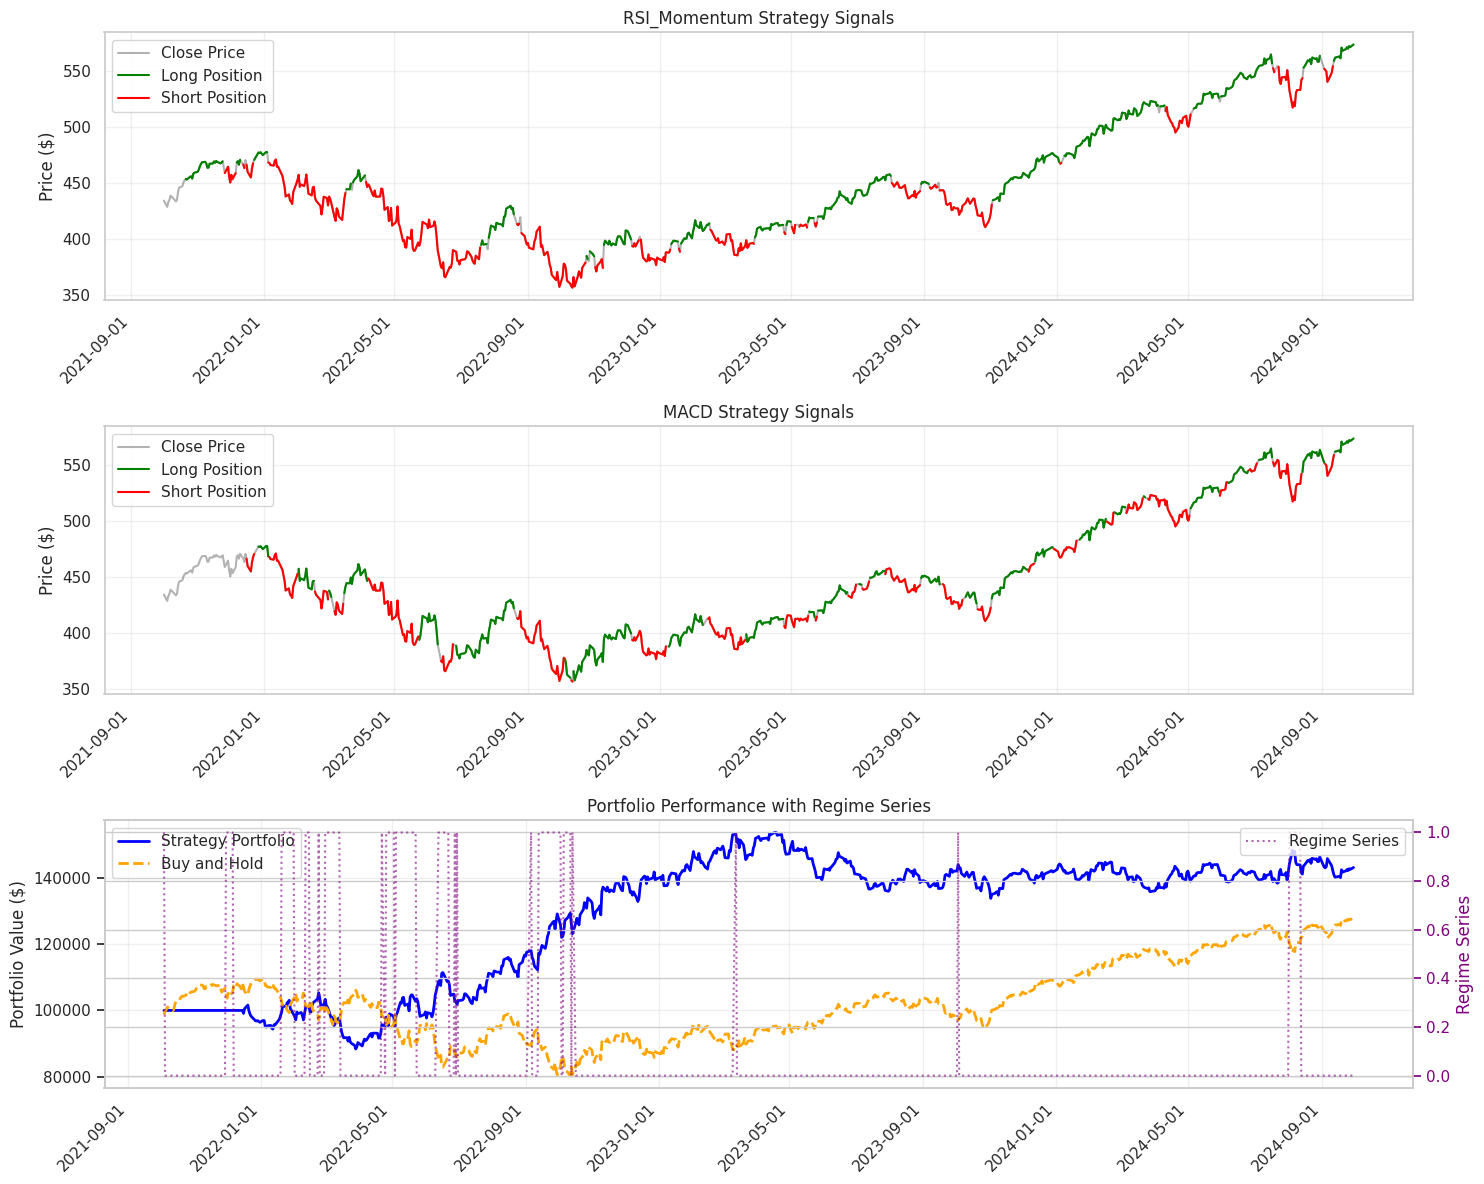

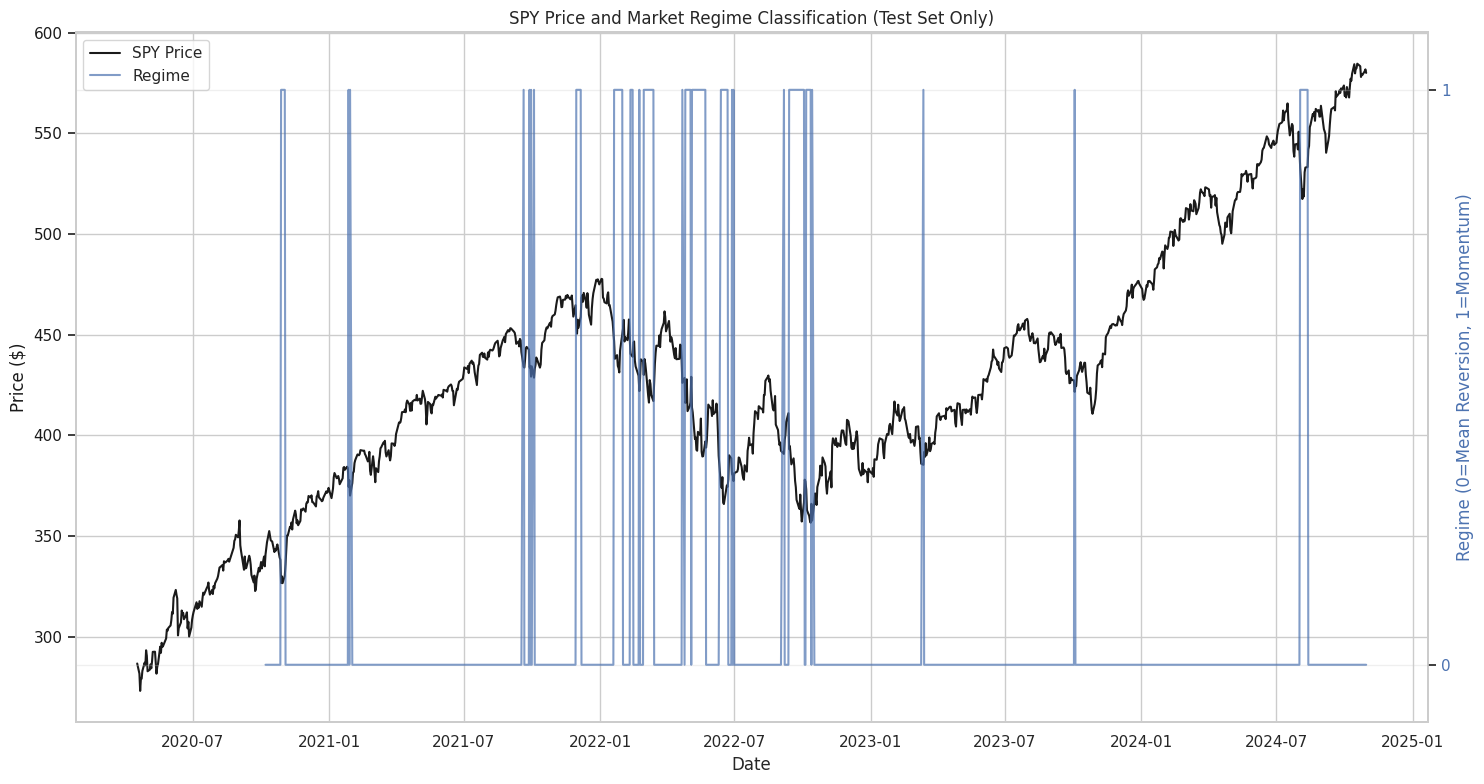

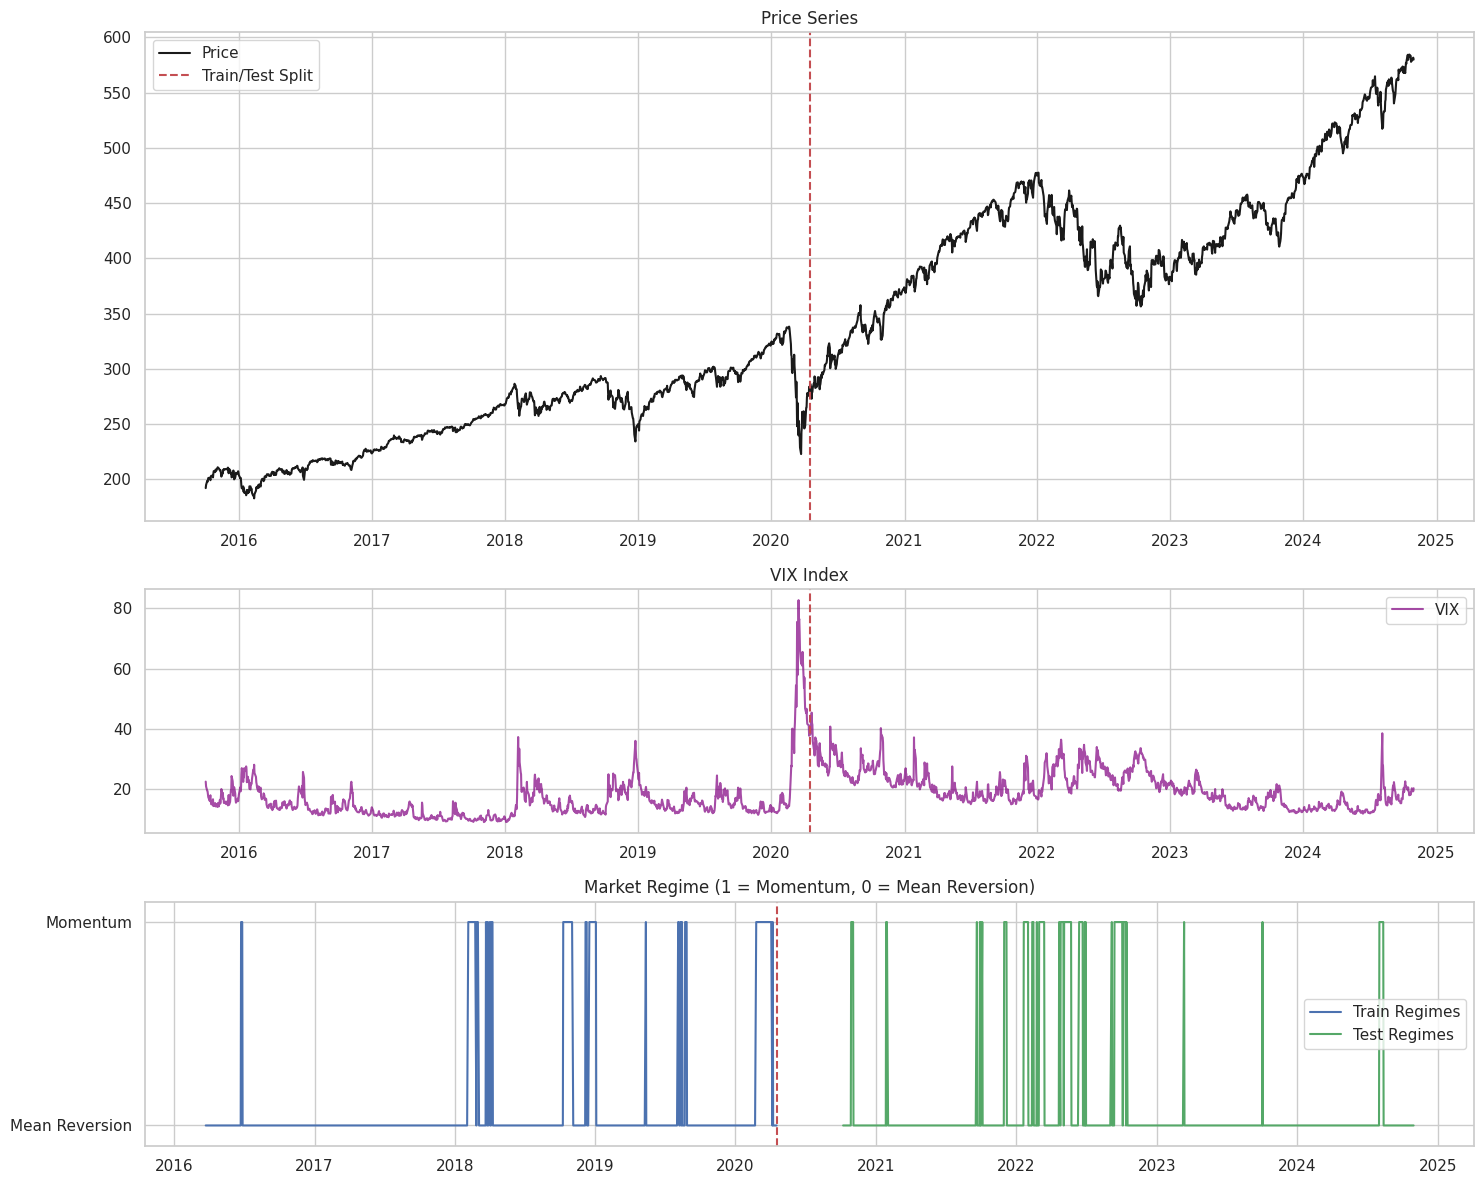

Annualized Sharpe Ratio: 0.64
Compound Annual Growth Rate (CAGR): 9.24%
Total Return: 143.21%
Final Portfolio Value: $143,206.61

Top Worst Drawdown Periods:
                       Max Drawdown (%)  Duration
drawdown_period_group                            
59                           -16.125269      76.0
110                          -12.951716     366.0
63                            -8.596899      31.0
54                            -7.141164      24.0
57                            -5.748135      17.0 

Annual Returns:
             Returns    Performance
Date                               
2022-12-31  0.449237  Above Average
2023-12-31  0.015130  Below Average
2024-12-31  0.009710  Below Average 

Monthly Returns:
             Returns    Performance
Date                               
2021-11-30  0.000000  Below Average
2021-12-31 -0.035937  Below Average
2022-01-31  0.024702  Above Average
2022-02-28  0.030415  Above Average
2022-03-31 -0.113028  Below Average
2022-04-30  0.096214  A

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta
import matplotlib.dates as mdates
import os

class EnhancedTAStrategy:
    def __init__(
        self,
        df,
        short_window=20,
        medium_window=30,
        long_window=120,
        initial_capital=100_000

    ):
        self.df = df
        self.short_window = short_window
        self.medium_window = medium_window
        self.long_window = long_window
        self.initial_capital = initial_capital

        self.strategies = [
            RsiStrategy(),
            MacdStrategy(),
        ]

        self.classifier = KMeansRegimeClassifier(
            short_window=self.short_window,
            medium_window=self.medium_window,
            long_window=self.long_window
        )        
        self.classifier.fit()

        total_strategies = len(self.strategies)
        for strategy in self.strategies:
            strategy.weight = 1.0 / total_strategies

        self.performance_history = []
        self.weight_history = []

    def add_technical_indicators(self):
        for strategy in self.strategies:
            strategy.calculate_indicator(self.df)
        return self.df

    def generate_ensemble_signals(self, regime_ma_period=25, threshold=0.5):
        df = self.df

        regimes_series = self.classifier.test_regimes
        regimes_series.name = 'Regimes'
        df = pd.merge(df, regimes_series, left_index=True, right_index=True, how='outer')

        df['Regime_MA'] = df['Regimes'].rolling(window=regime_ma_period).mean()
        
        regime_threshold = threshold
        df['Regime_State'] = (df['Regime_MA'] > regime_threshold).astype(int)

        for strategy in self.strategies:
            signals = strategy.generate_signals(df)
            df[f'{strategy.name}_Signals'] = signals

        df['Ensemble_Signals'] = np.nan

        if 'MACD_Signals' in df.columns:
            df.loc[df['Regime_State'] == 0, 'Ensemble_Signals'] = df.loc[df['Regime_State'] == 0, 'MACD_Signals']
        if 'RSI_Momentum_Signals' in df.columns:
            df.loc[df['Regime_State'] == 1, 'Ensemble_Signals'] = df.loc[df['Regime_State'] == 1, 'RSI_Momentum_Signals']

        df['Ensemble_Signals'] = df['Ensemble_Signals'].replace(0, np.nan).fillna(method='ffill').shift(1)

        self.df = df

    def simulate_strategy(self, price_column='Close', signal_col='Ensemble_Signals', position_size_fraction=1):

        df = self.df

        if 'Entries' not in df.columns:
            df['Entries'] = np.nan

        if 'Log_Returns' not in df.columns:
            df['Log_Returns'] = np.log(df[price_column] / df[price_column].shift(1))

        direction = 0
        for idx in df.index:
            buy_signal = True if df.at[idx, signal_col] == 1 else False
            sell_signal = True if df.at[idx, signal_col] == -1 else False

            if buy_signal and direction != 1:
                df.at[idx, 'Entries'] = 1
                direction = 1

            elif sell_signal and direction != -1:
                df.at[idx, 'Entries'] = -1
                direction = -1

        df['Position'] = df['Entries'].ffill().fillna(0)
        df['Strategy Log Returns'] = df['Log_Returns'] * df['Position']
        df['Strategy Cumulative Log Returns'] = df['Strategy Log Returns'].cumsum()
        df['Cumulative Log Returns'] = df['Strategy Log Returns'].cumsum()
        df['Cumulative Simple Returns'] = np.exp(df['Cumulative Log Returns']) - 1
        df['Net PnL'] = df['Cumulative Simple Returns'] * position_size_fraction
        df['Portfolio Value'] = (1 + df['Net PnL']) * self.initial_capital

        start_index = df['Portfolio Value'].first_valid_index()
        end_index = df['Portfolio Value'].last_valid_index()
        df = df.loc[start_index:end_index]
        return df, None

    def visualize_strategy_performance(self, start_date=None, end_date=None):
        plot_df = self.df.copy()

        if start_date:
            plot_df = plot_df[plot_df.index >= pd.to_datetime(start_date)]
        if end_date:
            plot_df = plot_df[plot_df.index <= pd.to_datetime(end_date)]

        buy_and_hold = self.initial_capital * (1 + plot_df['Log_Returns'].cumsum())

        regime_series = plot_df['Regimes'].where(~pd.isna(plot_df['Portfolio Value']))

        num_strategies = len(self.strategies)
        fig, axs = plt.subplots(num_strategies + 1, 1, figsize=(15, 4 * (num_strategies + 1)))

        if num_strategies + 1 == 1:
            axs = [axs]

        for i, strategy in enumerate(self.strategies):
            ax = axs[i]
            ax.plot(plot_df.index, plot_df['Close'], color='black', alpha=0.3, label='Close Price')

            if f'{strategy.name}_Signals' in plot_df.columns:
                plot_df['Positioning'] = plot_df[f'{strategy.name}_Signals'].replace(0, np.nan).ffill()
                long_position = plot_df['Close'].where(plot_df['Positioning'] == 1)
                short_position = plot_df['Close'].where(plot_df['Positioning'] == -1)
                ax.plot(plot_df.index, long_position, color='green', label='Long Position')
                ax.plot(plot_df.index, short_position, color='red', label='Short Position')

            ax.set_title(f"{strategy.name} Strategy Signals")
            ax.set_ylabel('Price ($)')
            ax.legend(loc='upper left')
            ax.grid(True, alpha=0.3)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        ax_perf = axs[-1]

        ax_perf.plot(plot_df.index, plot_df['Portfolio Value'], 
                    label='Strategy Portfolio', color='blue', linewidth=2)
        
        ax_perf.plot(plot_df.index, buy_and_hold, 
                    label='Buy and Hold', color='orange', linewidth=2, linestyle='--')

        ax_regime = ax_perf.twinx()
        ax_regime.plot(plot_df.index, regime_series, 
                    label='Regime Series', color='purple', linestyle=':', alpha=0.6)
        ax_regime.set_ylabel('Regime Series', color='purple')
        ax_regime.tick_params(axis='y', colors='purple')

        ax_perf.set_title('Portfolio Performance with Regime Series')
        ax_perf.set_ylabel('Portfolio Value ($)')
        ax_perf.legend(loc='upper left')
        ax_regime.legend(loc='upper right')
        ax_perf.grid(True, alpha=0.3)
        ax_perf.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax_perf.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax_perf.get_xticklabels(), rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def obtain_drawdown(portfolio_values):
        roll_max = portfolio_values.cummax()
        drawdown = (portfolio_values - roll_max) / roll_max
        drawdown_df = pd.DataFrame({
            'Portfolio Value': portfolio_values,
            'Roll Max': roll_max,
            'Drawdown': drawdown
        })
        drawdown_df['Drawdown (%)'] = drawdown_df['Drawdown'] * 100
        return drawdown_df

    @staticmethod
    def calculate_drawdown_stats(group):
        max_drawdown = group['Drawdown (%)'].min()
        duration = group['Drawdown (%)'].count()
        return pd.Series({
            'Max Drawdown (%)': max_drawdown,
            'Duration': duration
        })

    def analyze_drawdown(self, portfolio_column='Portfolio Value'):
        drawdown_df = self.obtain_drawdown(self.df[portfolio_column])
        drawdown_df["drawdown_period_group"] = (drawdown_df["Drawdown (%)"] == 0).cumsum()
        grouped = drawdown_df.groupby("drawdown_period_group")
        drawdown_stats = grouped.apply(self.calculate_drawdown_stats)
        drawdown_stats = drawdown_stats.dropna().sort_values(by='Max Drawdown (%)')
        return drawdown_stats

    def calculate_returns_for_period(self, portfolio_column='Portfolio Value', frequency='Y'):
        resampled_df = self.df[portfolio_column].resample(frequency).last().dropna()
        returns = resampled_df.pct_change().dropna()
        average_return = returns.mean()
        performance = np.where(returns > average_return, 'Above Average', 'Below Average')
        returns_df = pd.DataFrame({
            'Returns': returns,
            'Performance': performance
        })
        return returns_df

    def calculate_cagr(self, portfolio_column='Portfolio Value'):
        start_value = self.df[portfolio_column].dropna().iloc[0]
        end_value = self.df[portfolio_column].dropna().iloc[-1]
        num_days = (self.df.index[-1] - self.df.index[0]).days
        num_years = num_days / 365.25
        cagr = (end_value / start_value) ** (1 / num_years) - 1
        return cagr

    def calculate_annualized_sharpe_ratio(self, returns_column='Strategy Log Returns', risk_free_rate=0.01, frequency=252):
        daily_risk_free_rate = risk_free_rate / frequency
        excess_returns = self.df[returns_column] - daily_risk_free_rate
        mean_excess_return = excess_returns.mean()
        std_excess_return = excess_returns.std()
        annualized_mean = mean_excess_return * frequency
        annualized_std = std_excess_return * np.sqrt(frequency)
        sharpe_ratio = annualized_mean / annualized_std
        return sharpe_ratio

    def get_metrics(self):
        sharpe_ratio = self.calculate_annualized_sharpe_ratio()
        cagr = self.calculate_cagr()
        drawdown_stats = self.analyze_drawdown()
        annual_returns_df = self.calculate_returns_for_period(frequency='Y')
        monthly_returns_df = self.calculate_returns_for_period(frequency='M')
        metrics = {
            'Annualized Sharpe Ratio': sharpe_ratio,
            'Compound Annual Growth Rate (CAGR)': cagr,
            'Drawdown Statistics': drawdown_stats,
            'Annual Returns': annual_returns_df,
            'Monthly Returns': monthly_returns_df,
            'Total Return':  self.df['Portfolio Value'].dropna().iloc[-1] / self.initial_capital,
            'Final Portfolio Value': self.df['Portfolio Value'].dropna().iloc[-1]
        }
        return metrics

    def display_metrics(self, top_n_drawdowns=5):
        metrics = self.get_metrics()

        print(f"Annualized Sharpe Ratio: {metrics['Annualized Sharpe Ratio']:.2f}")
        print(f"Compound Annual Growth Rate (CAGR): {metrics['Compound Annual Growth Rate (CAGR)']:.2%}")
        print(f"Total Return: {metrics['Total Return']:.2%}")
        print(f"Final Portfolio Value: ${metrics['Final Portfolio Value']:,.2f}\n")

        print("Top Worst Drawdown Periods:")
        print(metrics['Drawdown Statistics'].nsmallest(top_n_drawdowns, 'Max Drawdown (%)'), "\n")

        print("Annual Returns:")
        print(metrics['Annual Returns'], "\n")

        print("Monthly Returns:")
        print(metrics['Monthly Returns'], "\n")

ticker = "SPY"
start_date = "2021-10-01"
end_date = "2024-10-01"

df = yf.download(ticker, start=start_date, end=end_date)

strategy = EnhancedTAStrategy(df)

strategy.add_technical_indicators()
strategy.df

strategy.generate_ensemble_signals(regime_ma_period=10, threshold=0.7)

strategy.simulate_strategy()

strategy.visualize_strategy_performance(start_date='2020-11-01')
strategy.classifier.plot_test_set()
strategy.classifier.plot_regimes_with_validation()

strategy.display_metrics()


### <a id = "p1.9"> </a> Strategy 9: XGBoost + ElasticNet + RandomForest + PCA
[Go to Backtest](#p2.9)

In [18]:
# DataManager
class DataManager:
    def __init__(self, start_date: str, end_date: str, symbol: str = 'SPY'):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.symbol = symbol
        self.scaler = StandardScaler()
        self.pca = None
        self.scaled_train_data = None

        self.raw_data = None
        self.raw_feature_df = None 
        self._load_initial_data()
        
    def _load_initial_data(self):
        print(f"Downloading data for {self.symbol}...")
        self.raw_data = yf.download(self.symbol, 
                                  start=self.start_date,
                                  end=self.end_date,
                                  progress=False)
        print("Data download complete.")

    def prepare_enhanced_features(self):
        df = self.raw_data.copy()        
        df['Returns'] = df['Adj Close'].pct_change()
        df['Log_Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
        
        for i in range(1, 11):
            decay = np.exp(-0.1 * i)
            df[f'Return_Lag_{i}'] = df['Returns'].shift(i) * decay
            df[f'Log_Return_Lag_{i}'] = df['Log_Returns'].shift(i) * decay
            
        for window in [5, 10, 20, 50, 100, 200]:
            df[f'SMA_{window}'] = df['Adj Close'].rolling(window=window).mean()
            df[f'EMA_{window}'] = df['Adj Close'].ewm(span=window, adjust=False).mean()
            df[f'Price_to_SMA_{window}'] = df['Adj Close'] / df[f'SMA_{window}']
            
            df[f'ROC_{window}'] = (df['Adj Close'] - df['Adj Close'].shift(window)) / df['Adj Close'].shift(window)
            
        for window in [5, 10, 20, 50]:
            df[f'Volatility_{window}'] = df['Returns'].rolling(window=window).std()
            
            df[f'Parkinson_Volatility_{window}'] = (
                np.log(df['High'] / df['Low'])
                .rolling(window=window)
                .std() / np.sqrt(4 * np.log(2))
            )
            
            high_low = np.log(df['High'] / df['Low'])
            close_open = np.log(df['Close'] / df['Open'])
            df[f'GK_Volatility_{window}'] = (
                (0.5 * high_low ** 2 - (2 * np.log(2) - 1) * close_open ** 2)
                .rolling(window=window)
                .mean()
                .apply(np.sqrt)
            )

        df['Volume_Returns'] = df['Volume'].pct_change()
        for window in [5, 10, 20, 50]:
            df[f'Volume_SMA_{window}'] = df['Volume'].rolling(window=window).mean()
            df[f'Volume_Ratio_{window}'] = df['Volume'] / df[f'Volume_SMA_{window}']
            df[f'Volume_Trend_{window}'] = df[f'Volume_SMA_{window}'].pct_change()
            
            df[f'Money_Flow_{window}'] = (
                df['Adj Close'] * df['Volume']
            ).rolling(window=window).mean()

        custom_strategy = ta.Strategy(
            name="Custom",
            description="Enhanced Technical Indicators Strategy",
            ta=[
                {"kind": "rsi"},
                {"kind": "macd", "fast": 12, "slow": 26, "signal": 9},
                {"kind": "bbands", "length": 20, "std": 2},
                {"kind": "stoch"},
                {"kind": "adx"},
                {"kind": "cci"},
                {"kind": "mfi"},
                {"kind": "kst"},
                {"kind": "trix"},
                {"kind": "vwap"}
            ]
        )
        
        df.ta.strategy(custom_strategy)
        df['Target'] = df['Returns'].shift(-1)
        
        df = df.dropna()
        self.raw_feature_df = df

        return df
    
    def train_test_split(self, train_set_pct=0.8):
        split_idx = int(len(self.raw_feature_df) * train_set_pct)
        self.train_data_df = self.raw_feature_df[:split_idx]
        self.test_data_df  = self.raw_feature_df[split_idx:]

    def fit_scaler_to_train_data(self):
        self.train_data_df = self.train_data_df.fillna(method='ffill')

        X_train = self.train_data_df.drop(columns=['Target'])
        y_train = self.train_data_df['Target']

        scaled_features = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            index=X_train.index,
            columns=X_train.columns
        )

        self.scaled_train_data = pd.concat([scaled_features, y_train], axis=1)
        return self.scaled_train_data


    def fit_pca_to_train_data(self, n_components=20, visualize=False):
        if self.scaled_train_data is None:
            self.fit_scaler_to_train_data()
        
        X_train_scaled = self.scaled_train_data.drop(columns=['Target'])
        y_train = self.scaled_train_data['Target']
        
        self.pca = PCA(n_components=n_components)
        principal_components = self.pca.fit_transform(X_train_scaled)

        self.explained_variance = pd.DataFrame(
            data=self.pca.explained_variance_ratio_ * 100,
            columns=['Explained Variance (%)'],
            index=[f"PC_{i}" for i in range(1, n_components+1)]
        )
        self.cumulative_variance = self.explained_variance.cumsum()
        self.cumulative_variance.columns = ['Cumulative Explained Variance (%)']

        if visualize:
            fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

            self.explained_variance['Explained Variance (%)'].plot.barh(
                ax=axes[0],
                title="Explained Variance by Principal Components",
                xlabel="Explained Variance (%)",
                ylabel="Principal Components"
            )

            self.cumulative_variance['Cumulative Explained Variance (%)'].plot(
                ax=axes[1],
                title="Cumulative Explained Variance",
                xlabel="Number of Principal Components",
                ylabel="Cumulative Variance (%)",
                marker='o'
            )

            plt.tight_layout()
            plt.show()

        principal_components_df = pd.DataFrame(
            data=principal_components,
            index=X_train_scaled.index,
            columns=[f'PC_{i}' for i in range(1, self.pca.n_components_ + 1)]
        )
        
        principal_components_df = pd.concat([principal_components_df, y_train], axis=1)
        self.principal_components_df = principal_components_df
        return self.principal_components_df

    def transform_test_data_with_scaler(self):
        self.test_data_df = self.test_data_df.fillna(method='ffill')

        X_test = self.test_data_df.drop(columns=['Target'])
        y_test = self.test_data_df['Target']

        scaled_features = pd.DataFrame(
            self.scaler.transform(X_test),
            index=X_test.index,
            columns=X_test.columns
        )

        self.scaled_test_data = pd.concat([scaled_features, y_test], axis=1)
        return self.scaled_test_data

    def transform_test_data_with_pca(self):
        if not hasattr(self, 'scaled_test_data'):
            self.transform_test_data_with_scaler()

        X_test_scaled = self.scaled_test_data.drop(columns=['Target'])
        y_test = self.scaled_test_data['Target']
        
        test_principal_components = self.pca.transform(X_test_scaled)
        test_principal_components_df = pd.DataFrame(
            test_principal_components,
            index=X_test_scaled.index,
            columns=[f"PC_{i}" for i in range(1, self.pca.n_components_ + 1)]
        )

        test_principal_components_df = pd.concat(
            [test_principal_components_df, y_test], axis=1
        )
        return test_principal_components_df



    def scale_data(self, data: pd.DataFrame) -> pd.DataFrame:
        data = data.fillna(method='ffill')
        
        X_data = data.drop(columns=['Target'])
        y_data = data['Target']

        scaled_features = pd.DataFrame(
            self.scaler.transform(X_data),
            index=X_data.index,
            columns=X_data.columns
        )

        scaled_data = pd.concat([scaled_features, y_data], axis=1)
        return scaled_data


    def apply_pca(self, data: pd.DataFrame) -> pd.DataFrame:
        data = data.fillna(method='ffill') 
        
        X_data = data.drop(columns=['Target'])
        y_data = data['Target']
        
        principal_components = self.pca.transform(X_data)
        
        principal_components_df = pd.DataFrame(
            principal_components,
            index=X_data.index,
            columns=[f"PC_{i}" for i in range(1, self.pca.n_components_ + 1)]
        )

        principal_components_df = pd.concat(
            [principal_components_df, y_data], axis=1
        )
        return principal_components_df

Data download complete.


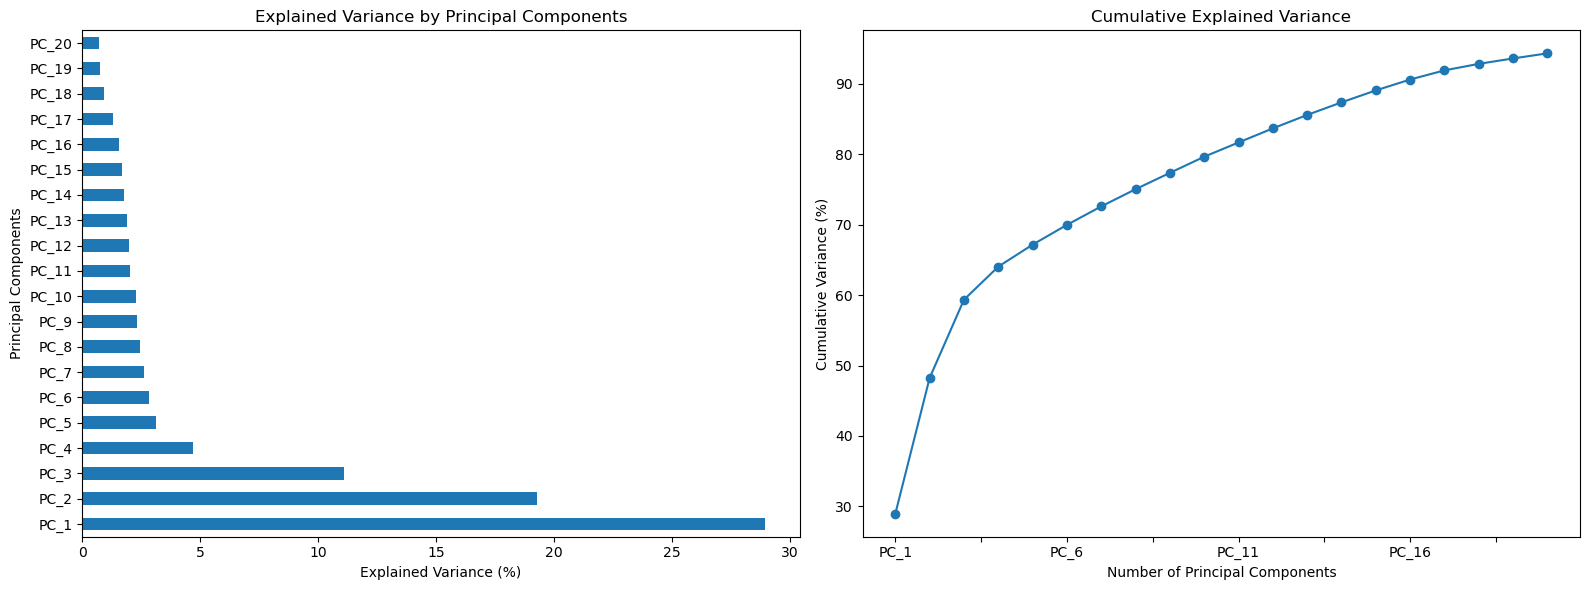

In [32]:
dm = DataManager('2005-01-01', '2024-10-31', 'SPY')
feature_df = dm.prepare_enhanced_features()
dm.train_test_split()
dm.fit_scaler_to_train_data()
X_train_pca = dm.fit_pca_to_train_data(visualize=True)

Data download complete.


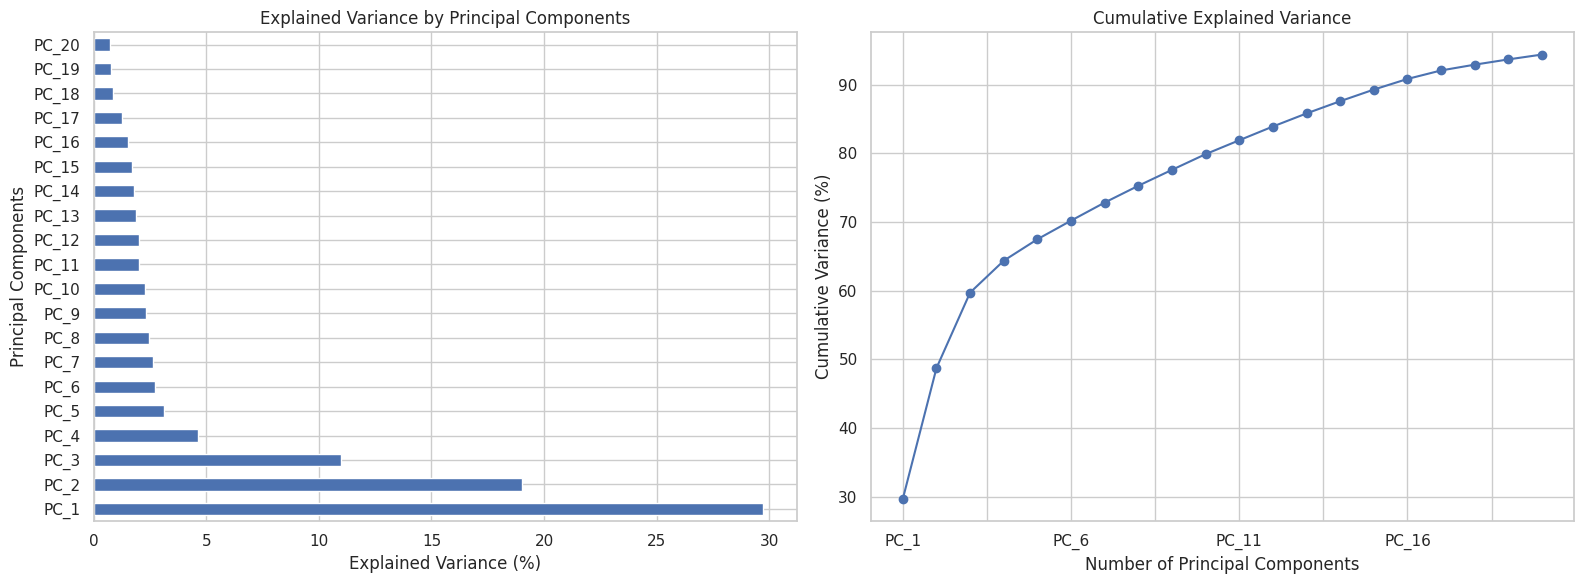

Successfully trained Elastic Net
Successfully trained Random Forest
Successfully trained Gradient Boosting

Training Performance:
                        mse        r2  hit_rate    sharpe  total_return  \
Elastic Net        0.000159  0.029822  0.523472  1.274086     30.845488   
Random Forest      0.000161  0.016336  0.559771  1.392152     44.005852   
Gradient Boosting  0.000147  0.102931  0.560044  1.609719     83.998212   

                   max_drawdown  
Elastic Net           -0.254145  
Random Forest         -0.237464  
Gradient Boosting     -0.205088  

Test Performance:
                        mse        r2  hit_rate    sharpe  total_return  \
Elastic Net        0.000111 -0.016813  0.528384  1.011364      0.749349   
Random Forest      0.000109  0.000606  0.539301  0.922792      0.658541   
Gradient Boosting  0.000119 -0.090024  0.541485  0.787068      0.528639   

                   max_drawdown  
Elastic Net           -0.184588  
Random Forest         -0.208780  
Gradient Bo

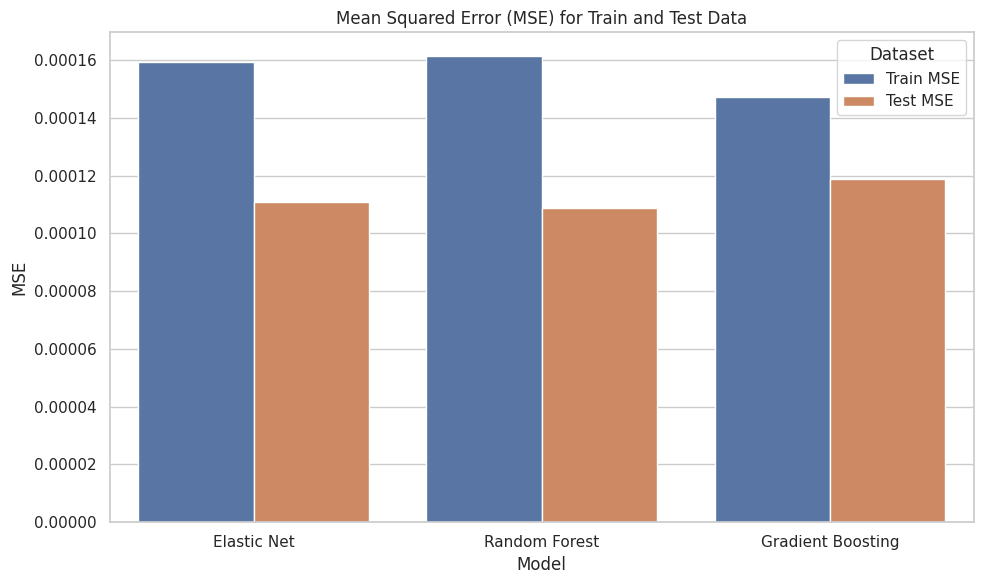

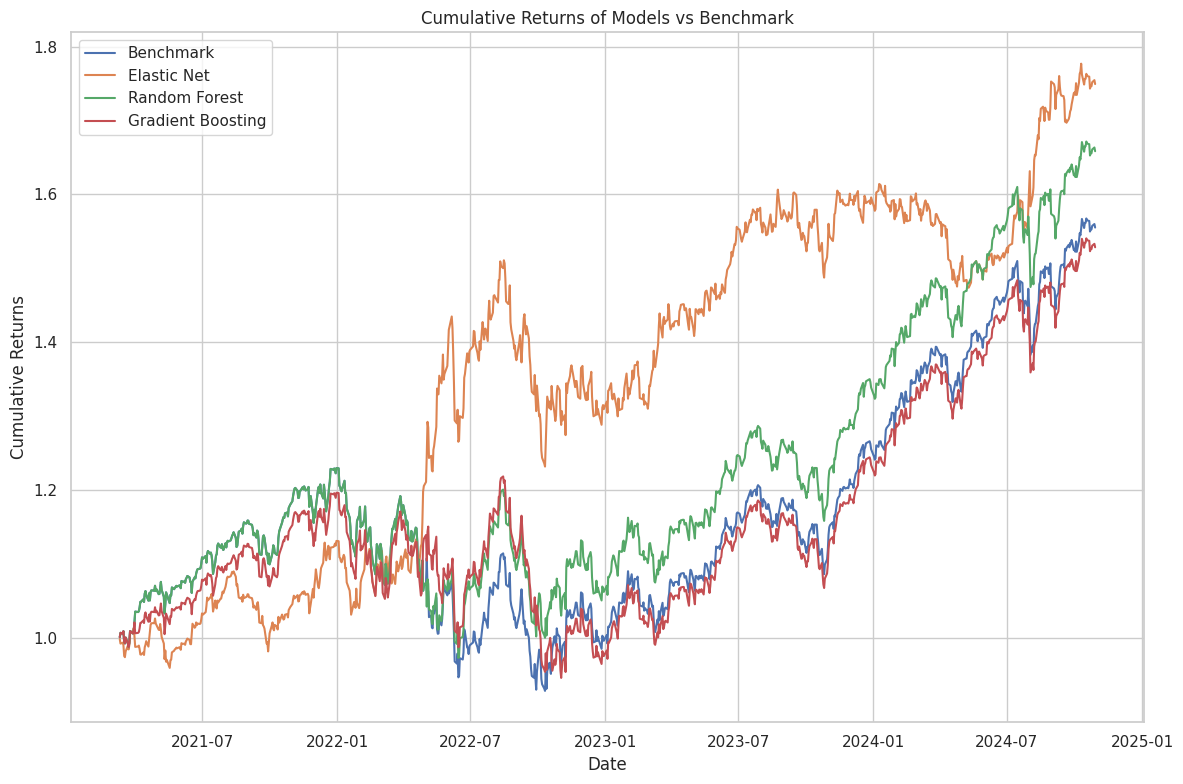

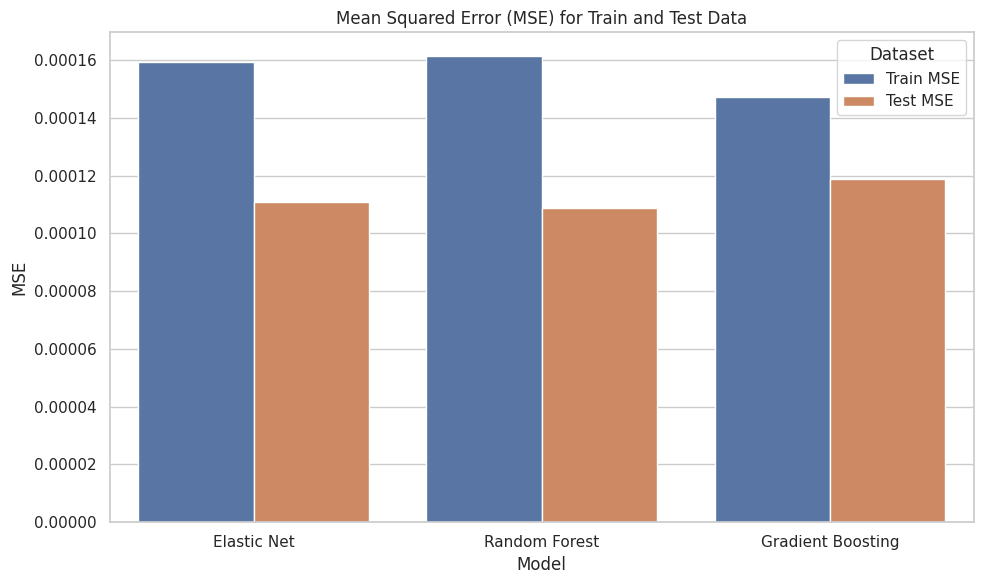

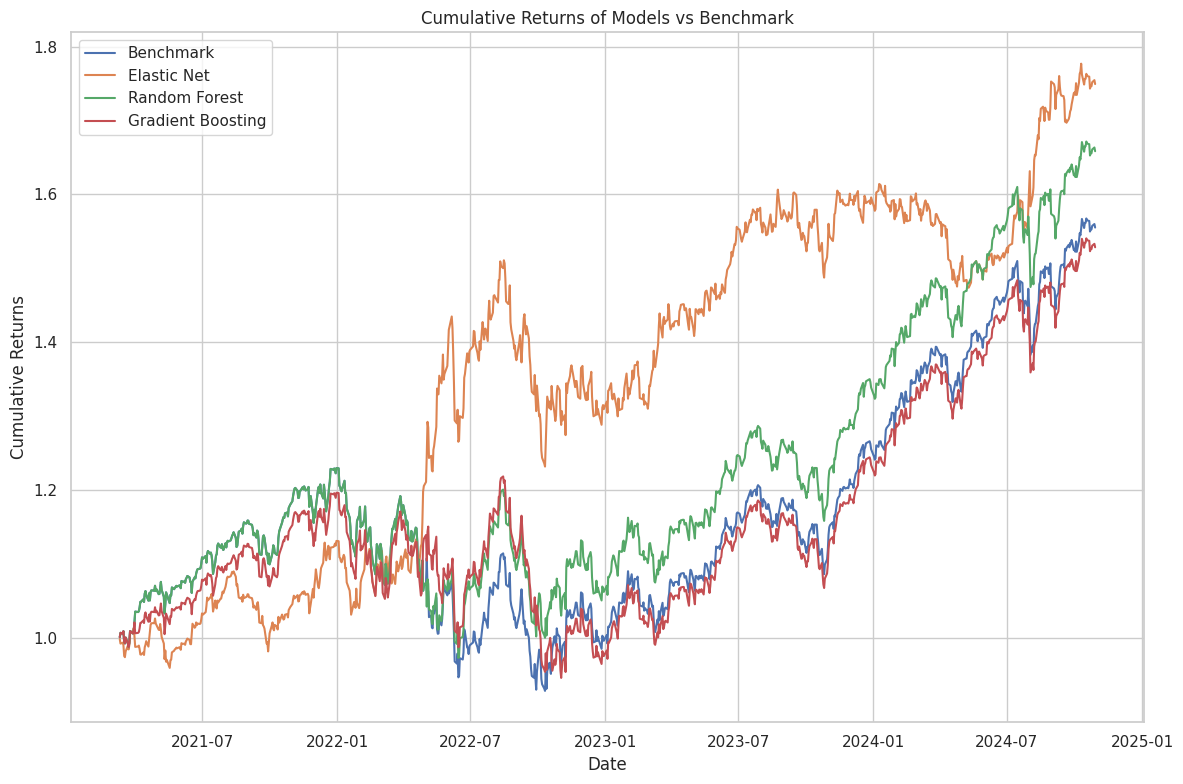

In [19]:
class ModelCreator:
    def __init__(self, data_manager: DataManager):
        self.data_manager = data_manager
        self.model_configs = {
            'elastic_net': {
                'model': ElasticNet(
                    alpha=0.0001,
                    l1_ratio=0.5,
                    random_state=42
                ),
                'name': 'Elastic Net'
            },
            'gradient_boosting': {
                'model': GradientBoostingRegressor(
                    n_estimators=1000,
                    learning_rate=0.01,
                    max_depth=1,
                    min_samples_leaf=20,
                    subsample=0.7,
                    random_state=42
                ),
                'name': 'Gradient Boosting'
            },
            'random_forest': {
                'model': RandomForestRegressor(
                    n_estimators=1000,
                    max_depth=1,
                    min_samples_leaf=20,
                    bootstrap=True,
                    max_features='sqrt',
                    random_state=42
                ),
                'name': 'Random Forest'
            }
        }
        self.performance_metrics = {}
        self.trained_models = {}

    @staticmethod
    def _calculate_metrics(y_pred: np.ndarray, y_true: np.ndarray) -> Dict:
        y_pred = pd.Series(y_pred, index=pd.RangeIndex(len(y_pred)))
        y_true = pd.Series(y_true, index=pd.RangeIndex(len(y_true)))
        
        signals = np.sign(y_pred)
        strategy_returns = signals * y_true
        strategy_returns = pd.Series(strategy_returns, index=y_true.index)
        
        metrics = {
            'mse': mean_squared_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred),
            'hit_rate': np.mean(np.sign(y_pred) == np.sign(y_true)),
            'sharpe': np.sqrt(252) * strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else np.nan
        }
        
        cum_returns = (1 + strategy_returns).cumprod()
        drawdown = cum_returns / cum_returns.cummax() - 1
        
        metrics.update({
            'total_return': cum_returns.iloc[-1] - 1,
            'max_drawdown': drawdown.min()
        })
        
        return metrics

    @staticmethod
    def _train_single_model(model_config: Dict, X_train: pd.DataFrame, y_train: pd.Series) -> Dict:
        try:
            model = model_config['model']
            model_name = model_config['name']
            
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_train)
            
            metrics = ModelCreator._calculate_metrics(y_pred, y_train.values)
            
            return {
                'model_name': model_name,
                'model': model,
                'metrics': metrics
            }
        except Exception as e:
            print(f"Error training {model_config['name']}: {str(e)}")
            return None

    def train_models_parallel(self, pca_train_data: pd.DataFrame):
        X_train = pca_train_data.drop('Target', axis=1)
        y_train = pca_train_data['Target']
        
        model_config_list = list(self.model_configs.values())
        
        with ProcessPoolExecutor() as executor:
            futures = {
                executor.submit(self._train_single_model, config, X_train, y_train): config['name']
                for config in model_config_list
            }
            
            for future in as_completed(futures):
                model_name = futures[future]
                try:
                    result = future.result()
                    if result is not None:
                        self.trained_models[model_name] = result['model']
                        self.performance_metrics[model_name] = result['metrics']
                        print(f"Successfully trained {model_name}")
                    else:
                        print(f"Training failed for {model_name}")
                except Exception as e:
                    print(f"Failed to train {model_name}: {str(e)}")

    def predict(self, pca_data: pd.DataFrame) -> Dict[str, np.ndarray]:
        predictions = {}
        X = pca_data.drop('Target', axis=1)
        
        for model_name, model in self.trained_models.items():
            try:
                predictions[model_name] = model.predict(X)
            except Exception as e:
                print(f"Prediction failed for {model_name}: {str(e)}")
                predictions[model_name] = np.full(len(X), np.nan)
                
        return predictions

    def evaluate_models(self, pca_test_data: pd.DataFrame) -> pd.DataFrame:
        X_test = pca_test_data.drop('Target', axis=1)
        y_test = pca_test_data['Target']
        
        test_metrics = {}
        for model_name, model in self.trained_models.items():
            try:
                y_pred = model.predict(X_test)
                metrics = self._calculate_metrics(y_pred, y_test.values)
                test_metrics[model_name] = metrics
            except Exception as e:
                print(f"Evaluation failed for {model_name}: {str(e)}")
                test_metrics[model_name] = {
                    'mse': np.nan,
                    'r2': np.nan,
                    'hit_rate': np.nan,
                    'sharpe': np.nan,
                    'total_return': np.nan,
                    'max_drawdown': np.nan
                }
                
        return pd.DataFrame.from_dict(test_metrics, orient='index')


    def save_models(self, directory: str):
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_data = {
                'models': self.trained_models,
                'metrics': self.performance_metrics,
                'configs': self.model_configs
            }
            filename = f"{directory}/models_{timestamp}.joblib"
            joblib.dump(save_data, filename)
            print(f"Saved models to {filename}")
        except Exception as e:
            print(f"Failed to save models: {str(e)}")

    def load_models(self, filepath: str):
        try:
            save_data = joblib.load(filepath)
            self.trained_models = save_data['models']
            self.performance_metrics = save_data['metrics']
            self.model_configs = save_data['configs']
            print(f"Successfully loaded models from {filepath}")
        except Exception as e:
            print(f"Failed to load models: {str(e)}")


if __name__ == "__main__":
    dm = DataManager('2005-11-01', '2024-10-31', 'SPY')
    feature_df = dm.prepare_enhanced_features()
    dm.train_test_split()
    dm.fit_scaler_to_train_data()
    train_data = dm.fit_pca_to_train_data(visualize=True)
    test_data = dm.transform_test_data_with_pca()
    
    mc = ModelCreator(dm)
    mc.train_models_parallel(train_data)
    
    print("\nTraining Performance:")
    train_metrics_df = pd.DataFrame.from_dict(mc.performance_metrics, orient='index')
    print(train_metrics_df)
    
    print("\nTest Performance:")
    test_metrics = mc.evaluate_models(test_data)
    print(test_metrics)
    
    
    train_mse = {model: metrics['mse'] for model, metrics in mc.performance_metrics.items()}
    test_mse = {model: metrics['mse'] for model, metrics in test_metrics.iterrows()}
    
    mse_df = pd.DataFrame({
        'Train MSE': train_mse,
        'Test MSE': test_mse
    })
    
    mse_df.reset_index(inplace=True)
    mse_df.rename(columns={'index': 'Model'}, inplace=True)
    
    sns.set(style='whitegrid')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mse_df.melt(id_vars='Model'), 
                x='Model', 
                y='value', 
                hue='variable')
    plt.title('Mean Squared Error (MSE) for Train and Test Data')
    plt.ylabel('MSE')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()
    
    predictions = mc.predict(test_data)
    
    cumulative_returns = pd.DataFrame(index=test_data.index)
    
    cumulative_returns['Benchmark'] = (1 + test_data['Target']).cumprod()
    
    for model_name, y_pred in predictions.items():
        strategy_returns = pd.Series(test_data['Target'].values * np.sign(y_pred), index=test_data.index)
        cum_returns = (1 + strategy_returns).cumprod()
        cumulative_returns[model_name] = cum_returns
    
    plt.figure(figsize=(12, 8))
    for column in cumulative_returns.columns:
        sns.lineplot(data=cumulative_returns, x=cumulative_returns.index, y=column, label=column)
    
    plt.title('Cumulative Returns of Models vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mse_df.melt(id_vars='Model'), 
                x='Model', 
                y='value', 
                hue='variable')
    plt.title('Mean Squared Error (MSE) for Train and Test Data')
    plt.ylabel('MSE')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for column in cumulative_returns.columns:
        sns.lineplot(data=cumulative_returns, x=cumulative_returns.index, y=column, label=column)
    
    plt.title('Cumulative Returns of Models vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()

## <a id = "p2"> </a> Part 2: Backtest & Data Visualization

In [62]:
# Function to plot cumulative returns
def cumulative_returns(data):

    df = data.copy()    
   
    # Calculate cumulative returns
    df["Log_Returns"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
    df["Baseline_Cum"] = df["Log_Returns"].cumsum().apply(np.exp)
    df['Strategy_Returns'] = df["Position"].shift(1).fillna(0) * df["Log_Returns"]
    df["Strategy_Cum"] = df["Strategy_Returns"].cumsum().apply(np.exp)
    
    # Plot
    plt.figure(figsize= [16, 8])
    plt.plot(df["Baseline_Cum"], label="Baseline")
    plt.plot(df["Strategy_Cum"], label="Strategy")
    plt.title('Cumulative Returns: Baseline vs Strategy')
    plt.legend()
    plt.grid()
    plt.show()

In [64]:
# Function to compare strategy performance with SPY
def strategy_performance(data, capital=100000):

    df = data.copy()

    # SPY Baseline Statistics
    df["Log_Returns"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
    df["Cum_Returns"] = df["Log_Returns"].cumsum().apply(np.exp)
    SPY_sharpe = (df["Log_Returns"].mean() / df["Log_Returns"].std()) * np.sqrt(252)
    days = (df.index[-1] - df.index[0]).days
    SPY_cagr = ((df["Adj Close"].iloc[-1] / df["Adj Close"].iloc[0]) ** (365.0 / days)) - 1
    df["Max_Gross_Performance"] = df["Cum_Returns"].cummax()
    SPY_drawdown = (df["Max_Gross_Performance"] - df["Cum_Returns"]).max()
    SPY_cumulative = df["Cum_Returns"].iloc[-1]
    SPY_money_left = SPY_cumulative * capital

    # Strategy Statistics
    df['Strategy_Returns'] = df["Position"].shift(1).fillna(0) * df["Log_Returns"]
    df['Strategy_Cum_Returns'] = df['Strategy_Returns'].cumsum().apply(np.exp)
    strategy_sharpe = (df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()) * np.sqrt(252)
    strategy_cagr = ((df['Strategy_Cum_Returns'].iloc[-1]) ** (365.0 / days)) - 1
    df['Strategy_Max_Gross_Performance'] = df['Strategy_Cum_Returns'].cummax()
    strategy_drawdown = (df['Strategy_Max_Gross_Performance'] - df['Strategy_Cum_Returns']).max()
    strategy_cumulative = df['Strategy_Cum_Returns'].iloc[-1]
    strategy_money_left = strategy_cumulative * capital

    # Compile Results into a DataFrame
    stats = {
        "Sharpe": [SPY_sharpe, strategy_sharpe],
        "CAGR": [SPY_cagr, strategy_cagr],
        "Max Drawdown": [SPY_drawdown, strategy_drawdown],
        "Money Left": [SPY_money_left, strategy_money_left],
        "Cumulative": [SPY_cumulative, strategy_cumulative],
    }

    comparison_df = pd.DataFrame(stats, index=["SPY", "Strategy"])

    return comparison_df

### <font color = "green"><a id = "p2a"> </a> 2.1 Momentum </font>

### <a id = "p2.1"> </a> Strategy 1: Simple Moving Average (SMA)
[Go to Critique](#p4.1)

In [66]:
strategy_performance(SPY1)

Sharpe      CAGR  Max Drawdown     Money Left  Cumulative
SPY       0.520144  0.105836      1.337878  677023.728464    6.770237
Strategy  0.550276  0.112292      2.373704  756249.855234    7.562499

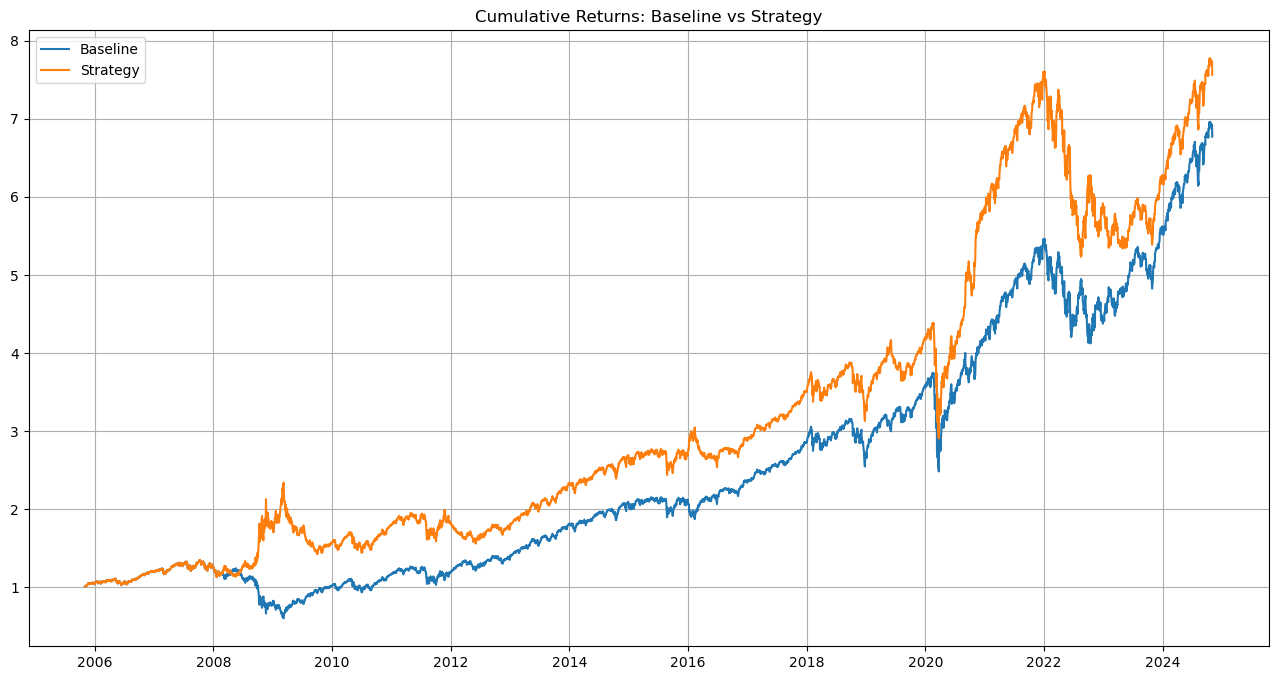

In [68]:
cumulative_returns(SPY1)

### <a id = "p2.2"> </a> Strategy 2: Exponential Moving Average (EMA)
[Go to Critique](#p4.2)

In [70]:
strategy_performance(SPY2)

Sharpe      CAGR  Max Drawdown     Money Left  Cumulative
SPY       0.520144  0.105836      1.337878  677023.728464    6.770237
Strategy  0.590329  0.120930      1.711225  876063.625197    8.760636

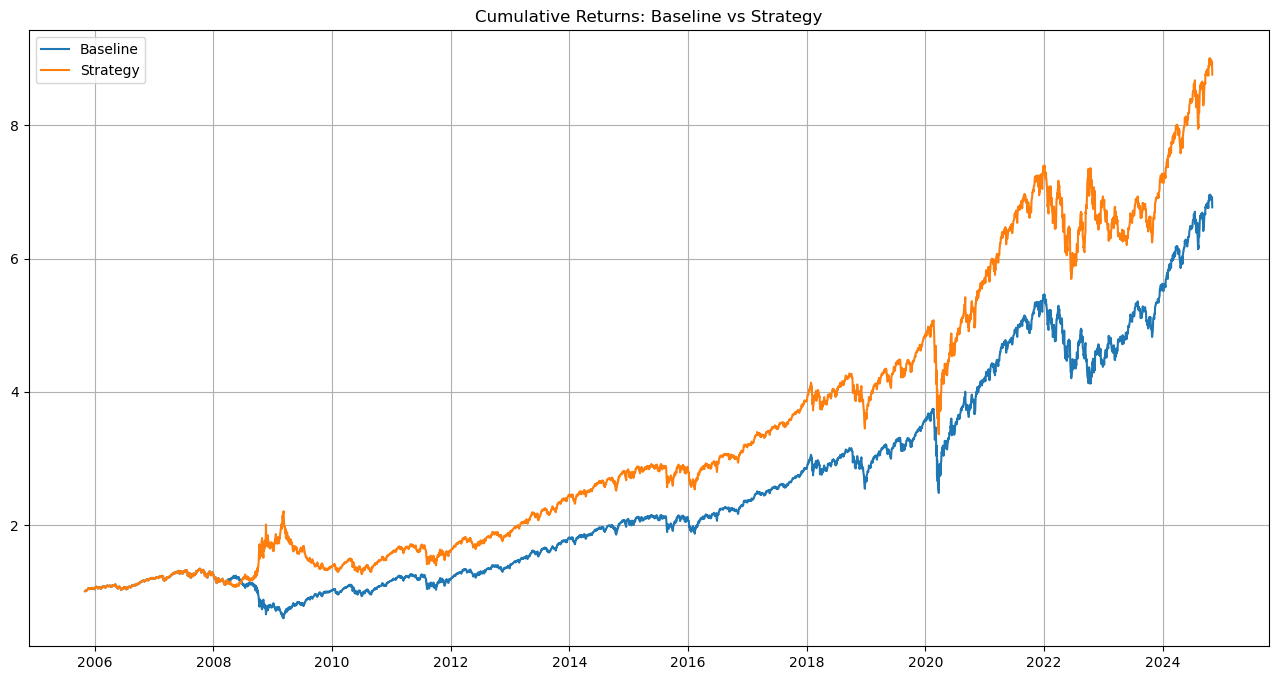

In [72]:
cumulative_returns(SPY2)

### <a id = "p2.3"> </a> Strategy 3: KDJ Indicator
[Go to Critique](#p4.3)

In [74]:
def cal_final_capital(df, initial_capital=100000):
    final_capital = df["cumulative_return"].iloc[-1] * initial_capital
    return final_capital

def cal_sharpe(df):
    Sharpe = np.sqrt(252) * (df["strategy_return"].mean() / df["strategy_return"].std())
    return Sharpe
    
def backtest_kdj(data, n, m1, m2):
    data = calculate_kdj(data, n, m1, m2)

    # 生成交易信号
    data["positions"] = 0
    data.loc[(data["J"] < 20) & (data["K"] > data["D"]), "positions"] = 1  # 买入信号
    data.loc[(data["J"] > 80) & (data["K"] < data["D"]), "positions"] = -1  # 卖出信号
    data["positions"] = data["positions"].ffill()  # 持仓信号

    # 计算收益
    data["log_return"] = np.log(data["Adj Close"] / data["Adj Close"].shift(1))
    data["strategy_return"] = data["positions"].shift(1) * data["log_return"]
    data["cumulative_return"] = data["strategy_return"].cumsum().apply(np.exp)

    return data


def optimize_kdj_params(data,num_iterations=100, initial_capital=100000, random_seed=42):
    np.random.seed(random_seed)

    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]

    best_params = None
    best_result = -np.inf
    best_sharpe = -np.inf

    for _ in range(num_iterations):
        n = np.random.randint(5, 20)
        m1 = np.random.randint(2, 5)
        m2 = np.random.randint(2, 5)

        try:
            result = backtest_kdj(train_data.copy(), n, m1, m2)
            final_capital = cal_final_capital(result, initial_capital)
            sharpe_ratio = cal_sharpe(result)

            if final_capital > best_result and sharpe_ratio > best_sharpe:
                best_result = final_capital
                best_sharpe = sharpe_ratio
                best_params = (n, m1, m2)

        except Exception as e:
            print(f"Error with parameters: n={n}, m1={m1}, m2={m2}, Error={e}")
            continue

    return best_params, best_result, best_sharpe
    
best_params, best_final_capital, best_sharpe = optimize_kdj_params(SPY3)

# Display results
print("KDJ Optimization Results")
print("=========================")
print(f"Best RSV Calculation Period (n): {best_params[0]}")
print(f"Best K Smoothing Coefficient (m1): {best_params[1]}")
print(f"Best D Smoothing Coefficient (m2): {best_params[2]}")
print(f"Best Final Capital: ${int(best_final_capital):.6f}")
print(f"Best Sharpe Ratio: {best_sharpe:.6f}")

KDJ Optimization Results
Best RSV Calculation Period (n): 6
Best K Smoothing Coefficient (m1): 4
Best D Smoothing Coefficient (m2): 2
Best Final Capital: $231967.000000
Best Sharpe Ratio: 0.381397


In [78]:
def cal_CAGR(df):
    days = (df.index[-1] - df.index[0]).days
    CAGR = (((df["cumulative_return"][-1]) / 1)**(365.0/days)) - 1
    return CAGR
    
def cal_max_drawdown(df):
    df["max_performance"] = df["cumulative_return"].cummax()
    df["drawdown"] = df["max_performance"]-df["cumulative_return"]
    max_drawdown = df["drawdown"].max()
    return max_drawdown
    
def calculate_metrics(dataframe):
    metrics = {
        "Sharpe Ratio": cal_sharpe(dataframe),
        "CAGR": cal_CAGR(dataframe),
        "Max Drawdown": cal_max_drawdown(dataframe),
        "Final Capital": cal_final_capital(dataframe)
    }
    metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
    return metrics_df
    
def evaluate_kdj(data, n, m1, m2):
    kdj_with_return = backtest_kdj(data, n, m1, m2)
    kdj_performance = calculate_metrics(kdj_with_return)
    return kdj_with_return, kdj_performance

KDJ_with_return, KDJ_performance = evaluate_kdj(SPY3, 6, 4, 3)
KDJ_performance

Value
Sharpe Ratio        0.450918
CAGR                0.064807
Max Drawdown        0.682099
Final Capital  329946.098799

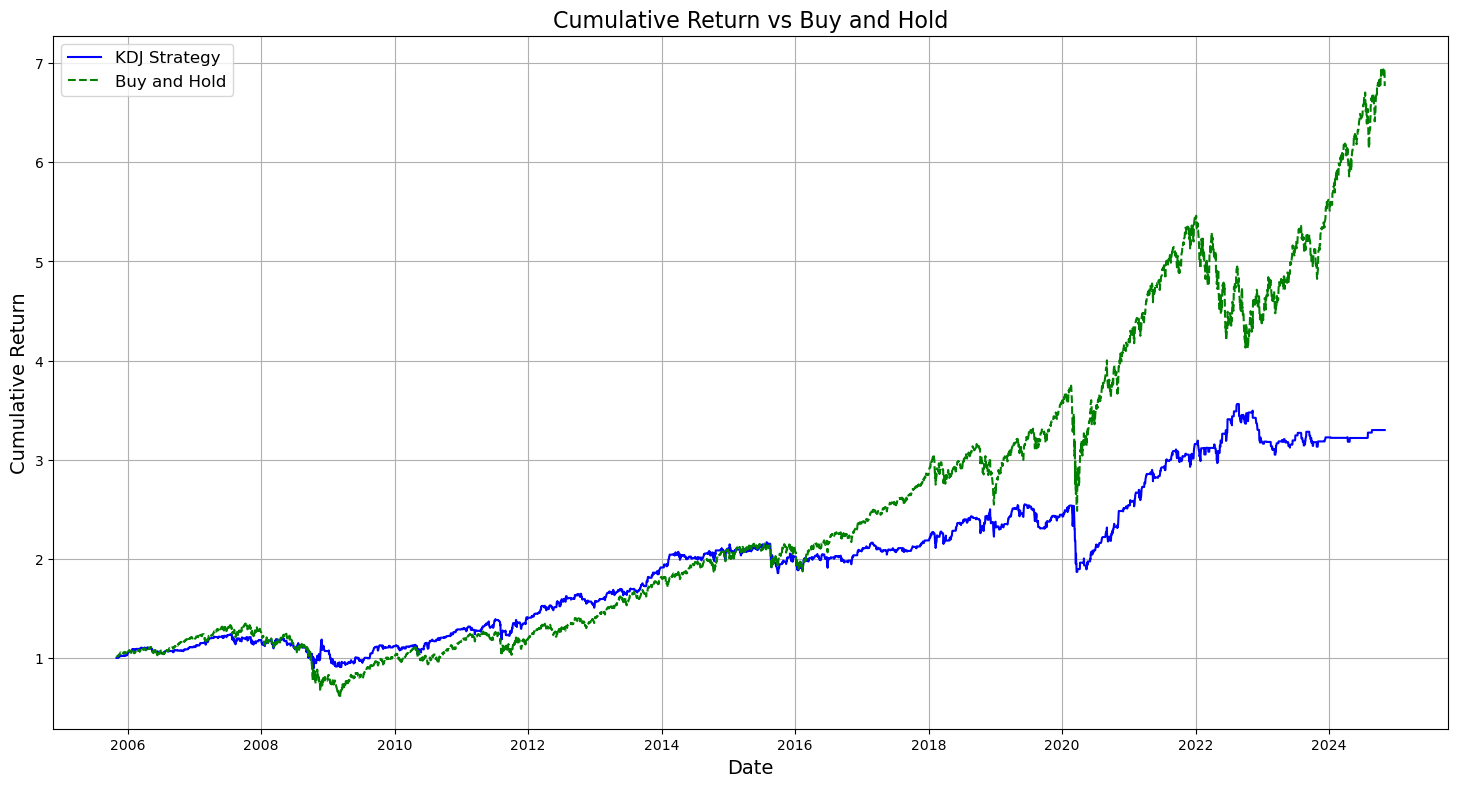

In [80]:
def calculate_strategy_cumulative_return(df):
    df["log_return"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
    df["position t+1"] =df["positions"].ffill().shift(1)
    df["strategy_return"] = df["position t+1"] * df["log_return"]
    df["cumulative_return"] = df["strategy_return"].cumsum().apply(np.exp)
    return df

spy_data = SPY[["Adj Close"]].copy()
spy_data["positions"] = 1
spy_data = calculate_strategy_cumulative_return(spy_data)
spy_base=calculate_strategy_cumulative_return(spy_data)

def plot_strategy_vs_baseline(strategy_data, baseline_data, strategy_label="Strategy", baseline_label="Baseline (Buy and Hold)"):
    # baseline_test_size = int(len(baseline_data) * 0.2)
    # baseline_last_20 = baseline_data.iloc[-baseline_test_size:]

    plt.figure(figsize=[18, 9])
    plt.plot(strategy_data.index, strategy_data["cumulative_return"], label=strategy_label, color="blue")
    plt.plot(baseline_data.index, baseline_data["cumulative_return"], label=baseline_label, color="green", linestyle="--")

    plt.title(f"Cumulative Return vs {baseline_label}", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Cumulative Return", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

plot_strategy_vs_baseline(KDJ_with_return, spy_base, strategy_label="KDJ Strategy", baseline_label="Buy and Hold")

### <font color = "green"><a id = "p2b"> </a> 2.2 Mean-Reversion </font>

### <a id = "p2.4"> </a> Strategy 4: Bollinger Bands
[Go to Critique](#p4.4)

In [82]:
strategy_performance(SPY4)

Sharpe      CAGR  Max Drawdown     Money Left  Cumulative
SPY       0.520144  0.105836      1.337878  677023.728464    6.770237
Strategy  0.565034  0.112748      1.506120  762161.354021    7.621614

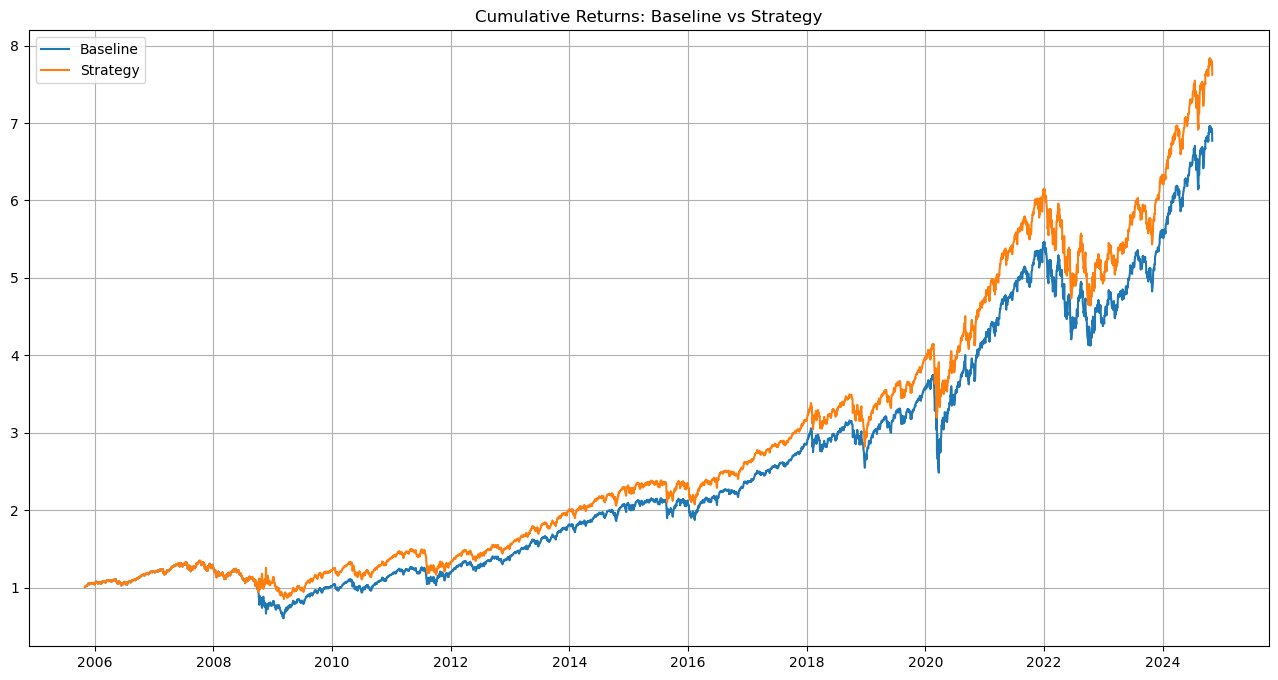

In [84]:
cumulative_returns(SPY4)

### <a id = "p2.5"> </a> Strategy 5: MACD
[Go to Critique](#p4.5)

In [86]:
def backtest_macd(df, short_window, long_window, signal_window):
    df = calculate_macd(df, short_window, long_window, signal_window)
    df['positions'] = np.where(df['MACD_Line'] > df['Signal_Line'], 1, -1)
    df["position t+1"] =df["positions"].ffill().shift(1)
    df["log_return"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
    df["strategy_return"] = df["position t+1"] * df["log_return"]
    df["cumulative_return"] = df["strategy_return"].cumsum().apply(np.exp)
    return df

def backtest_macd(df, short_window, long_window, signal_window):
    df = calculate_macd(df, short_window, long_window, signal_window)
    df['positions'] = np.where(df['MACD_Line'] > df['Signal_Line'], 1, -1)
    df["position t+1"] =df["positions"].ffill().shift(1)
    df["log_return"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
    df["strategy_return"] = df["position t+1"] * df["log_return"]
    df["cumulative_return"] = df["strategy_return"].cumsum().apply(np.exp)
    return df

def random_tuning_macd(data, num_iterations=100, initial_capital=100000,random_seed=42):
    np.random.seed(random_seed)
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]

    best_params = None
    best_result = -np.inf  
    best_sharpe = -np.inf

    for _ in range(num_iterations):
        short_window = np.random.randint(10, 14)  
        long_window = np.random.randint(34, 38) 
        signal_window = np.random.randint(8, 12)  

        if short_window >= long_window:
            continue

        # backtesting
        try:
            train_result = backtest_macd(train_data.copy(), short_window, long_window, signal_window)
            final_capital = cal_final_capital(train_result, initial_capital)
            sharpe_ratio = cal_sharpe(train_result)

            if final_capital > best_result and sharpe_ratio > best_sharpe:
                best_result = final_capital
                best_sharpe = sharpe_ratio
                best_params = (short_window, long_window, signal_window)

        except Exception as e:
            print(f"Error with parameters: Short={short_window}, Long={long_window}, Signal={signal_window}, Error={e}")
            continue

    return best_params, best_result, best_sharpe

MACD_best_params, MACD_best_capital, MACD_best_sharpe = random_tuning_macd(SPY5, num_iterations=1000)

print(f"MACD Best Parameters: Short EMA={MACD_best_params[0]}, Long EMA={MACD_best_params[1]}, Signal EMA={MACD_best_params[2]}")
print(f"MACD Best Final Capital: ${MACD_best_capital:.6f}")
print(f"MACD Best Sharpe Ratio: {MACD_best_sharpe:.6f}")

MACD Best Parameters: Short EMA=13, Long EMA=37, Signal EMA=8
MACD Best Final Capital: $156113.708632
MACD Best Sharpe Ratio: 0.146624


In [88]:
def evaluate_macd(data, short_window, long_window, signal_window):
    macd_with_return = backtest_macd(data, short_window, long_window, signal_window)
    macd_performance = calculate_metrics(macd_with_return)
    return macd_with_return, macd_performance

MACD_with_return, MACD_performance=evaluate_macd(SPY5,13,37,8)
MACD_performance

Value
Sharpe Ratio        0.068710
CAGR                0.013385
Max Drawdown        0.618994
Final Capital  128759.538318

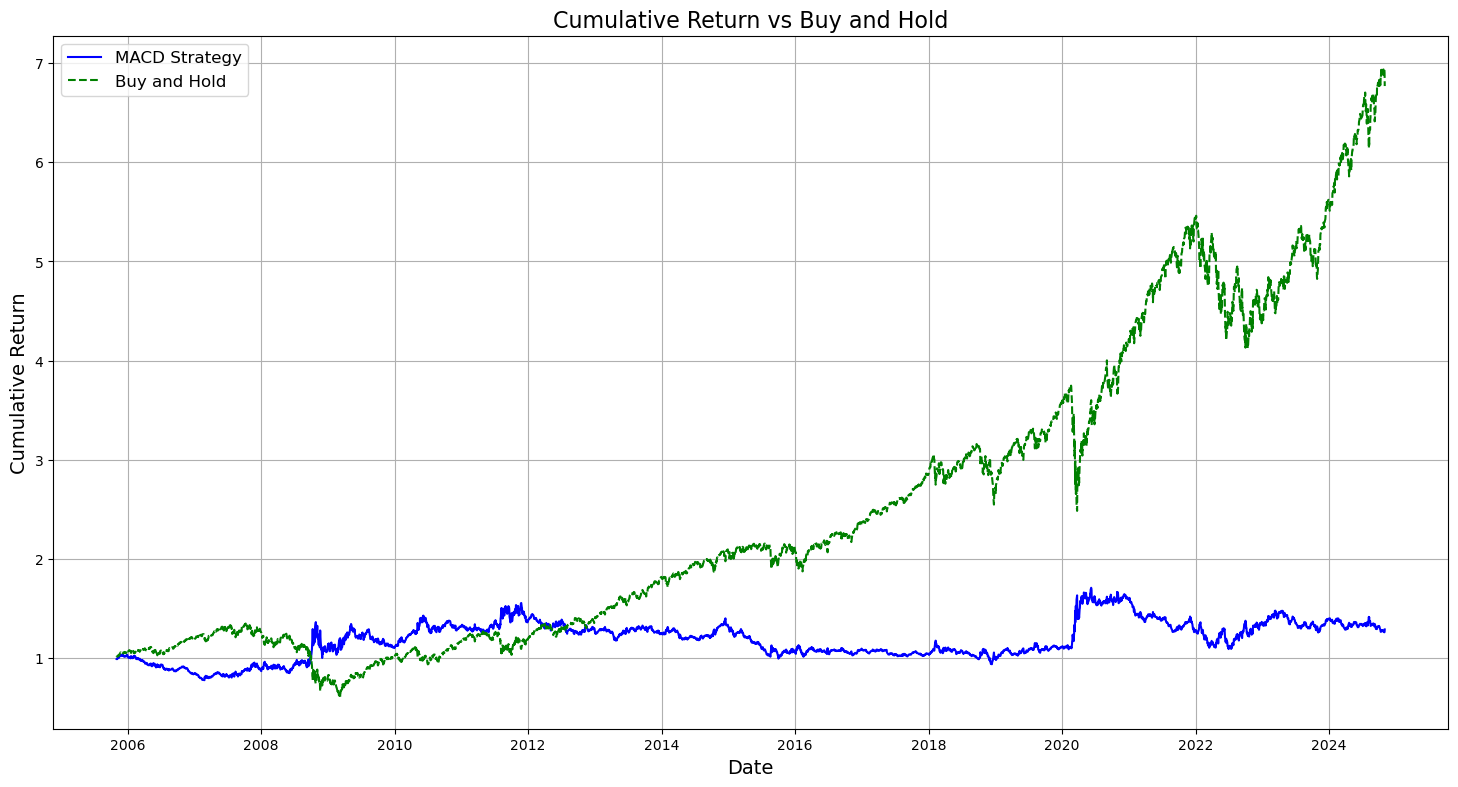

In [90]:
plot_strategy_vs_baseline(MACD_with_return, spy_base, strategy_label="MACD Strategy", baseline_label="Buy and Hold")

### <a id = "p2.6"> </a> Strategy 6: RSI
[Go to Critique](#p4.6)

In [92]:
def backtest_rsi(data, lookback, lower_threshold, upper_threshold):
    # Calculate RSI signals and positions
    position_series, _ = calculate_rsi_signals(data, lookback, lower_threshold, upper_threshold)
    
    # Align data
    data = data.loc[position_series.index].copy()
    data["positions"] = position_series
    data["position t+1"] =data["positions"].ffill().shift(1)
    data["log_return"] = np.log(data["Adj Close"] / data["Adj Close"].shift(1))
    data["strategy_return"] = data["position t+1"] * data["log_return"]
    data["cumulative_return"] = data["strategy_return"].cumsum().apply(np.exp)
    return data


def optimize_rsi_params(data,initial_capital=100000, num_iterations=100, random_seed=42):
    np.random.seed(random_seed)

    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]

    best_params = None
    best_result = -float('inf')
    best_sharpe = -float('inf')

    for _ in range(num_iterations):
        lookback = np.random.randint(5, 30)
        lower_threshold = np.random.randint(10, 40)
        upper_threshold = np.random.randint(60, 90)

        try:
            result = backtest_rsi(train_data.copy(), lookback, lower_threshold, upper_threshold)
            final_capital = cal_final_capital(result, initial_capital)
            sharpe_ratio = cal_sharpe(result)

            # print(f"Testing: lookback={lookback}, lower={lower_threshold}, upper={upper_threshold}, Final Capital={final_capital:.2f}, Sharpe={sharpe_ratio:.2f}")

            if final_capital > best_result and sharpe_ratio > best_sharpe:
                best_result = final_capital
                best_sharpe = sharpe_ratio
                best_params = (lookback, lower_threshold, upper_threshold)

        except Exception as e:
            print(f"Error with lookback={lookback}, lower={lower_threshold}, upper={upper_threshold}: {e}")
            continue

    if best_params is None:
        return (lookback_range[0], threshold_range[0], threshold_range[1]), 0, 0  

    return best_params, best_result, best_sharpe

RSI_best_params, RSI_best_capital, RSI_best_sharpe = optimize_rsi_params(SPY6)

print(f"Best Lookback: {RSI_best_params[0]}")
print(f"Best Lower Threshold: {RSI_best_params[1]}")
print(f"Best Upper Threshold: {RSI_best_params[2]}")
print(f"Best Final Capital: ${RSI_best_capital:.2f}")
print(f"Best Sharpe Ratio: {RSI_best_sharpe:.2f}")

Best Lookback: 5
Best Lower Threshold: 28
Best Upper Threshold: 69
Best Final Capital: $196437.75
Best Sharpe Ratio: 0.45


In [93]:
def evaluate_rsi(data, lookback, lower_threshold, upper_threshold):
    rsi_with_return = backtest_rsi(data, lookback, lower_threshold, upper_threshold)
    rsi_performance = calculate_metrics(rsi_with_return)

    return rsi_with_return, rsi_performance

RSI_with_return, RSI_performance = evaluate_rsi(SPY6,5,28,69)
RSI_performance

Value
Sharpe Ratio        0.431061
CAGR                0.041253
Max Drawdown        0.529749
Final Capital  215655.379303

### <font color = "green"><a id = "p2c"> </a> 2.3 Combined Strategies </font>

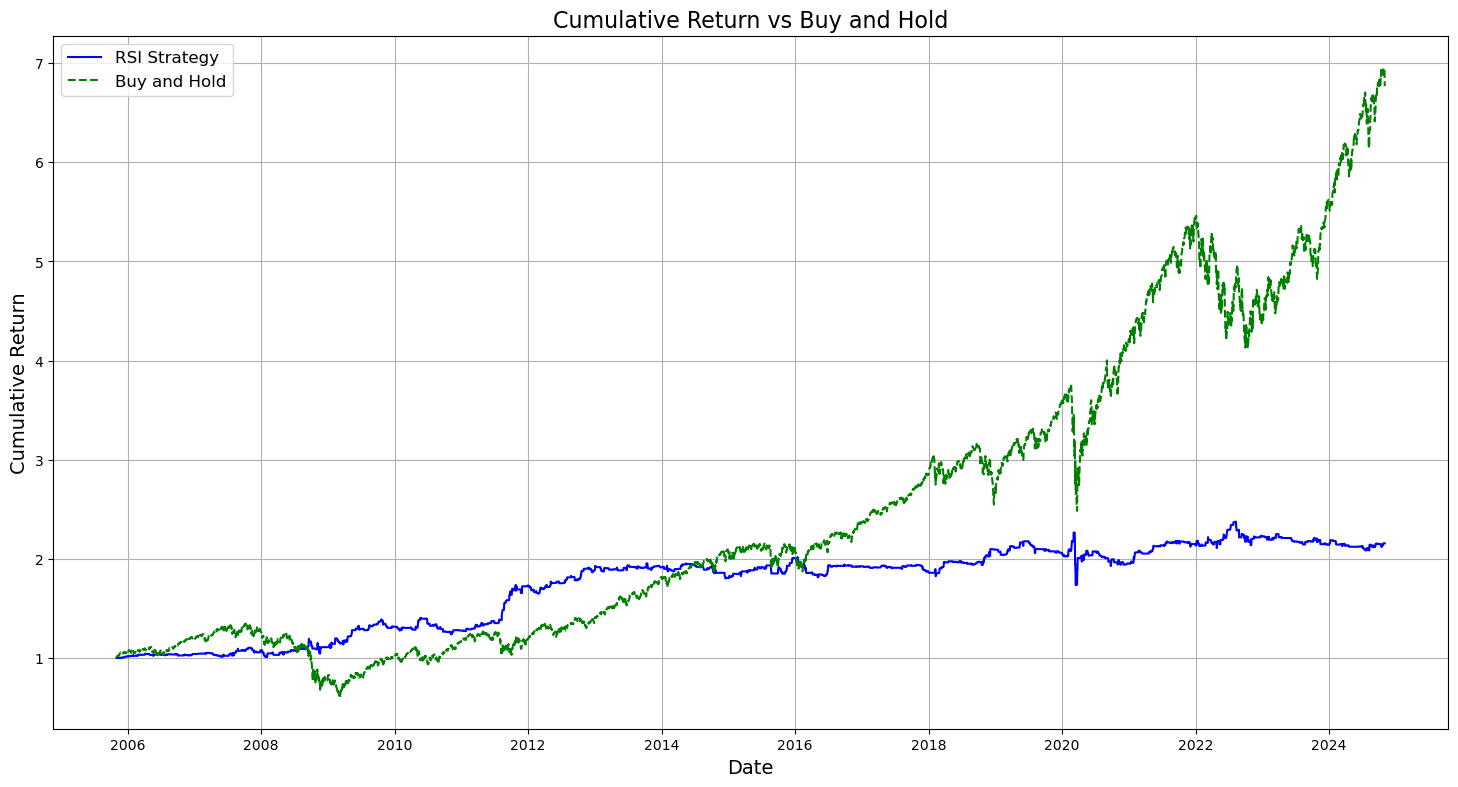

In [94]:
plot_strategy_vs_baseline(RSI_with_return, spy_base, strategy_label="RSI Strategy", baseline_label="Buy and Hold")

### <a id = "p2.7"> </a> Strategy 7: KDJ + MACD
[Go to Critique](#p4.7)

In [99]:
# Optimize KDJ + MACD Parameters
def optimize_kdj_macd_params(data, initial_capital=100000, num_iterations=100, random_seed=42):
    np.random.seed(random_seed)

    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]

    best_params = None
    best_result = -np.inf
    best_sharpe = -np.inf

    for _ in range(num_iterations):
        kdj_n = np.random.randint(5, 20)  # Random KDJ period
        macd_short = np.random.randint(5, 15)  # Random MACD short EMA
        macd_long = np.random.randint(20, 50)  # Random MACD long EMA
        macd_signal = np.random.randint(5, 15)  # Random MACD signal EMA

        if macd_short >= macd_long:
            continue

        try:
            result = combined_kdj_macd_strategy(train_data.copy(), kdj_n, macd_short, macd_long, macd_signal)
            final_capital = cal_final_capital(result, initial_capital)
            sharpe_ratio = cal_sharpe(result)

            if final_capital > best_result and sharpe_ratio > best_sharpe:
                best_result = final_capital
                best_sharpe = sharpe_ratio
                best_params = (kdj_n, macd_short, macd_long, macd_signal)

        except Exception as e:
            print(f"Error with params: KDJ={kdj_n}, MACD={macd_short}-{macd_long}-{macd_signal}, Error: {e}")
            continue

    return best_params, best_result, best_sharpe

combined_best_params,combined_best_capital,combined_best_sharpe = optimize_kdj_macd_params(SPY7, num_iterations=1000)

print(f"Best Parameters:\n"
      f"  KDJ_n: {combined_best_params[0]}\n"
      f"  MACD Short EMA: {combined_best_params[1]}\n"
      f"  MACD Long EMA: {combined_best_params[2]}\n"
      f"  MACD Signal EMA: {combined_best_params[3]}")
print(f"Best Final Capital (Training): ${combined_best_capital:.2f}")
print(f"Best Sharpe Ratio (Training): {combined_best_sharpe:.2f}\n")

Best Parameters:
  KDJ_n: 8
  MACD Short EMA: 10
  MACD Long EMA: 47
  MACD Signal EMA: 11
Best Final Capital (Training): $520024.47
Best Sharpe Ratio (Training): 0.54



In [100]:
def evaluate_kdj_macd(data, kdj_n, macd_short, macd_long, macd_signal, initial_capital=100000):
    kdj_macd_result = combined_kdj_macd_strategy(data, kdj_n, macd_short, macd_long, macd_signal)
    kdj_macd_performance = calculate_metrics(kdj_macd_result)
    return kdj_macd_result, kdj_macd_performance

KDJ_macd_result, KDJ_macd_performance = evaluate_kdj_macd(
    data=SPY7, 
    kdj_n=8, 
    macd_short=10, 
    macd_long=47, 
    macd_signal=11, 
    initial_capital=100000
)
KDJ_macd_performance

Value
Sharpe Ratio        0.361534
CAGR                0.072435
Max Drawdown        2.130573
Final Capital  377903.217380

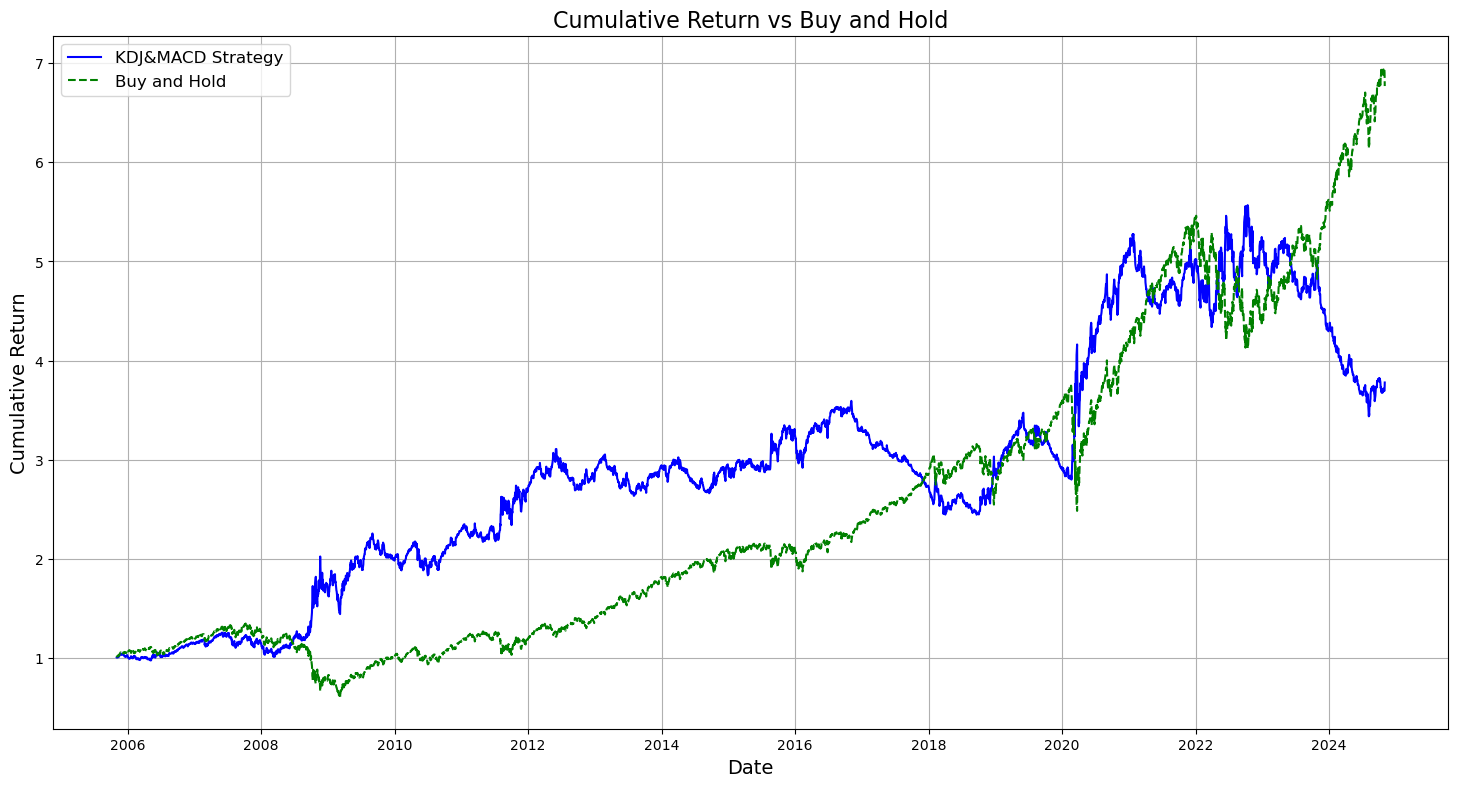

In [101]:
plot_strategy_vs_baseline(KDJ_macd_result, spy_base, strategy_label="KDJ&MACD Strategy", baseline_label="Buy and Hold")

### <a id = "p2.8"> </a> Strategy 8: MACD + RSI + KMeans
[Go to Critique](#p4.8)

In [1]:
class BaseStrategy:
    def __init__(self, name):
        self.name = name
        self.weight = 1.0
        self.performance_history = []

    def calculate_indicator(self, df):
        pass

    def generate_signals(self, df):
        pass

    def calculate_performance(self, returns, signals, method='sharpe'):
        strategy_returns = signals.shift(1) * returns
        strategy_returns = strategy_returns.dropna()
        epsilon = 1e-8

        if method == 'sharpe':
            return np.sqrt(252) * strategy_returns.mean() / (strategy_returns.std() + epsilon)
        elif method == 'sortino':
            neg_returns = strategy_returns[strategy_returns < 0]
            return np.sqrt(252) * strategy_returns.mean() / (neg_returns.std() + epsilon)
        else:
            return (1 + strategy_returns).prod() - 1


class KdjStrategy(BaseStrategy):
    def __init__(self, k_period=14, d_period=3):
        super().__init__('KDJ')
        self.k_period = k_period
        self.d_period = d_period

    def calculate_indicator(self, df):
        stoch = ta.stoch(df['High'], df['Low'], df['Close'], k=self.k_period, d=self.d_period, smooth_k=3)
        df['K'] = stoch[f'STOCHk_{self.k_period}_{self.d_period}_3']
        df['D'] = stoch[f'STOCHd_{self.k_period}_{self.d_period}_3']
        df['J'] = 3 * df['K'] - 2 * df['D']

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        signals[(df['J'] > 20) & (df['J'].shift(1) <= 20)] = 1
        signals[(df['J'] < 80) & (df['J'].shift(1) >= 80)] = -1
        return signals


class StochasticStrategy(BaseStrategy):
    def __init__(self, stoch_period=14):
        super().__init__('Stochastic')
        self.stoch_period = stoch_period

    def calculate_indicator(self, df):
        stoch = ta.stoch(df['High'], df['Low'], df['Close'], k=self.stoch_period, d=3, smooth_k=3)
        df['SlowK'] = stoch['STOCHk_14_3_3']
        df['SlowD'] = stoch['STOCHd_14_3_3']

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        signals[(df['SlowK'] < 20) & (df['SlowK'] > df['SlowD'])] = 1
        signals[(df['SlowK'] > 80) & (df['SlowK'] < df['SlowD'])] = -1
        return signals


class RsiStrategy(BaseStrategy):
    def __init__(self, rsi_period=14):
        super().__init__('RSI_Momentum')
        self.rsi_period = rsi_period

    def calculate_indicator(self, df):
        df['RSI'] = ta.rsi(df['Close'], length=self.rsi_period)

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        signals[df['RSI'] > 45] = 1
        signals[df['RSI'] < 55] = -1
        return signals


class MacdStrategy(BaseStrategy):
    def __init__(self, macd_fast=12, macd_slow=26, macd_signal=9):
        super().__init__('MACD')
        self.macd_fast = macd_fast
        self.macd_slow = macd_slow
        self.macd_signal = macd_signal

    def calculate_indicator(self, df):
        macd = ta.macd(df['Close'], fast=self.macd_fast, slow=self.macd_slow, signal=self.macd_signal)
        df['MACD'] = macd['MACD_12_26_9']
        df['MACD_signal'] = macd['MACDs_12_26_9']

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        signals[(df['MACD'] > df['MACD_signal']) & (df['MACD'].shift(1) <= df['MACD_signal'].shift(1))] = 1
        signals[(df['MACD'] < df['MACD_signal']) & (df['MACD'].shift(1) >= df['MACD_signal'].shift(1))] = -1
        return signals


class BbAdxStrategy(BaseStrategy):
    def __init__(self, bb_period=20, bb_std=2.0, adx_period=14):
        super().__init__('BB_ADX')
        self.bb_period = bb_period
        self.bb_std = bb_std
        self.adx_period = adx_period

    def calculate_indicator(self, df):
        bb = ta.bbands(df['Close'], length=self.bb_period, std=self.bb_std)
        df['BB_Lower'] = bb['BBL_20_2.0']
        df['BB_Upper'] = bb['BBU_20_2.0']
        adx = ta.adx(df['High'], df['Low'], df['Close'], length=self.adx_period)
        df['ADX'] = adx['ADX_14']

    def generate_signals(self, df):
        signals = pd.Series(0, index=df.index)
        strong_trend = df['ADX'] > 25
        signals[(df['Close'] < df['BB_Lower']) & (df['Close'].shift(1) >= df['BB_Lower'].shift(1)) & strong_trend] = 1
        signals[(df['Close'] > df['BB_Upper']) & (df['Close'].shift(1) <= df['BB_Upper'].shift(1)) & strong_trend] = -1
        return signals

In [2]:
class KMeansRegimeClassifier:
    def __init__(self, short_window=20, medium_window=60, long_window=120):
        self.short_window = short_window
        self.medium_window = medium_window
        self.long_window = long_window
        
        self.scaler = None
        self.kmeans = None
        self.momentum_is_1 = None
        self.feature_columns = None
        self.split_date = None
        self.df = None
        self.train_regimes = None
        self.test_regimes = None

    def get_data(self, start_date, end_date):
        spy_file = "SPY_data.csv"
        vix_file = "VIX_data.csv"

        if os.path.exists(spy_file) and os.path.exists(vix_file):
            print("Loading SPY and VIX data from local files...")
            spy = pd.read_csv(spy_file, index_col=0, parse_dates=True)
            vix = pd.read_csv(vix_file, index_col=0, parse_dates=True)
        else:
            print("Downloading SPY and VIX data from Yahoo Finance...")
            spy = yf.download("SPY", start=start_date, end=end_date)
            vix = yf.download("^VIX", start=start_date, end=end_date)
            
            spy.to_csv(spy_file)
            vix.to_csv(vix_file)

        self.df = spy.copy()
        self.df['VIX'] = vix['Close']
        
        return self.df

    def create_features(self, df):
        features = pd.DataFrame(index=df.index)
        
        returns = df['Close'].pct_change()
        
        features['momentum'] = returns.rolling(self.short_window).sum()
        sma_medium = df['Close'].rolling(self.medium_window).mean()
        features['deviation_medium'] = (df['Close'] - sma_medium) / sma_medium
        
        features['vix_level'] = df['VIX']
        features['vix_ma_ratio'] = df['VIX'] / df['VIX'].rolling(self.medium_window).mean()
        features['vix_change'] = df['VIX'].pct_change().rolling(self.short_window).sum()
        
        features['efficiency_ratio'] = self._calculate_efficiency_ratio(df['Close'], self.short_window)
        
        vol_short = returns.rolling(self.short_window).std()
        vol_medium = returns.rolling(self.medium_window).std()
        vol_long = returns.rolling(self.long_window).std()
        
        features['vol_ratio_short_med'] = vol_short / vol_medium
        features['vol_ratio_med_long'] = vol_medium / vol_long
        
        features['price_smoothness'] = (
            df['Close'].rolling(self.short_window).std() / 
            df['Close'].rolling(self.medium_window).std()
        )
        
        return features.dropna()
    
    def _calculate_efficiency_ratio(self, prices, window):
        price_change = abs(prices - prices.shift(window))
        path_length = pd.Series(0.0, index=prices.index)
        for i in range(window):
            path_length += abs(prices.shift(i) - prices.shift(i+1))
        return price_change / path_length

    def train(self, train_data):
        features = self.create_features(train_data)
        
        self.scaler = StandardScaler()
        features_scaled = self.scaler.fit_transform(features)
        
        self.kmeans = KMeans(n_clusters=2, random_state=42)
        regimes = self.kmeans.fit_predict(features_scaled)
        
        cluster_0_efficiency = features[regimes == 0]['efficiency_ratio'].mean()
        cluster_1_efficiency = features[regimes == 1]['efficiency_ratio'].mean()
        
        self.momentum_is_1 = cluster_1_efficiency > cluster_0_efficiency
        self.feature_columns = features.columns
        
        return regimes

    def predict(self, data):
        features = self.create_features(data)
        features = features[self.feature_columns]
        features_scaled = self.scaler.transform(features)
        regimes = self.kmeans.predict(features_scaled)
        
        if not self.momentum_is_1:
            regimes = 1 - regimes
            
        return pd.Series(regimes, index=features.index)

    def plot_regimes_with_validation(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])
        
        ax1.plot(self.df.index, self.df['Close'], 'k-', label='Price')
        ax1.axvline(self.split_date, color='r', linestyle='--', label='Train/Test Split')
        ax1.set_title('Price Series')
        ax1.legend()
        
        ax2.plot(self.df.index, self.df['VIX'], 'purple', label='VIX', alpha=0.7)
        ax2.axvline(self.split_date, color='r', linestyle='--')
        ax2.set_title('VIX Index')
        ax2.legend()
        ax2.grid(True)
        
        ax3.plot(self.train_regimes.index, self.train_regimes, 'b-', label='Train Regimes')
        ax3.plot(self.test_regimes.index, self.test_regimes, 'g-', label='Test Regimes')
        ax3.axvline(self.split_date, color='r', linestyle='--')
        ax3.set_ylim(-0.1, 1.1)
        ax3.set_yticks([0, 1])
        ax3.set_yticklabels(['Mean Reversion', 'Momentum'])
        ax3.set_title('Market Regime (1 = Momentum, 0 = Mean Reversion)')
        ax3.legend()
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_test_set(self):
        test_data = self.df[self.split_date:]
        
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        ax1.plot(test_data.index, test_data['Close'], 'k-', label='SPY Price')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price ($)', color='k')
        ax1.tick_params(axis='y', labelcolor='k')
        
        ax2 = ax1.twinx()
        ax2.plot(self.test_regimes.index, self.test_regimes, 'b-', label='Regime', alpha=0.7)
        ax2.set_ylabel('Regime (0=Mean Reversion, 1=Momentum)', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
        ax2.set_ylim(-0.1, 1.1)
        ax2.set_yticks([0, 1])
        ax2.grid(True, alpha=0.3)
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.title('SPY Price and Market Regime Classification (Test Set Only)')
        plt.tight_layout()
        plt.show()

    def fit(self, start_date="2015-10-01", end_date="2024-10-31", train_size=0.5):
        self.get_data(start_date, end_date)
        
        split_idx = int(len(self.df) * train_size)
        self.split_date = self.df.index[split_idx]
        
        train_data = self.df[:self.split_date]
        test_data = self.df[self.split_date:]
        
        self.train(train_data)
        
        self.train_regimes = self.predict(train_data)
        self.test_regimes = self.predict(test_data)
        
        return self

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


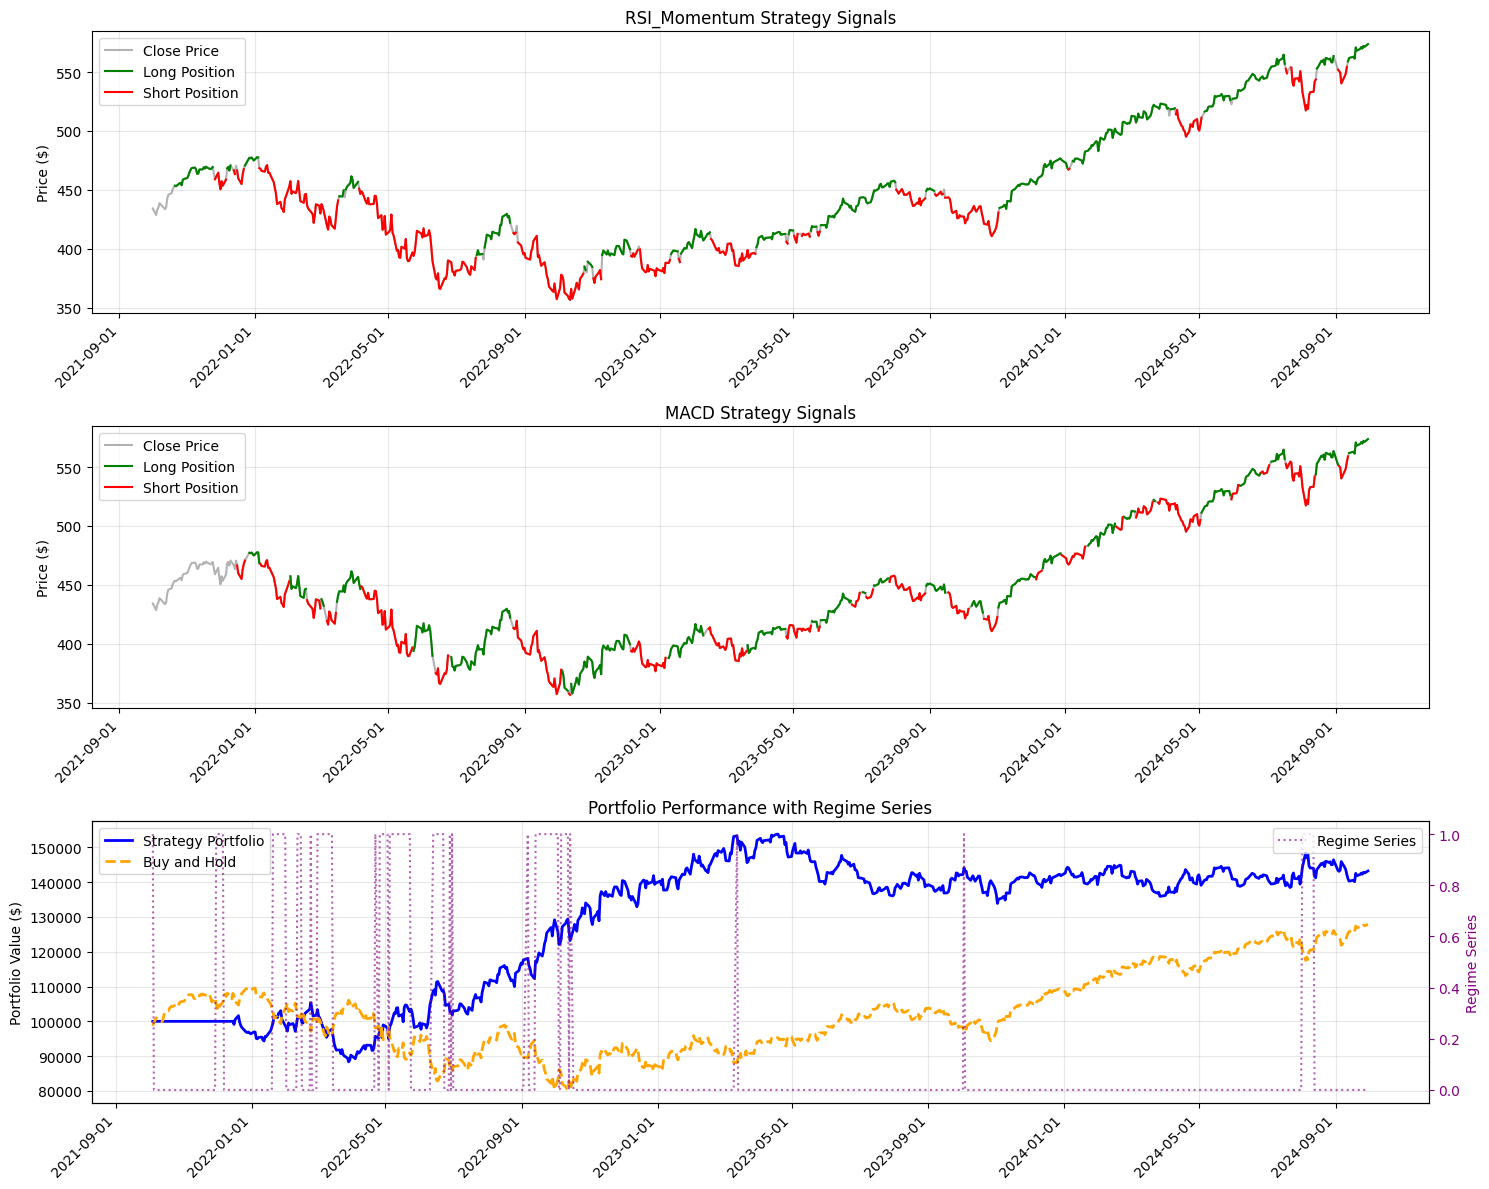

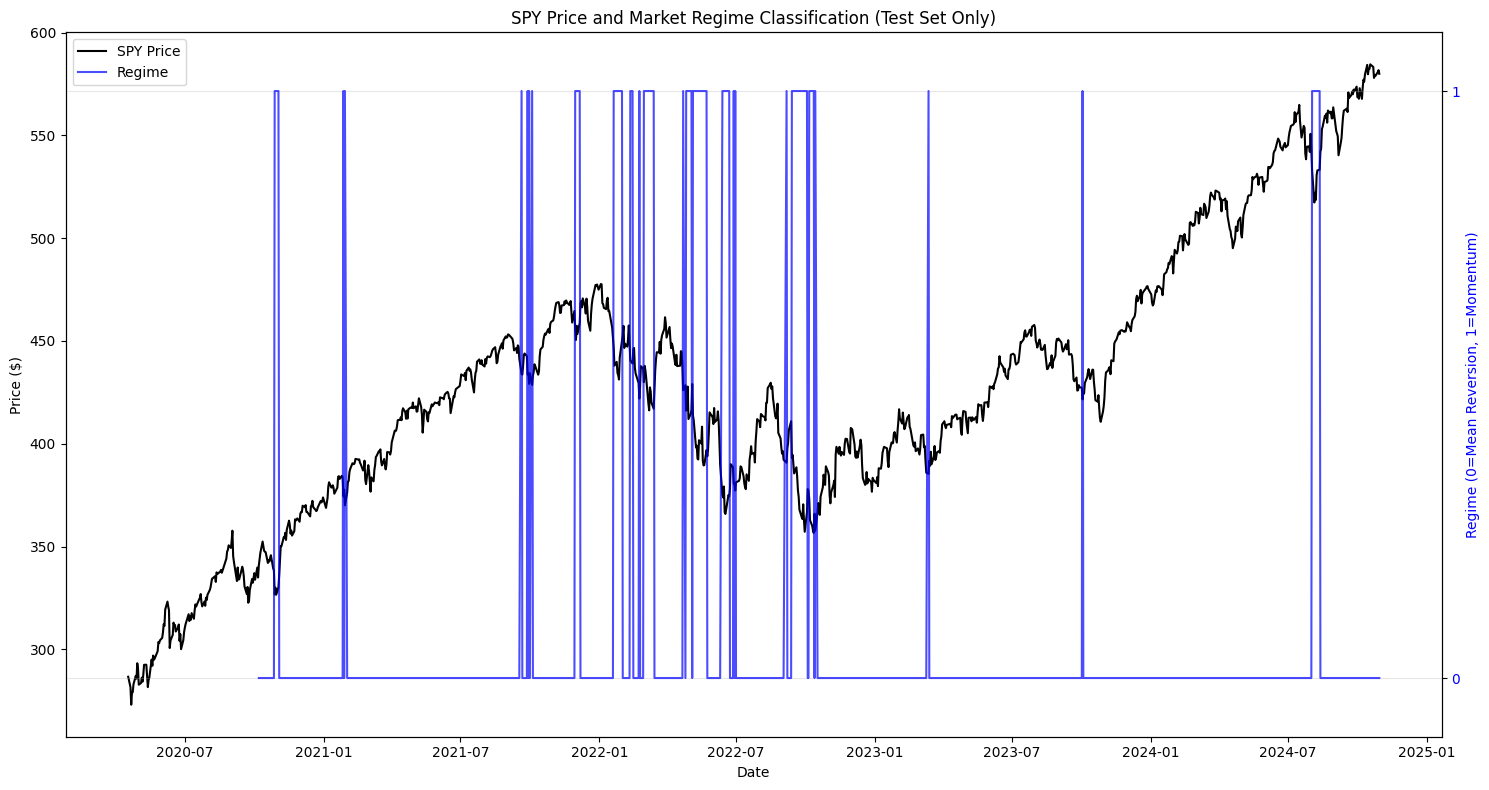

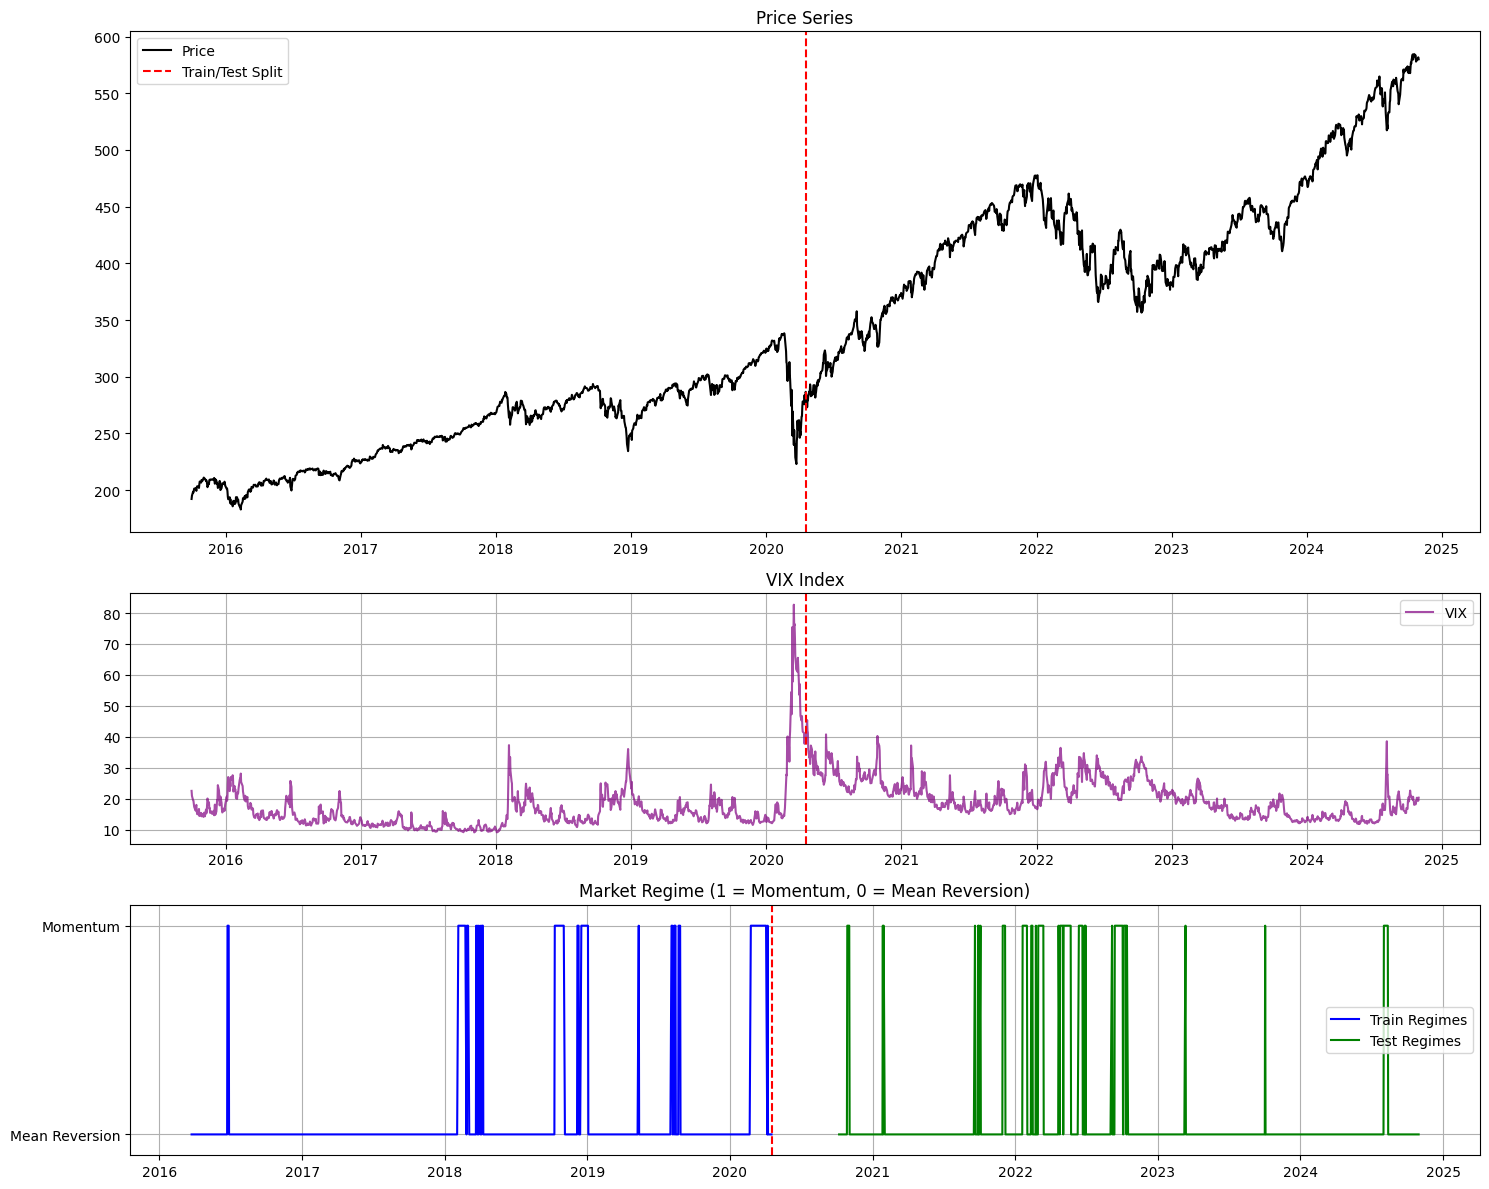

Annualized Sharpe Ratio: 0.64
Compound Annual Growth Rate (CAGR): 9.24%
Total Return: 143.21%
Final Portfolio Value: $143,206.61

Top Worst Drawdown Periods:
                       Max Drawdown (%)  Duration
drawdown_period_group                            
59                           -16.125269      76.0
110                          -12.951716     366.0
63                            -8.596899      31.0
54                            -7.141164      24.0
57                            -5.748135      17.0 

Annual Returns:
             Returns    Performance
Date                               
2022-12-31  0.449237  Above Average
2023-12-31  0.015130  Below Average
2024-12-31  0.009710  Below Average 

Monthly Returns:
             Returns    Performance
Date                               
2021-11-30  0.000000  Below Average
2021-12-31 -0.035937  Below Average
2022-01-31  0.024702  Above Average
2022-02-28  0.030415  Above Average
2022-03-31 -0.113028  Below Average
2022-04-30  0.096214  A

In [4]:
class EnhancedTAStrategy:
    def __init__(
        self,
        df,
        short_window=20,
        medium_window=30,
        long_window=120,
        initial_capital=100_000

    ):
        self.df = df
        self.short_window = short_window
        self.medium_window = medium_window
        self.long_window = long_window
        self.initial_capital = initial_capital

        self.strategies = [
            RsiStrategy(),
            MacdStrategy(),
        ]

        self.classifier = KMeansRegimeClassifier(
            short_window=self.short_window,
            medium_window=self.medium_window,
            long_window=self.long_window
        )        
        self.classifier.fit()

        total_strategies = len(self.strategies)
        for strategy in self.strategies:
            strategy.weight = 1.0 / total_strategies

        self.performance_history = []
        self.weight_history = []

    def add_technical_indicators(self):
        for strategy in self.strategies:
            strategy.calculate_indicator(self.df)
        return self.df

    def generate_ensemble_signals(self, regime_ma_period=25, threshold=0.5):
        df = self.df

        regimes_series = self.classifier.test_regimes
        regimes_series.name = 'Regimes'
        df = pd.merge(df, regimes_series, left_index=True, right_index=True, how='outer')

        df['Regime_MA'] = df['Regimes'].rolling(window=regime_ma_period).mean()
        
        regime_threshold = threshold
        df['Regime_State'] = (df['Regime_MA'] > regime_threshold).astype(int)

        for strategy in self.strategies:
            signals = strategy.generate_signals(df)
            df[f'{strategy.name}_Signals'] = signals

        df['Ensemble_Signals'] = np.nan

        if 'MACD_Signals' in df.columns:
            df.loc[df['Regime_State'] == 0, 'Ensemble_Signals'] = df.loc[df['Regime_State'] == 0, 'MACD_Signals']
        if 'RSI_Momentum_Signals' in df.columns:
            df.loc[df['Regime_State'] == 1, 'Ensemble_Signals'] = df.loc[df['Regime_State'] == 1, 'RSI_Momentum_Signals']

        df['Ensemble_Signals'] = df['Ensemble_Signals'].replace(0, np.nan).fillna(method='ffill').shift(1)

        self.df = df

    def simulate_strategy(self, price_column='Close', signal_col='Ensemble_Signals', position_size_fraction=1):

        df = self.df

        if 'Entries' not in df.columns:
            df['Entries'] = np.nan

        if 'Log_Returns' not in df.columns:
            df['Log_Returns'] = np.log(df[price_column] / df[price_column].shift(1))

        direction = 0
        for idx in df.index:
            buy_signal = True if df.at[idx, signal_col] == 1 else False
            sell_signal = True if df.at[idx, signal_col] == -1 else False

            if buy_signal and direction != 1:
                df.at[idx, 'Entries'] = 1
                direction = 1

            elif sell_signal and direction != -1:
                df.at[idx, 'Entries'] = -1
                direction = -1

        df['Position'] = df['Entries'].ffill().fillna(0)
        df['Strategy Log Returns'] = df['Log_Returns'] * df['Position']
        df['Strategy Cumulative Log Returns'] = df['Strategy Log Returns'].cumsum()
        df['Cumulative Log Returns'] = df['Strategy Log Returns'].cumsum()
        df['Cumulative Simple Returns'] = np.exp(df['Cumulative Log Returns']) - 1
        df['Net PnL'] = df['Cumulative Simple Returns'] * position_size_fraction
        df['Portfolio Value'] = (1 + df['Net PnL']) * self.initial_capital

        start_index = df['Portfolio Value'].first_valid_index()
        end_index = df['Portfolio Value'].last_valid_index()
        df = df.loc[start_index:end_index]
        return df, None

    def visualize_strategy_performance(self, start_date=None, end_date=None):
        plot_df = self.df.copy()

        if start_date:
            plot_df = plot_df[plot_df.index >= pd.to_datetime(start_date)]
        if end_date:
            plot_df = plot_df[plot_df.index <= pd.to_datetime(end_date)]

        buy_and_hold = self.initial_capital * (1 + plot_df['Log_Returns'].cumsum())

        regime_series = plot_df['Regimes'].where(~pd.isna(plot_df['Portfolio Value']))

        num_strategies = len(self.strategies)
        fig, axs = plt.subplots(num_strategies + 1, 1, figsize=(15, 4 * (num_strategies + 1)))

        if num_strategies + 1 == 1:
            axs = [axs]

        for i, strategy in enumerate(self.strategies):
            ax = axs[i]
            ax.plot(plot_df.index, plot_df['Close'], color='black', alpha=0.3, label='Close Price')

            if f'{strategy.name}_Signals' in plot_df.columns:
                plot_df['Positioning'] = plot_df[f'{strategy.name}_Signals'].replace(0, np.nan).ffill()
                long_position = plot_df['Close'].where(plot_df['Positioning'] == 1)
                short_position = plot_df['Close'].where(plot_df['Positioning'] == -1)
                ax.plot(plot_df.index, long_position, color='green', label='Long Position')
                ax.plot(plot_df.index, short_position, color='red', label='Short Position')

            ax.set_title(f"{strategy.name} Strategy Signals")
            ax.set_ylabel('Price ($)')
            ax.legend(loc='upper left')
            ax.grid(True, alpha=0.3)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        ax_perf = axs[-1]

        ax_perf.plot(plot_df.index, plot_df['Portfolio Value'], 
                    label='Strategy Portfolio', color='blue', linewidth=2)
        
        ax_perf.plot(plot_df.index, buy_and_hold, 
                    label='Buy and Hold', color='orange', linewidth=2, linestyle='--')

        ax_regime = ax_perf.twinx()
        ax_regime.plot(plot_df.index, regime_series, 
                    label='Regime Series', color='purple', linestyle=':', alpha=0.6)
        ax_regime.set_ylabel('Regime Series', color='purple')
        ax_regime.tick_params(axis='y', colors='purple')

        ax_perf.set_title('Portfolio Performance with Regime Series')
        ax_perf.set_ylabel('Portfolio Value ($)')
        ax_perf.legend(loc='upper left')
        ax_regime.legend(loc='upper right')
        ax_perf.grid(True, alpha=0.3)
        ax_perf.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax_perf.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax_perf.get_xticklabels(), rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def obtain_drawdown(portfolio_values):
        roll_max = portfolio_values.cummax()
        drawdown = (portfolio_values - roll_max) / roll_max
        drawdown_df = pd.DataFrame({
            'Portfolio Value': portfolio_values,
            'Roll Max': roll_max,
            'Drawdown': drawdown
        })
        drawdown_df['Drawdown (%)'] = drawdown_df['Drawdown'] * 100
        return drawdown_df

    @staticmethod
    def calculate_drawdown_stats(group):
        max_drawdown = group['Drawdown (%)'].min()
        duration = group['Drawdown (%)'].count()
        return pd.Series({
            'Max Drawdown (%)': max_drawdown,
            'Duration': duration
        })

    def analyze_drawdown(self, portfolio_column='Portfolio Value'):
        drawdown_df = self.obtain_drawdown(self.df[portfolio_column])
        drawdown_df["drawdown_period_group"] = (drawdown_df["Drawdown (%)"] == 0).cumsum()
        grouped = drawdown_df.groupby("drawdown_period_group")
        drawdown_stats = grouped.apply(self.calculate_drawdown_stats)
        drawdown_stats = drawdown_stats.dropna().sort_values(by='Max Drawdown (%)')
        return drawdown_stats

    def calculate_returns_for_period(self, portfolio_column='Portfolio Value', frequency='Y'):
        resampled_df = self.df[portfolio_column].resample(frequency).last().dropna()
        returns = resampled_df.pct_change().dropna()
        average_return = returns.mean()
        performance = np.where(returns > average_return, 'Above Average', 'Below Average')
        returns_df = pd.DataFrame({
            'Returns': returns,
            'Performance': performance
        })
        return returns_df

    def calculate_cagr(self, portfolio_column='Portfolio Value'):
        start_value = self.df[portfolio_column].dropna().iloc[0]
        end_value = self.df[portfolio_column].dropna().iloc[-1]
        num_days = (self.df.index[-1] - self.df.index[0]).days
        num_years = num_days / 365.25
        cagr = (end_value / start_value) ** (1 / num_years) - 1
        return cagr

    def calculate_annualized_sharpe_ratio(self, returns_column='Strategy Log Returns', risk_free_rate=0.01, frequency=252):
        daily_risk_free_rate = risk_free_rate / frequency
        excess_returns = self.df[returns_column] - daily_risk_free_rate
        mean_excess_return = excess_returns.mean()
        std_excess_return = excess_returns.std()
        annualized_mean = mean_excess_return * frequency
        annualized_std = std_excess_return * np.sqrt(frequency)
        sharpe_ratio = annualized_mean / annualized_std
        return sharpe_ratio

    def get_metrics(self):
        sharpe_ratio = self.calculate_annualized_sharpe_ratio()
        cagr = self.calculate_cagr()
        drawdown_stats = self.analyze_drawdown()
        annual_returns_df = self.calculate_returns_for_period(frequency='Y')
        monthly_returns_df = self.calculate_returns_for_period(frequency='M')
        metrics = {
            'Annualized Sharpe Ratio': sharpe_ratio,
            'Compound Annual Growth Rate (CAGR)': cagr,
            'Drawdown Statistics': drawdown_stats,
            'Annual Returns': annual_returns_df,
            'Monthly Returns': monthly_returns_df,
            'Total Return':  self.df['Portfolio Value'].dropna().iloc[-1] / self.initial_capital,
            'Final Portfolio Value': self.df['Portfolio Value'].dropna().iloc[-1]
        }
        return metrics

    def display_metrics(self, top_n_drawdowns=5):
        metrics = self.get_metrics()

        print(f"Annualized Sharpe Ratio: {metrics['Annualized Sharpe Ratio']:.2f}")
        print(f"Compound Annual Growth Rate (CAGR): {metrics['Compound Annual Growth Rate (CAGR)']:.2%}")
        print(f"Total Return: {metrics['Total Return']:.2%}")
        print(f"Final Portfolio Value: ${metrics['Final Portfolio Value']:,.2f}\n")

        print("Top Worst Drawdown Periods:")
        print(metrics['Drawdown Statistics'].nsmallest(top_n_drawdowns, 'Max Drawdown (%)'), "\n")

        print("Annual Returns:")
        print(metrics['Annual Returns'], "\n")

        print("Monthly Returns:")
        print(metrics['Monthly Returns'], "\n")

ticker = "SPY"
start_date = "2021-10-01"
end_date = "2024-10-01"

df = yf.download(ticker, start=start_date, end=end_date)

strategy = EnhancedTAStrategy(df)

strategy.add_technical_indicators()
strategy.df

strategy.generate_ensemble_signals(regime_ma_period=10, threshold=0.7)

strategy.simulate_strategy()

strategy.visualize_strategy_performance(start_date='2020-11-01')
strategy.classifier.plot_test_set()
strategy.classifier.plot_regimes_with_validation()

strategy.display_metrics()

### <a id = "p2.9"> </a> Strategy 9: XGBoost + ElasticNet + RandomForest + PCA
[Go to Critique](#p4.9)

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from typing import Tuple, Dict
import pandas_ta as ta
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class DataManager:
    def __init__(self, start_date: str, end_date: str, symbol: str = 'SPY'):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.symbol = symbol
        self.scaler = StandardScaler()
        self.pca = None
        self.scaled_train_data = None

        self.raw_data = None
        self.raw_feature_df = None 
        self._load_initial_data()
        
    def _load_initial_data(self):
        print(f"Downloading data for {self.symbol}...")
        self.raw_data = yf.download(self.symbol, 
                                  start=self.start_date,
                                  end=self.end_date,
                                  progress=False)
        print("Data download complete.")

    def prepare_enhanced_features(self):
        df = self.raw_data.copy()        
        df['Returns'] = df['Adj Close'].pct_change()
        df['Log_Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
        
        for i in range(1, 11):
            decay = np.exp(-0.1 * i)
            df[f'Return_Lag_{i}'] = df['Returns'].shift(i) * decay
            df[f'Log_Return_Lag_{i}'] = df['Log_Returns'].shift(i) * decay
            
        for window in [5, 10, 20, 50, 100, 200]:
            df[f'SMA_{window}'] = df['Adj Close'].rolling(window=window).mean()
            df[f'EMA_{window}'] = df['Adj Close'].ewm(span=window, adjust=False).mean()
            df[f'Price_to_SMA_{window}'] = df['Adj Close'] / df[f'SMA_{window}']
            
            df[f'ROC_{window}'] = (df['Adj Close'] - df['Adj Close'].shift(window)) / df['Adj Close'].shift(window)
            
        for window in [5, 10, 20, 50]:
            df[f'Volatility_{window}'] = df['Returns'].rolling(window=window).std()
            
            df[f'Parkinson_Volatility_{window}'] = (
                np.log(df['High'] / df['Low'])
                .rolling(window=window)
                .std() / np.sqrt(4 * np.log(2))
            )
            
            high_low = np.log(df['High'] / df['Low'])
            close_open = np.log(df['Close'] / df['Open'])
            df[f'GK_Volatility_{window}'] = (
                (0.5 * high_low ** 2 - (2 * np.log(2) - 1) * close_open ** 2)
                .rolling(window=window)
                .mean()
                .apply(np.sqrt)
            )

        df['Volume_Returns'] = df['Volume'].pct_change()
        for window in [5, 10, 20, 50]:
            df[f'Volume_SMA_{window}'] = df['Volume'].rolling(window=window).mean()
            df[f'Volume_Ratio_{window}'] = df['Volume'] / df[f'Volume_SMA_{window}']
            df[f'Volume_Trend_{window}'] = df[f'Volume_SMA_{window}'].pct_change()
            
            df[f'Money_Flow_{window}'] = (
                df['Adj Close'] * df['Volume']
            ).rolling(window=window).mean()

        custom_strategy = ta.Strategy(
            name="Custom",
            description="Enhanced Technical Indicators Strategy",
            ta=[
                {"kind": "rsi"},
                {"kind": "macd", "fast": 12, "slow": 26, "signal": 9},
                {"kind": "bbands", "length": 20, "std": 2},
                {"kind": "stoch"},
                {"kind": "adx"},
                {"kind": "cci"},
                {"kind": "mfi"},
                {"kind": "kst"},
                {"kind": "trix"},
                {"kind": "vwap"}
            ]
        )
        
        df.ta.strategy(custom_strategy)
        df['Target'] = df['Returns'].shift(-1)
        
        df = df.dropna()
        self.raw_feature_df = df

        return df
    
    def train_test_split(self, train_set_pct=0.8):
        split_idx = int(len(self.raw_feature_df) * train_set_pct)
        self.train_data_df = self.raw_feature_df[:split_idx]
        self.test_data_df  = self.raw_feature_df[split_idx:]

    def fit_scaler_to_train_data(self):
        self.train_data_df = self.train_data_df.fillna(method='ffill')

        X_train = self.train_data_df.drop(columns=['Target'])
        y_train = self.train_data_df['Target']

        scaled_features = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            index=X_train.index,
            columns=X_train.columns
        )

        self.scaled_train_data = pd.concat([scaled_features, y_train], axis=1)
        return self.scaled_train_data


    def fit_pca_to_train_data(self, n_components=20, visualize=False):
        if self.scaled_train_data is None:
            self.fit_scaler_to_train_data()
        
        X_train_scaled = self.scaled_train_data.drop(columns=['Target'])
        y_train = self.scaled_train_data['Target']
        
        self.pca = PCA(n_components=n_components)
        principal_components = self.pca.fit_transform(X_train_scaled)

        self.explained_variance = pd.DataFrame(
            data=self.pca.explained_variance_ratio_ * 100,
            columns=['Explained Variance (%)'],
            index=[f"PC_{i}" for i in range(1, n_components+1)]
        )
        self.cumulative_variance = self.explained_variance.cumsum()
        self.cumulative_variance.columns = ['Cumulative Explained Variance (%)']

        if visualize:
            fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

            self.explained_variance['Explained Variance (%)'].plot.barh(
                ax=axes[0],
                title="Explained Variance by Principal Components",
                xlabel="Explained Variance (%)",
                ylabel="Principal Components"
            )

            self.cumulative_variance['Cumulative Explained Variance (%)'].plot(
                ax=axes[1],
                title="Cumulative Explained Variance",
                xlabel="Number of Principal Components",
                ylabel="Cumulative Variance (%)",
                marker='o'
            )

            plt.tight_layout()
            plt.show()

        principal_components_df = pd.DataFrame(
            data=principal_components,
            index=X_train_scaled.index,
            columns=[f'PC_{i}' for i in range(1, self.pca.n_components_ + 1)]
        )
        
        principal_components_df = pd.concat([principal_components_df, y_train], axis=1)
        self.principal_components_df = principal_components_df
        return self.principal_components_df

    def transform_test_data_with_scaler(self):
        self.test_data_df = self.test_data_df.fillna(method='ffill')

        X_test = self.test_data_df.drop(columns=['Target'])
        y_test = self.test_data_df['Target']

        scaled_features = pd.DataFrame(
            self.scaler.transform(X_test),
            index=X_test.index,
            columns=X_test.columns
        )

        self.scaled_test_data = pd.concat([scaled_features, y_test], axis=1)
        return self.scaled_test_data

    def transform_test_data_with_pca(self):
        if not hasattr(self, 'scaled_test_data'):
            self.transform_test_data_with_scaler()

        X_test_scaled = self.scaled_test_data.drop(columns=['Target'])
        y_test = self.scaled_test_data['Target']
        
        test_principal_components = self.pca.transform(X_test_scaled)
        test_principal_components_df = pd.DataFrame(
            test_principal_components,
            index=X_test_scaled.index,
            columns=[f"PC_{i}" for i in range(1, self.pca.n_components_ + 1)]
        )

        test_principal_components_df = pd.concat(
            [test_principal_components_df, y_test], axis=1
        )
        return test_principal_components_df



    def scale_data(self, data: pd.DataFrame) -> pd.DataFrame:
        data = data.fillna(method='ffill')
        
        X_data = data.drop(columns=['Target'])
        y_data = data['Target']

        scaled_features = pd.DataFrame(
            self.scaler.transform(X_data),
            index=X_data.index,
            columns=X_data.columns
        )

        scaled_data = pd.concat([scaled_features, y_data], axis=1)
        return scaled_data


    def apply_pca(self, data: pd.DataFrame) -> pd.DataFrame:
        data = data.fillna(method='ffill') 
        
        X_data = data.drop(columns=['Target'])
        y_data = data['Target']
        
        principal_components = self.pca.transform(X_data)
        
        principal_components_df = pd.DataFrame(
            principal_components,
            index=X_data.index,
            columns=[f"PC_{i}" for i in range(1, self.pca.n_components_ + 1)]
        )

        principal_components_df = pd.concat(
            [principal_components_df, y_data], axis=1
        )
        return principal_components_df



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from concurrent.futures import ProcessPoolExecutor, as_completed
import joblib
from datetime import datetime


class ModelCreator:
    def __init__(self, data_manager: DataManager):
        self.data_manager = data_manager
        self.model_configs = {
            'elastic_net': {
                'model': ElasticNet(
                    alpha=0.0001,
                    l1_ratio=0.5,
                    random_state=42
                ),
                'name': 'Elastic Net'
            },
            'gradient_boosting': {
                'model': GradientBoostingRegressor(
                    n_estimators=1000,
                    learning_rate=0.01,
                    max_depth=1,
                    min_samples_leaf=20,
                    subsample=0.7,
                    random_state=42
                ),
                'name': 'Gradient Boosting'
            },
            'random_forest': {
                'model': RandomForestRegressor(
                    n_estimators=1000,
                    max_depth=1,
                    min_samples_leaf=20,
                    bootstrap=True,
                    max_features='sqrt',
                    random_state=42
                ),
                'name': 'Random Forest'
            }
        }
        self.performance_metrics = {}
        self.trained_models = {}

    @staticmethod
    def _calculate_metrics(y_pred: np.ndarray, y_true: np.ndarray) -> Dict:
        y_pred = pd.Series(y_pred, index=pd.RangeIndex(len(y_pred)))
        y_true = pd.Series(y_true, index=pd.RangeIndex(len(y_true)))
        
        signals = np.sign(y_pred)
        strategy_returns = signals * y_true
        strategy_returns = pd.Series(strategy_returns, index=y_true.index)
        
        metrics = {
            'mse': mean_squared_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred),
            'hit_rate': np.mean(np.sign(y_pred) == np.sign(y_true)),
            'sharpe': np.sqrt(252) * strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else np.nan
        }
        
        cum_returns = (1 + strategy_returns).cumprod()
        drawdown = cum_returns / cum_returns.cummax() - 1
        
        metrics.update({
            'total_return': cum_returns.iloc[-1] - 1,
            'max_drawdown': drawdown.min()
        })
        
        return metrics

    @staticmethod
    def _train_single_model(model_config: Dict, X_train: pd.DataFrame, y_train: pd.Series) -> Dict:
        try:
            model = model_config['model']
            model_name = model_config['name']
            
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_train)
            
            metrics = ModelCreator._calculate_metrics(y_pred, y_train.values)
            
            return {
                'model_name': model_name,
                'model': model,
                'metrics': metrics
            }
        except Exception as e:
            print(f"Error training {model_config['name']}: {str(e)}")
            return None

    def train_models_parallel(self, pca_train_data: pd.DataFrame):
        X_train = pca_train_data.drop('Target', axis=1)
        y_train = pca_train_data['Target']
        
        model_config_list = list(self.model_configs.values())
        
        with ProcessPoolExecutor() as executor:
            futures = {
                executor.submit(self._train_single_model, config, X_train, y_train): config['name']
                for config in model_config_list
            }
            
            for future in as_completed(futures):
                model_name = futures[future]
                try:
                    result = future.result()
                    if result is not None:
                        self.trained_models[model_name] = result['model']
                        self.performance_metrics[model_name] = result['metrics']
                        print(f"Successfully trained {model_name}")
                    else:
                        print(f"Training failed for {model_name}")
                except Exception as e:
                    print(f"Failed to train {model_name}: {str(e)}")

    def predict(self, pca_data: pd.DataFrame) -> Dict[str, np.ndarray]:
        predictions = {}
        X = pca_data.drop('Target', axis=1)
        
        for model_name, model in self.trained_models.items():
            try:
                predictions[model_name] = model.predict(X)
            except Exception as e:
                print(f"Prediction failed for {model_name}: {str(e)}")
                predictions[model_name] = np.full(len(X), np.nan)
                
        return predictions

    def evaluate_models(self, pca_test_data: pd.DataFrame) -> pd.DataFrame:
        X_test = pca_test_data.drop('Target', axis=1)
        y_test = pca_test_data['Target']
        
        test_metrics = {}
        for model_name, model in self.trained_models.items():
            try:
                y_pred = model.predict(X_test)
                metrics = self._calculate_metrics(y_pred, y_test.values)
                test_metrics[model_name] = metrics
            except Exception as e:
                print(f"Evaluation failed for {model_name}: {str(e)}")
                test_metrics[model_name] = {
                    'mse': np.nan,
                    'r2': np.nan,
                    'hit_rate': np.nan,
                    'sharpe': np.nan,
                    'total_return': np.nan,
                    'max_drawdown': np.nan
                }
                
        return pd.DataFrame.from_dict(test_metrics, orient='index')


    def save_models(self, directory: str):
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_data = {
                'models': self.trained_models,
                'metrics': self.performance_metrics,
                'configs': self.model_configs
            }
            filename = f"{directory}/models_{timestamp}.joblib"
            joblib.dump(save_data, filename)
            print(f"Saved models to {filename}")
        except Exception as e:
            print(f"Failed to save models: {str(e)}")

    def load_models(self, filepath: str):
        try:
            save_data = joblib.load(filepath)
            self.trained_models = save_data['models']
            self.performance_metrics = save_data['metrics']
            self.model_configs = save_data['configs']
            print(f"Successfully loaded models from {filepath}")
        except Exception as e:
            print(f"Failed to load models: {str(e)}")



Data download complete.


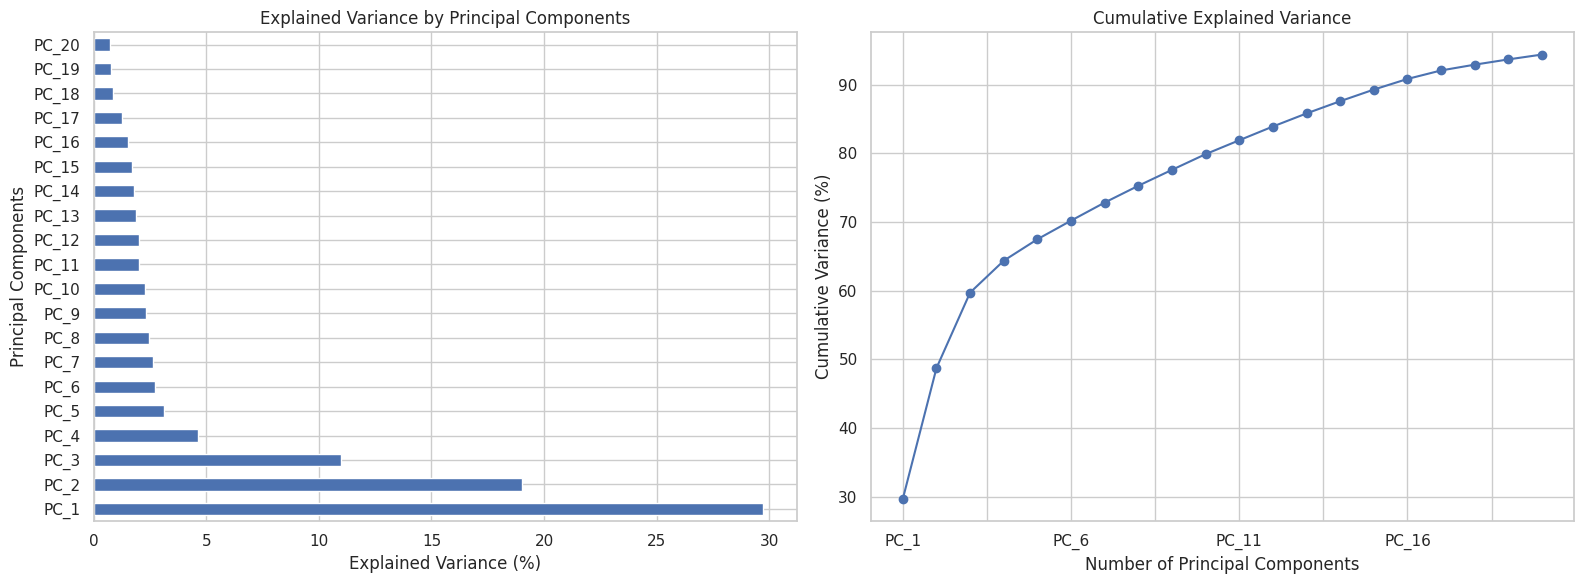

Successfully trained Elastic Net
Successfully trained Random Forest
Successfully trained Gradient Boosting

Training Performance:
                        mse        r2  hit_rate    sharpe  total_return  \
Elastic Net        0.000159  0.029827  0.523745  1.285919     31.969448   
Random Forest      0.000161  0.016356  0.559771  1.392152     44.005852   
Gradient Boosting  0.000147  0.103121  0.560317  1.624834     87.824140   

                   max_drawdown  
Elastic Net           -0.254145  
Random Forest         -0.237464  
Gradient Boosting     -0.205088  

Test Performance:
                        mse        r2  hit_rate    sharpe  total_return  \
Elastic Net        0.000111 -0.016819  0.529476  1.050937      0.791366   
Random Forest      0.000109  0.000650  0.539301  0.922792      0.658541   
Gradient Boosting  0.000119 -0.090646  0.542576  0.834818      0.573160   

                   max_drawdown  
Elastic Net           -0.184588  
Random Forest         -0.208780  
Gradient Bo

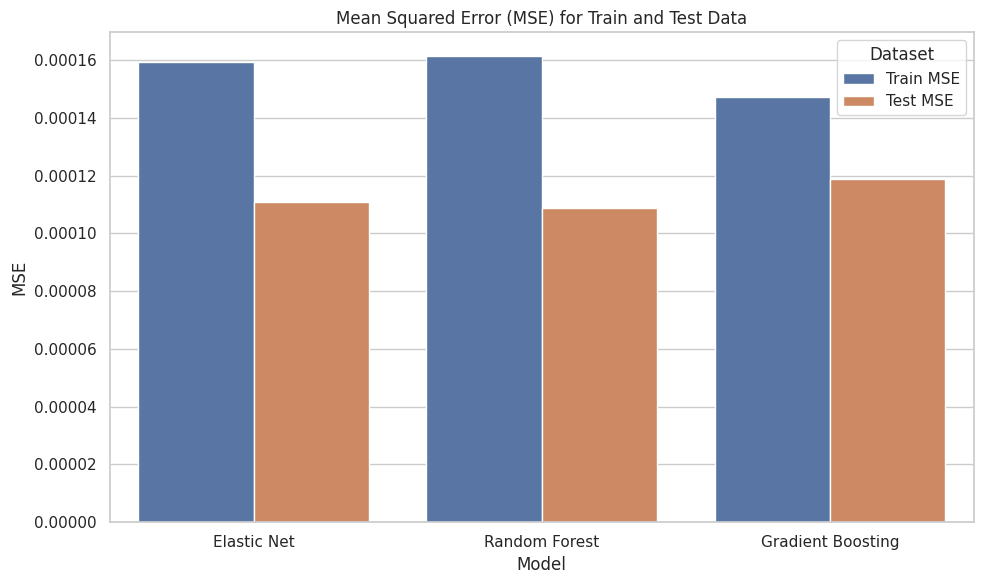

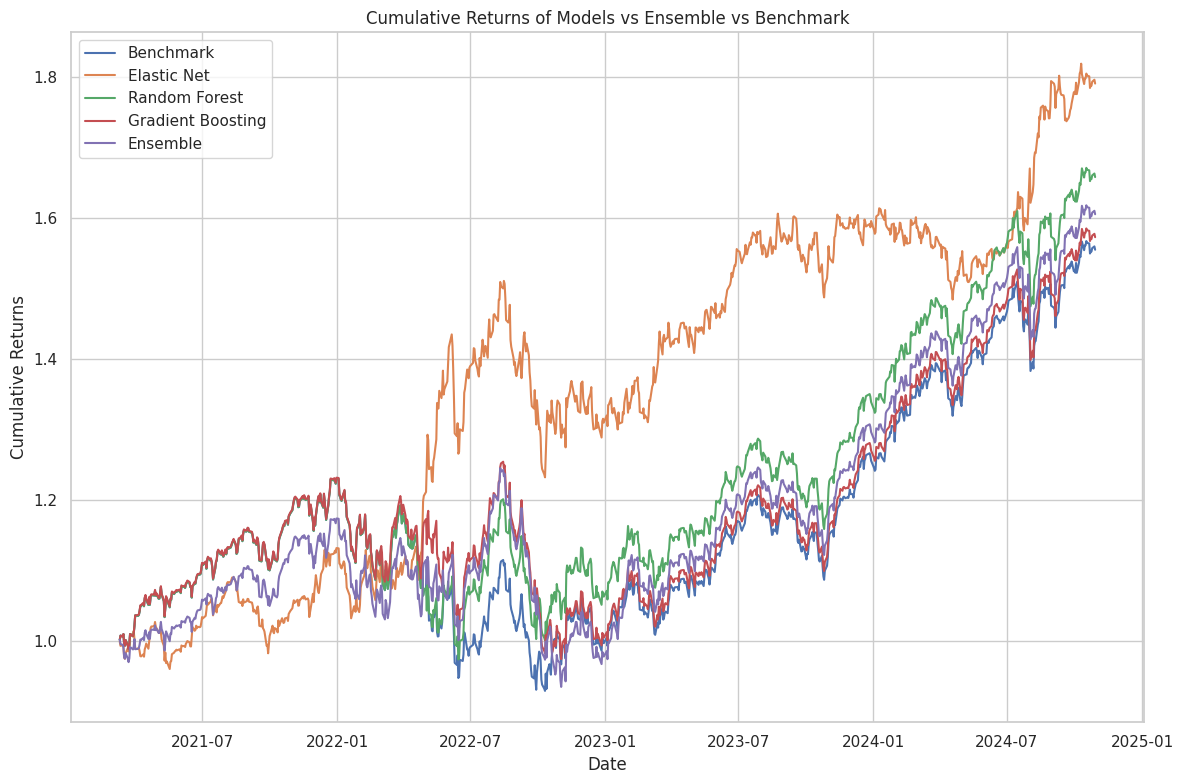

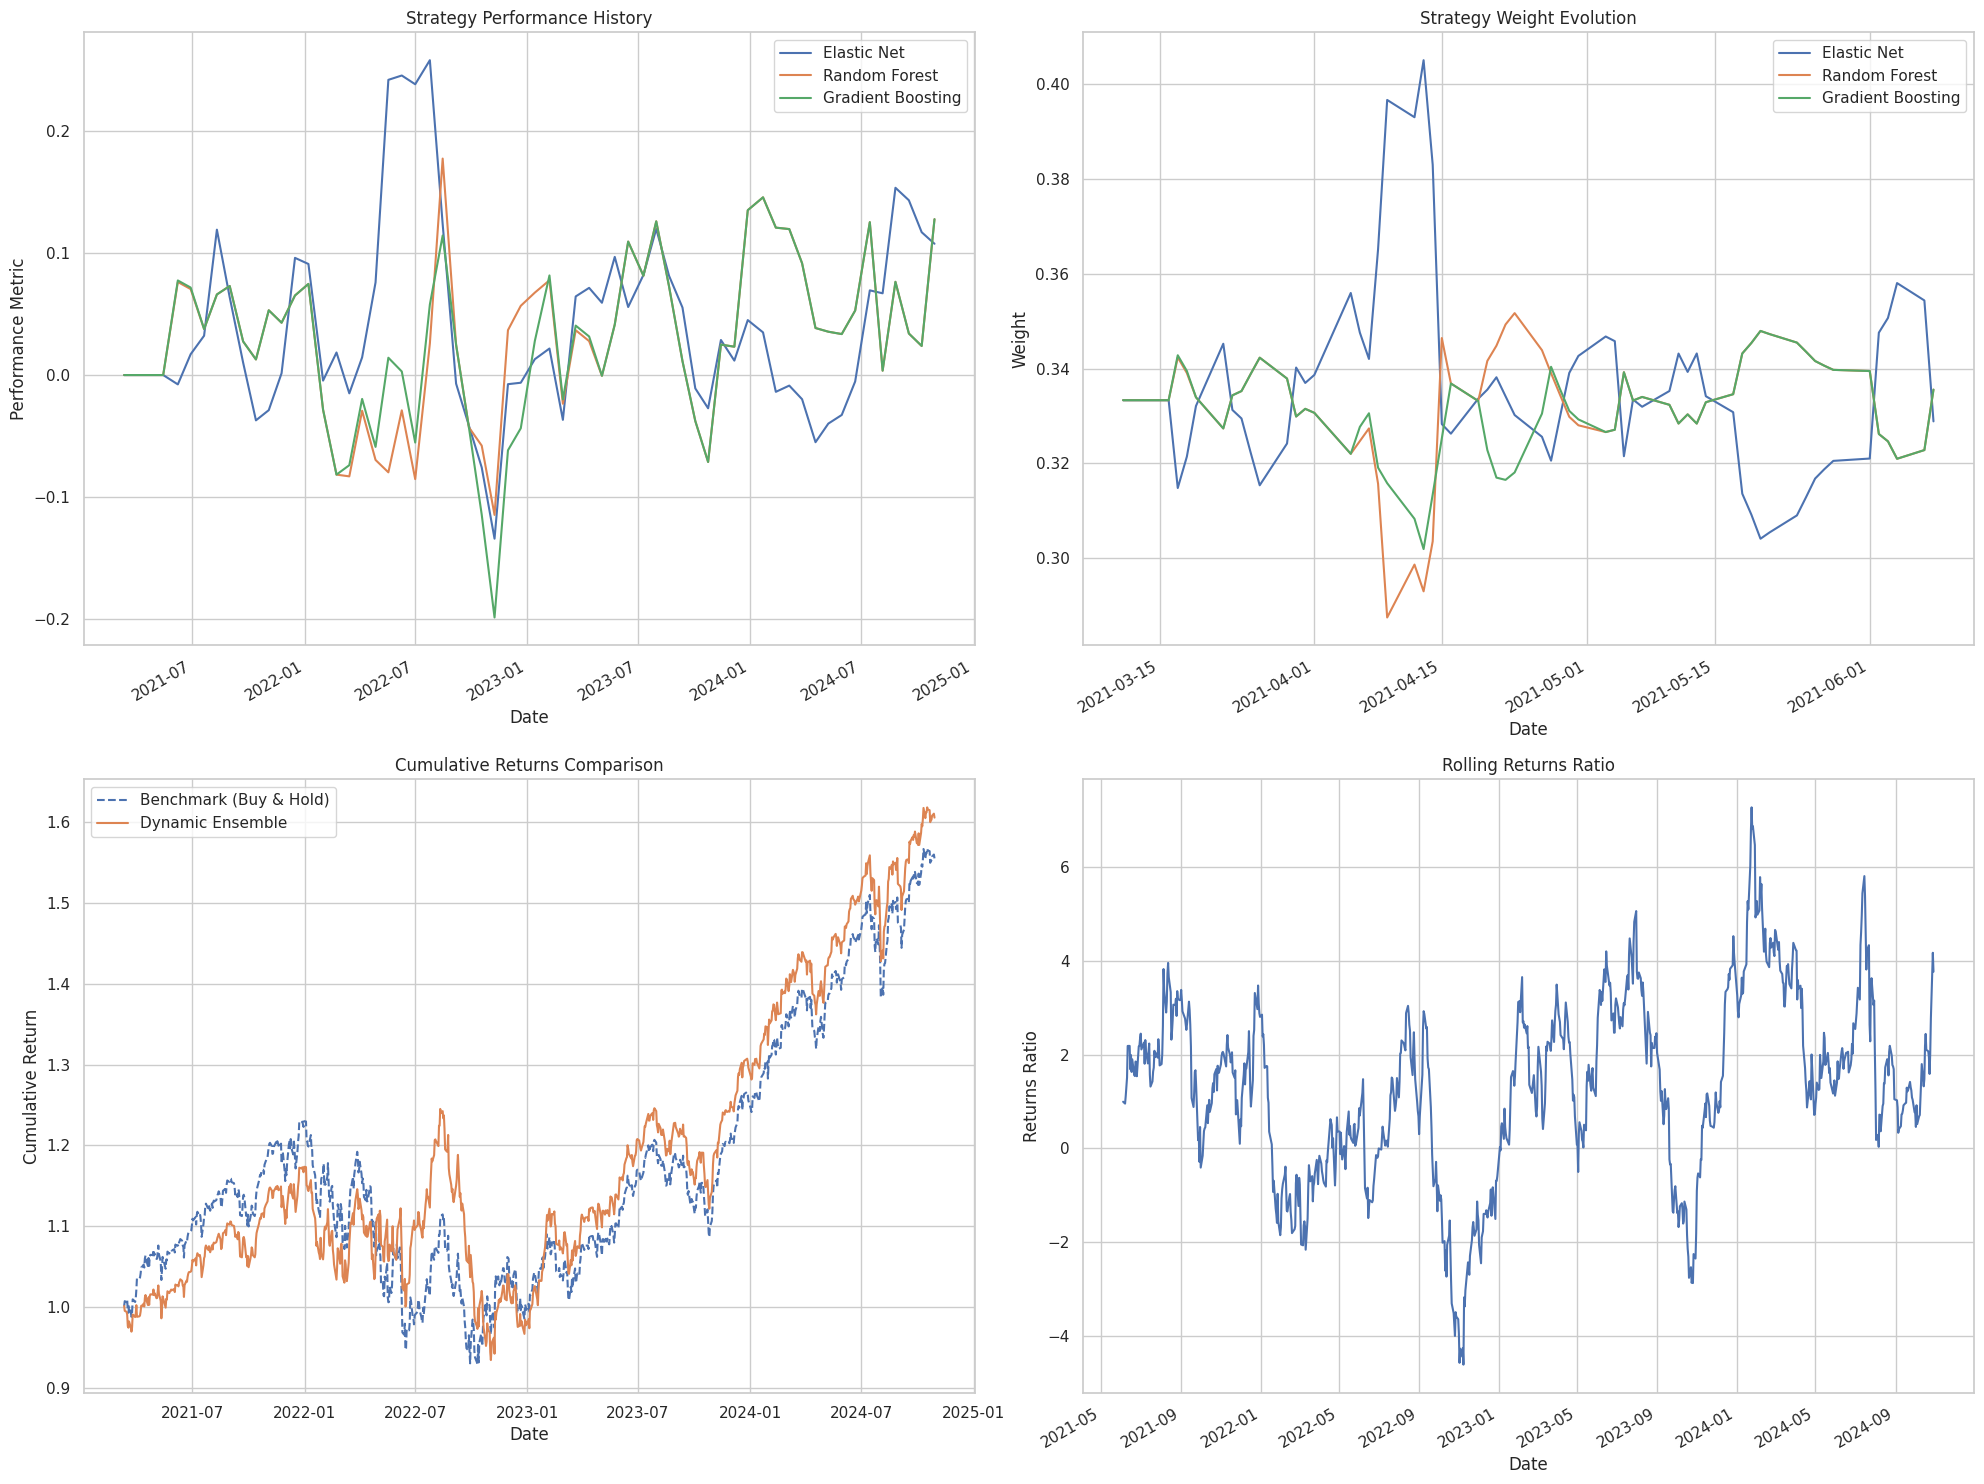


Ensemble Performance Metrics:
Total Return: 0.6058
Annualized Return: 0.1392
Sharpe Ratio: 0.8690
Max Drawdown: -0.2496
Win Rate: 0.5448
Profit Factor: 1.1604


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed


class EnhancedStrategyEnsemble:
    def __init__(
        self,
        model_creator: ModelCreator,
        lookback_window: int = 60,
        update_frequency: int = 20,
        metric: str = 'returns'
    ):
        self.model_creator = model_creator
        self.lookback_window = lookback_window
        self.update_frequency = update_frequency
        self.metric = metric
        self.models = self.model_creator.trained_models
        self.strategy_weights = {name: 1.0 / len(self.models) for name in self.models.keys()}
        self.performance_history = []
        self.weight_history = []
        self.current_best_strategy = None
        self.cumulative_returns = None
        self.strategy_returns = None

    def calculate_strategy_performance(
        self,
        returns: pd.Series,
        predictions: pd.Series,
        method: str = 'sharpe'
    ) -> float:
        strategy_returns = np.sign(predictions) * returns
        epsilon = 1e-8

        if method == 'sharpe':
            std = strategy_returns.std() + epsilon
            return np.sqrt(252) * strategy_returns.mean() / std
        elif method == 'returns':
            return (1 + strategy_returns).prod() - 1
        elif method == 'sortino':
            negative_returns = strategy_returns[strategy_returns < 0]
            std_neg = negative_returns.std() + epsilon
            return np.sqrt(252) * strategy_returns.mean() / std_neg
        else:
            raise ValueError(f"Unsupported performance metric: {method}")

    def softmax(self, x: np.ndarray) -> np.ndarray:
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def update_strategy_weights(
        self,
        X: pd.DataFrame,
        returns: pd.Series,
        current_idx: int
    ) -> Dict[str, float]:
        if current_idx < self.lookback_window:
            weights = {name: 1.0 / len(self.models) for name in self.models.keys()}
            self.weight_history.append(weights)
            self.performance_history.append({name: 0.0 for name in self.models.keys()})
            self.current_best_strategy = None
            return weights

        start_idx = max(0, current_idx - self.lookback_window)
        X_history = X.iloc[start_idx:current_idx]
        returns_history = returns.iloc[start_idx:current_idx]

        performances = {}
        for name, model in self.models.items():
            predictions = model.predict(X_history)
            perf = self.calculate_strategy_performance(
                returns_history,
                predictions,
                self.metric
            )
            performances[name] = perf

        perf_values = np.array(list(performances.values()))
        weights = self.softmax(perf_values)
        weights_dict = dict(zip(performances.keys(), weights))
        self.performance_history.append(performances)
        self.weight_history.append(weights_dict)
        self.current_best_strategy = max(performances.items(), key=lambda x: x[1])[0]
        return weights_dict

    def predict_and_analyze(self, X: pd.DataFrame, returns: pd.Series) -> Tuple[pd.Series, pd.DataFrame]:
        predictions = pd.Series(index=X.index, dtype=float)
        strategy_returns = pd.Series(index=X.index, dtype=float)
        daily_weights = []

        for i in range(len(X)):
            if i % self.update_frequency == 0:
                self.strategy_weights = self.update_strategy_weights(X, returns, i)
            daily_weights.append(self.strategy_weights.copy())
            pred = 0
            for name, model in self.models.items():
                model_pred = model.predict(X.iloc[[i]])
                pred += model_pred[0] * self.strategy_weights[name]
            predictions.iloc[i] = pred
            strategy_returns.iloc[i] = np.sign(pred) * returns.iloc[i]

        self.strategy_returns = strategy_returns
        self.cumulative_returns = (1 + strategy_returns).cumprod()
        weight_df = pd.DataFrame(daily_weights, index=X.index)
        return predictions, weight_df

    def plot_analysis(self, X: pd.DataFrame, returns: pd.Series):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

        history_df = pd.DataFrame(self.performance_history)
        history_df.index = X.index[::self.update_frequency][:len(history_df)]
        history_df.plot(ax=ax1, title='Strategy Performance History')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Performance Metric')

        weight_df = pd.DataFrame(self.weight_history)
        weight_df.index = X.index[:len(weight_df)]
        weight_df.plot(ax=ax2, title='Strategy Weight Evolution')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Weight')

        benchmark_returns = (1 + returns).cumprod()
        ax3.plot(benchmark_returns.index, benchmark_returns, label='Benchmark (Buy & Hold)', linestyle='--')
        ax3.plot(self.cumulative_returns.index, self.cumulative_returns, label='Dynamic Ensemble')
        ax3.set_title('Cumulative Returns Comparison')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Cumulative Return')
        ax3.legend()
        ax3.grid(True)

        rolling_perf_series = self.strategy_returns.rolling(window=self.lookback_window).apply(
            lambda x: np.sqrt(252) * x.mean() / x.std() if x.std() != 0 else 0
        )
        rolling_perf_series.plot(ax=ax4, title=f'Rolling {self.metric.capitalize()} Ratio')
        ax4.set_xlabel('Date')
        ax4.set_ylabel(f'{self.metric.capitalize()} Ratio')
        ax4.grid(True)

        plt.tight_layout()
        plt.show()

    def get_performance_metrics(self) -> Dict[str, float]:
        strategy_returns = self.strategy_returns

        metrics = {
            'Total Return': self.cumulative_returns.iloc[-1] - 1,
            'Annualized Return': (self.cumulative_returns.iloc[-1]) ** (252 / len(strategy_returns)) - 1,
            'Sharpe Ratio': np.sqrt(252) * strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else np.nan,
            'Max Drawdown': (self.cumulative_returns / self.cumulative_returns.cummax() - 1).min(),
            'Win Rate': np.mean(strategy_returns > 0),
            'Profit Factor': (
                strategy_returns[strategy_returns > 0].sum() / 
                abs(strategy_returns[strategy_returns < 0].sum())
            ) if strategy_returns[strategy_returns < 0].sum() != 0 else np.nan
        }

        return metrics


sns.set(style='whitegrid')


if __name__ == "__main__":
    dm = DataManager(start_date='2005-11-01', end_date='2024-10-31', symbol='SPY')
    feature_df = dm.prepare_enhanced_features()
    dm.train_test_split()
    dm.fit_scaler_to_train_data()
    train_data = dm.fit_pca_to_train_data(visualize=True)
    test_data = dm.transform_test_data_with_pca()

    mc = ModelCreator(dm)
    mc.train_models_parallel(train_data)

    print("\nTraining Performance:")
    train_metrics_df = pd.DataFrame.from_dict(mc.performance_metrics, orient='index')
    print(train_metrics_df)

    print("\nTest Performance:")
    test_metrics = mc.evaluate_models(test_data)
    print(test_metrics)

    train_mse = {model: metrics['mse'] for model, metrics in mc.performance_metrics.items()}
    test_mse = {model: metrics['mse'] for model, metrics in test_metrics.iterrows()}

    mse_df = pd.DataFrame({
        'Train MSE': train_mse,
        'Test MSE': test_mse
    })

    mse_df.reset_index(inplace=True)
    mse_df.rename(columns={'index': 'Model'}, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=mse_df.melt(id_vars='Model'), 
                x='Model', 
                y='value', 
                hue='variable')
    plt.title('Mean Squared Error (MSE) for Train and Test Data')
    plt.ylabel('MSE')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

    ensemble = EnhancedStrategyEnsemble(
        model_creator=mc,
        lookback_window=60,
        update_frequency=15,
        metric='returns'
    )

    X_test = test_data.drop('Target', axis=1)
    returns_test = test_data['Target']

    ensemble_predictions, weight_df = ensemble.predict_and_analyze(X_test, returns_test)

    cumulative_returns = pd.DataFrame(index=test_data.index)
    cumulative_returns['Benchmark'] = (1 + returns_test).cumprod()

    model_predictions = mc.predict(test_data)
    for model_name, y_pred in model_predictions.items():
        strategy_returns = pd.Series(returns_test.values * np.sign(y_pred), index=test_data.index)
        cum_returns = (1 + strategy_returns).cumprod()
        cumulative_returns[model_name] = cum_returns

    strategy_returns_ensemble = pd.Series(returns_test.values * np.sign(ensemble_predictions), index=test_data.index)
    cumulative_returns['Ensemble'] = (1 + strategy_returns_ensemble).cumprod()

    plt.figure(figsize=(12, 8))
    for column in cumulative_returns.columns:
        sns.lineplot(data=cumulative_returns, x=cumulative_returns.index, y=column, label=column)

    plt.title('Cumulative Returns of Models vs Ensemble vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()

    ensemble.plot_analysis(X_test, returns_test)

    metrics = ensemble.get_performance_metrics()
    print("\nEnsemble Performance Metrics:")
    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")


## <a id = "p3"> </a> Part 3: Executive Summary (Top 3 Strategies)

The following are the top three trading strategies based on their risk-adjusted returns, growth, and ability to outperform the SPY benchmark. These strategies represent different approaches: machine learning (Elastic Net) and technical analysis (EMA and Bollinger Bands). Each strategy demonstrates unique strengths and areas for improvement, emphasizing the balance between simplicity, adaptability, and risk management.

|          |Sharpe Ratio |CAGR   |Max Drawdown |Money Left |Cumulative Return |
|----------|-------------|-------|-------------|-----------|------------------|
|SPY       | 0.520143    | 0.105836 | 1.337878 | \$677,024 | 6.770237         |
|Strategy 2| 0.590329    | 0.120930 | 1.711225 | \$876,063 | 8.760633         |
|Strategy 4| 0.565033    | 0.112748 | 1.506118 | \$762,160 | 7.621604         |
|Strategy 9 (last 5 years)| 1.011373    | 15.43 | -0.184587 | \$174,936 | 0.749359 |

### Strategy 2: Exponential Moving Average (EMA)

The EMA strategy achieved a Sharpe ratio of 0.5903, a CAGR of 12.09%, and a cumulative return of 8.76x, outperforming SPY on all metrics. Its focus on long-term trends delivered strong risk-adjusted returns and growth potential. A maximum drawdown of 1.71x further underscores its exposure to market downturns, highlighting the need for enhanced risk management.

### Strategy 4: Bollinger Bands

The Bollinger Bands strategy achieved a Sharpe ratio of 0.5650, a CAGR of 11.27%, and a cumulative return of 7.62x, with a maximum drawdown of 1.51x, showing strong risk control compared to EMA. By leveraging volatility trends, it provided structured entry and exit points, contributing to consistent performance.

### Strategy 9: ElasticNet Machine Learning Model

This strategy employs a machine learning approach with the Elastic Net model as the standout performer. The strategy processes 102 indicators, reduced to 20 principal components via PCA, capturing 95% of the variance while addressing multicollinearity. Training (2005–2020) and testing (2021–2024) periods are strictly separated to prevent look-ahead bias.\
\
The Elastic Net achieved a Sharpe ratio of 1.01, a total return of 74.94%, and a maximum drawdown of -18.46%, showcasing robust risk management. Despite a lower hit rate (52.84%), it consistently captured stable market relationships. While the ensemble strategy combining Elastic Net, Random Forest, and Gradient Boosting delivered higher hit rates (54.48%), it underperformed in risk-adjusted returns (Sharpe ratio: 0.869) and faced higher drawdowns (-24.96%) due to increased volatility.\
\
The Elastic Net’s simplicity and consistent performance highlight its strength over complex ensembles, avoiding excessive hyperparameter tuning and overfitting.

**Comparison and Insights** \
All three strategies outperformed SPY, demonstrating their ability to generate superior returns under varying market conditions. Strategy 9 (Elastic Net) delivered the strongest Sharpe ratio (1.01) and controlled drawdowns, making it the most robust. Strategy 2 (EMA) provided higher growth potential (12.09% CAGR), while Strategy 4 (Bollinger Bands) balanced risk and return with its lower drawdown (1.51x).

Each strategy has room for improvement. Strategy 9 could incorporate dynamic position sizing for greater adaptability in volatile markets. Strategy 2 requires better responsiveness to short-term trends and enhanced risk controls. Strategy 4 should refine thresholds to minimize excessive trading and transaction costs. Addressing these areas can enhance consistency and robustness across market environments

## <a id = "p4"> </a> Part 4: Critiques

The SPY, an ETF tracking the S&P 500 Index, reflects the performance of 500 major US companies and serves as a key gauge of the US economy. However, as a capitalization-weighted index, it is heavily influenced by larger companies, with the top 10 holdings making up 34.90% of total assets. This concentration skews performance, as a few mega-cap stocks can disproportionately impact returns, potentially obscuring broader market trends. While SPY provides a useful market overview, its structural bias warrants consideration when evaluating investment strategies.\
\
It is also important to note that all the strategies discussed below are inherently subject to practical limitations in real-world application. Survivorship bias can inflate performance by excluding underperforming or delisted stocks, market regime shifts can alter strategy effectiveness across varying economic conditions, and transaction costs can erode net returns - particularly for high-turnover strategies. These factors must be accounted for when assessing the viability and robustness of any backtested results


### <font color = "green"><a id = "p4a"> </a> 4.1 Momentum </font>

### <a id = "p4.1"> </a> Strategy 1: Simple Moving Average (SMA)

|Metric           |SMA Strategy |SPY Benchmark |Observation|
|-----------------|-------------|--------------|-----------|
|Sharpe Ratio     |0.550275     |0.520143      |Higher risk-adjusted returns|
|CAGR             |0.112292     |0.105836      |Better annualized growth|
|Max Drawdown     |2.373698     |1.337878      |Higher risk|
|Money Left       | \$756,248   | \$677,024    |Higher cumulative value|
|Cumulative Return|7.562481     |6.770237      |Greater overall returns|

The SMA strategy, using 157-day and 252-day windows, outperforms the SPY benchmark with higher Sharpe ratio, CAGR, and cumulative returns, indicating improved risk-adjusted performance. However, the chosen window lengths are not representative of typical momentum strategies, where short windows are generally less than 50 days. This limits the strategy’s ability to capture short-term trends and respond to rapid market changes. Additionally, the higher maximum drawdown highlights increased downside risk, making it less appealing to risk-averse investors.\
\
Another key issue is potential lookahead bias, as the chosen parameters may have been optimized using the entire dataset, inflating backtested performance. This raises concerns about overfitting and reduces confidence in the strategy’s out-of-sample reliability. Frequent rebalancing during volatile periods further challenges its real-world applicability, as transaction costs and slippage can erode profitability. Incorporating realistic cost assumptions in backtesting is critical to evaluate the strategy’s true performance. To mitigate high drawdowns, integrating risk management techniques such as stop-loss mechanisms or dynamic position sizing would make the strategy more resilient to adverse market conditions


### <a id = "p4.2"> </a> Strategy 2: Exponential Moving Average (EMA)

|Metric           |EMA Strategy |SPY Benchmark |Observation|
|-----------------|-------------|--------------|-----------|
|Sharpe Ratio     |0.590329     |0.520143      |Higher risk-adjusted returns|
|CAGR             |0.120930     |0.105836      |Better annualized growth|
|Max Drawdown     |1.711225     |1.337878      |Moderately higher drawdown|
|Money Left       | \$876,063   | \$677,024    |Higher cumulative value|
|Cumulative Return|8.760633     |6.770237      |Greater overall returns|

The EMA strategy, using 200-day and 249-day windows, demonstrates stronger outperformance than the SPY benchmark, with higher Sharpe ratio, CAGR, and cumulative returns. However, like the SMA, these window lengths are too long for traditional momentum strategies, limiting responsiveness to short-term trends. This reduces the EMA's adaptability to dynamic market conditions, particularly during rapid reversals or extreme volatility.\
\
The use of fixed window lengths also raises concerns about lookahead bias, as the parameters may have been optimized for the dataset, potentially overstating results. Transaction costs and slippage, particularly during periods of frequent trades, remain a significant limitation and should be incorporated into backtesting. While the EMA is more responsive than the SMA, both strategies would benefit from dynamic window adjustments and robust sensitivity testing to ensure reliability in varying market regimes


### <a id = "p4.3"> </a> Strategy 3: KDJ Indicator

|Metric           |KDJ Strategy |SPY Benchmark |Observation|
|-----------------|-------------|--------------|-----------|
|Sharpe Ratio     |0.450916     |0.520143      |Efficient risk-adjusted returns|
|CAGR             |0.064806     |0.105836      |Lower annualized growth|
|Max Drawdown     |0.682090     |1.337878      |Lower drawdown|
|Money Left       | \$329,944   | \$677,024    |Lower cumulative value|
|Cumulative Return|3.299444     |6.770237      |Weaker overall returns|

The KDJ strategy generates frequent signals due to its reliance on short-term momentum, which can lead to overtrading in volatile markets. The J-component, in particular, amplifies short-term price swings, often resulting in false positives. Additionally, the Max Drawdown of 68.21% indicates significant risk during periods of high volatility or prolonged downtrends.\
\
Similar to RSI and MACD, the optimization process for KDJ may have introduced overfitting, as it relies on a single training dataset without proper cross-validation. Furthermore, the small smoothing coefficients (m1=4, m2=2) make the strategy overly sensitive to recent data, reducing its robustness across different market regimes. The strategy also underperformed during strong bull markets, such as the post-2012 period, indicating its sensitivity to varying market phases and its limited adaptability in upward-trending conditions.

### <font color = "green"><a id = "p4b"> </a> 4.2 Mean-Reversion </font>

### <a id = "p4.4"> </a> Strategy 4: Bollinger Bands

|Metric           |BB Strategy  |SPY Benchmark |Observation|
|-----------------|-------------|--------------|-----------|
|Sharpe Ratio     |0.565033     |0.520143      |Slightly higher risk-adjusted returns|
|CAGR             |0.112748     |0.105836      |Better annualized growth|
|Max Drawdown     |1.506118     |1.337878      |Moderately higher drawdown|
|Money Left       | \$762,160   | \$677,024    |Higher cumulative value|
|Cumulative Return|7.621604     |6.770237      |Greater overall returns|

The Bollinger Band strategy on the VIX uses thresholds of 48 and 44 as buy and sell signals for the S&P 500, aiming to exploit volatility expectations and trends. This approach outperforms the SPY benchmark, achieving higher Sharpe ratio, CAGR, and cumulative returns. By capitalizing on extreme volatility levels, the strategy benefits from the relationship between fear-driven market behavior and equity trends, providing structured entry and exit points. However, the chosen thresholds (48 and 44) may be too narrow, which may result in excessive trading and increased transaction costs. This excessive activity, particularly during volatile markets, could significantly erode returns, making it crucial to evaluate trade frequency and refine the thresholds.\
\
Similar to the momentum strategies, the Bollinger Band strategy is susceptible to lookahead bias, as the thresholds may have been optimized on the entire dataset. This optimization raises concerns about overfitting and reduces the strategy’s adaptability to evolving market conditions. Additionally, relying on the VIX, a lagging indicator, limits the strategy’s ability to react to sudden market shocks, such as geopolitical events or policy changes. Prolonged periods of volatility clustering can further affect performance by leading to missed opportunities or holding positions for extended periods.\
\
Transaction costs and slippage remain a significant limitation, as frequent trades triggered by tight thresholds could substantially reduce profitability. To address these issues, the strategy would benefit from dynamic thresholds, improved risk management mechanisms such as stop-loss orders, and robust sensitivity testing to ensure long-term reliability and adaptability across different market conditions.

### <a id = "p4.5"> </a> Strategy 5: MACD

|Metric           |MACD Strategy|SPY Benchmark |Observation|
|-----------------|-------------|--------------|-----------|
|Sharpe Ratio     |0.068709     |0.520143      |Lower risk-adjusted returns|
|CAGR             |0.013385     |0.105836      |Lower annualized growth|
|Max Drawdown     |0.618988     |1.337878      |Lower drawdown|
|Money Left       | \$128,758   | \$677,024    |Lower cumulative value|
|Cumulative Return|1.287589     |6.770237      |Weaker overall returns|

The current parameter range (short-term EMA: 10–14, long-term EMA: 34–38, signal line: 8–12) was selected after testing broader ranges (e.g., short-term EMA: 5–26, long-term EMA: 21–52). However, the broader ranges resulted in even poorer performance, suggesting inherent limitations in the strategy. Even with the narrowed range, the training Sharpe Ratio remains low at 0.146, dropping further to 0.068 for the total Sharpe Ratio, which indicates significant overfitting.\
\
The strategy struggles to adapt to different market phases. While its performance from 2008 to 2012 is comparable to a buy-and-hold approach, it significantly underperforms during the post-2012 bull market and shows inconsistent results during the volatile post-2020 period. This highlights its inability to effectively navigate trending or volatile markets.\
\
Its reliance on MACD crossovers, without accounting for trend strength or prevailing market conditions, further limits its effectiveness. Additionally, the absence of risk management tools, such as stop-loss mechanisms or dynamic position sizing, exposes the strategy to unnecessary risks and increases the likelihood of substantial drawdowns.

### <a id = "p4.6"> </a> Strategy 6: RSI

|Metric           |RSI Strategy |SPY Benchmark |Observation|
|-----------------|-------------|--------------|-----------|
|Sharpe Ratio     |0.431067     |0.520143      |Lower risk-adjusted returns|
|CAGR             |0.041253     |0.105836      |Lower annualized growth|
|Max Drawdown     |0.529755     |1.337878      |Lower drawdown|
|Money Left       | \$215,657   | \$677,024    |Lower cumulative value|
|Cumulative Return|2.156576     |6.770237      |Weaker overall returns|

The RSI strategy shares common limitations with MACD, including its reliance on fixed thresholds and difficulty adapting to varying market conditions. However, RSI exhibits better overall performance in both training and testing datasets. Despite this, RSI's unique characteristics present additional challenges. Its sensitivity to short-term price movements often generates excessive noise and false signals in volatile markets. Additionally, while MACD's delayed signals struggle in trending markets, RSI's premature signals can lead to early exits or missed opportunities during sustained trends. Addressing these distinct weaknesses, along with the shared limitations, is crucial for enhancing the strategy's robustness and adaptability.

To improve the RSI strategy, the following enhancements can be prioritized:

1. Replace fixed thresholds with adaptive levels based on market volatility, such as using Bollinger Bands, to better capture changing market dynamics.
2. While integrating RSI with trend indicators like moving averages is often recommended to align trades with broader market trends and reduce false signals, this approach may not be effective in this case. Both RSI and moving averages have shown poor individual performance, suggesting that combining them might not resolve issues with signal reliability or adaptability to market conditions.
3. Introduce stop-loss mechanisms and volatility-adjusted position sizing to limit drawdowns and improve capital protection during periods of heightened uncertainty. 

These adjustments could help mitigate the strategy's weaknesses and improve its ability to navigate different market environments effectively.

### <font color = "green"><a id = "p4c"> </a> 4.3 Combined Strategies </font>

### <a id = "p4.7"> </a> Strategy 7: KDJ + MACD

|Metric           |KDJ + MACD Strategy |SPY Benchmark |Observation|
|-----------------|-------------|--------------|-----------|
|Sharpe Ratio     |0.361534     |0.520143      |Lower risk-adjusted returns|
|CAGR             |0.072435     |0.105836      |Lower annualized growth|
|Max Drawdown     |2.130570     |1.337878      |Higher drawdown|
|Money Left       | \$377,902   | \$677,024    |Lower cumulative value|
|Cumulative Return|3.779026     |6.770237      |Weaker overall returns|

The combination of KDJ and MACD strikes a balance between momentum (KDJ) and trend-following (MACD), reducing false signals compared to using either strategy individually. With optimized parameters (KDJ_n=8, MACD short EMA=10, long EMA=47, signal EMA=11), the strategy performed well during training, achieving a Sharpe Ratio of 0.54 and growing capital to $520,023.91. Although testing results were weaker, with a Sharpe Ratio of 0.3615 and a CAGR of 7.24%, it still outperformed standalone KDJ or MACD strategies, particularly in range-bound markets.\
\
However, the strategy faces notable challenges. It underperforms in strong bull markets (e.g., post-2012) due to its reliance on mean-reversion (KDJ) and lagging signals (MACD), which limit its ability to adapt to sustained upward trends. A significant drawdown of 213% during testing highlights considerable risk during volatile or bearish periods, making the strategy less suitable for conservative investors. Furthermore, its dependence on optimized parameters raises concerns about overfitting and casts doubt on its robustness in untested market conditions.\
\
Improving the strategy’s adaptability to shifting trends and implementing stronger risk management measures could enhance its performance and reliability across varying market environments.

### <a id = "p4.8"> </a> Strategy 8: MACD + RSI + KMeans

The strategy's design effectively prevents forward-looking bias by ensuring strict separation of training and testing data, confining StandardScaler fitting to the training set, and shifting signals properly. These measures ensure realistic performance metrics without future data contamination.\
\
However, the strategy's effectiveness is undermined by hyperparameter sensitivity. The regime classification parameters (10-period moving average and 0.7 threshold) and unconventional RSI (45/55) and MACD (12/26/9) settings rely heavily on optimization rather than market fundamentals. Performance degrades significantly when parameters are altered, indicating overfitting to the training period.\
\
While the combination of machine learning-based regime detection and technical indicators shows potential, the reliance on finely tuned parameters limits robustness across varying market conditions. To improve, the strategy needs less dependence on optimized thresholds and greater integration of fundamental market principles for better adaptability and consistency.

### <a id = "p4.9"> </a> Strategy 9: XGBoost + ElasticNet + RandomForest + PCA

The strategy demonstrates several strengths. Its modular design, separating data management, model development, and ensemble voting, ensures maintainability and adaptability. Feature engineering effectively incorporates a broad set of indicators, while PCA addresses multicollinearity and reduces dimensionality, retaining 95% of total variance with just 20 principal components. The strategy rigorously prevents look-ahead bias by ensuring proper temporal separation in data processing, PCA fitting, and model training, while the use of tree stumps in Random Forest and Gradient Boosting enhances regularization and reduces overfitting.\
\
Despite its strengths, the strategy has critical weaknesses. Daily rebalancing does not account for transaction costs or market impact, potentially eroding returns. The fixed 60-day lookback window for performance evaluation delays responsiveness to rapid market changes, while the 15-day model weight adjustment can cause abrupt shifts, adding volatility. The ensemble's maximum drawdown of -24.96%, exceeding that of any individual model, highlights flaws in the softmax-based weight allocation mechanism, which may amplify risk rather than diversify it.\
\
The strategy’s lack of volatility targeting and position-sizing rules results in binary long/short positions that fail to adjust for varying prediction confidence or market volatility. This reduces adaptability in turbulent periods. Additionally, PCA, while effective for dimensionality reduction, obscures the influence of individual features, limiting interpretability. The ensemble approach, while boosting prediction accuracy, struggles to fully integrate the strengths of each model, often amplifying their weaknesses instead.\
\
Practical challenges include reliance on extensive feature engineering, which could falter if data sources change or become unavailable. The absence of explicit risk management mechanisms, such as volatility-adjusted exposure or stop-losses, leaves the strategy vulnerable during periods of market turbulence. These limitations suggest the need for refining weight allocation mechanisms, incorporating transaction costs, and improving dynamic risk management to enhance robustness and practical applicability.

## <a id = "p5"> </a> Part 5: Contribution Statement

**Frederik** was responsible for the development and evaluation of strategies 8 and 9. His contributions included designing the frameworks for these strategies, conducting thorough backtesting, and critically analyzing the results to assess their performance and feasibility in real-world scenarios.\
\
**Hong Yang** made significant contributions by developing and analyzing strategies 3, 5, 6, and 11. This involved designing, implementing, and thoroughly evaluating the assigned strategies to ensure their alignment with the project’s objectives.\
\
**Michelle** focused on the development of strategies 1, 2, and 4. In addition to this, she took on the responsibility of compiling and organizing the group’s code, ensuring that all strategies were implemented correctly and functioned smoothly.\
\
Together, the team collaborated effectively, ensuring the project was comprehensive and achieved its objectives.

[Back to Table of Contents](#top)